In [250]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import time
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain, product, combinations, cycle
import math
from functools import reduce, partial
from collections.abc import Iterable
import pickle, gzip

import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import einops
from einops import rearrange

In [192]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock
from transformers.models.xglm.modeling_xglm import XGLMAttention

# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In [82]:
sys.path.insert(0, '/nas/xd/projects/pptree')
from pptree import Node, print_tree

In [ ]:
from child_utils import *
from common_utils import *
from model_utils import *

In [246]:
torch.set_grad_enabled(False);

In [ ]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [ ]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in ['gpt2-large', 
            'gpt2-xl', 'EleutherAI/gpt-neo-1.3B',  # = babbage
            'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', # = curie 
            'KoboldAI/fairseq-dense-13B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

In [18]:
# model_name = 'gpt2-large'  # medium / large /xl
model_name = 'EleutherAI/gpt-j-6B' # gpt-j-6B, gpt-neo-1.3B/2.7B
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [2915]:
for block in model.transformer.h: _ = block.attn.to('cuda')

In [3041]:
for block in model.transformer.h: _ = block.attn.to('cpu')
torch.cuda.empty_cache()

In [258]:
unify(model)
# blocks = model.transformer.h
# attn0 = blocks[0].attn
# ln_f = model.transformer.ln_f
# L, H, embed_dim = len(blocks), attn0.num_heads, attn0.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# with torch.no_grad():
#     _e = [we]
#     for b in blocks[:1]: _e.append(_e[-1] + mlp_forward(b, _e[-1]))

In [41]:
device = 'cuda'
config = model.config
for block in model.transformer.h[8:]:
    # block.ln_1_gpu = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    # block.attn_gpu = type(block.attn)(config)
    # if my_isinstance(block.attn, GPTJAttention): # need unify for other models
    #     block.attn_gpu.num_heads = block.attn_gpu.num_attention_heads
    block.mlp_gpu = type(block.mlp)(config.n_inner if config.n_inner is not None else 4 * config.n_embd, config)
    for name in ['mlp']: # ['ln_1', 'attn']:
        _ = getattr(block, name + '_gpu').load_state_dict(getattr(block, name).state_dict())
        _ = getattr(block, name + '_gpu').to(device)
        setattr(block, name + '_cpu', getattr(block, name))
    block.ln_2_gpu, block.ln_2_cpu = block.ln_1_gpu, block.ln_1_cpu
    

In [21]:
weBTAs = [_e[i].T @ _e[i] for i in range(2)]
weBTAs = [e.to(attn0.k_proj.weight.device) for e in weBTAs]
# weBTAs = [e.to('cpu') for e in weBTAs]

In [22]:
all_heads = list(product(range(L), range(H)))
all_heads_by_layer = [(l, None) for l in range(L)]
def heads_in_layers(layer_start, layer_stop, H=H): return list(product(range(layer_start, layer_stop), range(H)))

In [ ]:
a = o.attentions[12][0, 10]
sim = torch.einsum('lhij->lh', (torch.cat(o.attentions) + 1e-9).log() * a * torch.ones_like(a).tril())
list(zip(*topk_md(sim, 10)))

In [ ]:
l = 10
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:1]:
    for k in range(H // 4):
        # print(layer, k * 2, k * 2 + 1)
        fig, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20, 5))
        h = k * 4 + 0; plot_attn(o.attentions[l][0, h], tokens, ax=axs[0])
        h = k * 4 + 1; plot_attn(o.attentions[l][0, h], tokens, ax=axs[1])
        h = k * 4 + 2; plot_attn(o.attentions[l][0, h], tokens, ax=axs[2])
        h = k * 4 + 3; plot_attn(o.attentions[l][0, h], tokens, ax=axs[3])

## Amplification

In [727]:
def test(model, data_tuples, verbose=False, **kwargs):
    losses = []
    # self_attrs = []; all_attentions2 = []; intermediary_head_outputs = []
    outputs = []
    for data_tuple in data_tuples[:]:
        text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels = data_tuple[:8]
        # loss, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
        #             topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        # if verbose: print('loss =', loss)
        
        from_layer, hidden_states = None, None
        # if ({'intermediary_heads', 'special_head'} & set(kwargs.keys())) and len(data_tuple) > 8:
        #     o = data_tuple[8]
        #     from_layer = kwargs['intermediary_heads'][0][0]
        #     hidden_states = o.hidden_states[from_layer]
        with torch.no_grad():
            o = forward(model, inputs, labels=labels, attribute_layer=from_layer, hidden_states=hidden_states, **kwargs)
        loss2, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        if verbose: print('loss2 =', loss2, '\n')
        losses.append(loss2.item())
        # if hasattr(o, 'self_attrs'): self_attrs.append(o.self_attrs)
        # if hasattr(o, 'all_attentions2'): all_attentions2.append(o.all_attentions2)
        # if hasattr(o, 'intermediary_head_outputs'): intermediary_head_outputs.append(o.intermediary_head_outputs)
        outputs.append(o)
        if len({'intermediary_heads', 'special_head'} & set(kwargs.keys())) == 0:
            del data_tuple[8:]; data_tuple.append(o)
    losses = torch.Tensor(losses)
    print('losses =', losses)
    return losses.mean(), outputs # self_attrs, all_attentions2

In [24]:
hds = Heads()
hds.QKov = [(3, 11), (3, 6), (4, 8), (6, 10)] # [5, 4] K-comp heads / type-2 relating heads
hds.KQQK = hds.kqovOV = [(1, 7), (6, 7), (6, 2), (8, 7), (10, 7)] # same qk heads / type-1 relating heads
hds.kqOVov = [(8, 1), (12, 10), (13, 13),] # (8, 0), (9, 14), (15, 7), (16, 7), (11, 0)] # intermediary heads

In [1108]:
relating_heads = hds.QKov + hds.kqovOV[1:]; print(relating_heads)
# intermediary_heads = hds.kqOVov[:]
# predicting_heads = heads_in_layers(9, L) #KQovov
# relating_heads = [(1, 7), (3, 11), (3, 6), (4, 8), (5, 4), (6, 10), (6, 7), (6, 2), (8, 7), (10, 7)] # + 5-4

[(3, 11), (3, 6), (4, 8), (6, 10), (6, 7), (6, 2), (8, 7), (10, 7)]


In [ ]:
t = data_tuples[2]
tokens, o = t[3], t[-1]
plot_attn(o.attentions[13][0, 2], tokens=tokens)

In [1263]:
print(test(model, data_tuples, verbose=True, device=device, to_gpu_layer=8, mlp_to_gpu=True)[0])

  m 0.076 {' u': 0.864, ' m': 0.076, ' v': 0.014} 	  u u m u -> m
  u 0.223 {' 7': 0.402, ' u': 0.223, ' v': 0.084} 	  u 7 7 7 -> u
  7 0.151 {' 1': 0.722, ' 7': 0.151, ' u': 0.021} 	  1 1 1 7 -> 7
  y 0.279 {' z': 0.65, ' y': 0.279, ' 7': 0.014} 	  y z z z -> y
loss2 = tensor(1.8123) 

* j 0.725 {' j': 0.725, ' p': 0.126, ' 0': 0.065} 	  p j p p -> j
* e 0.719 {' e': 0.719, ' o': 0.157, ' 0': 0.037} 	  o e o o -> e
* h 0.825 {' h': 0.825, ' l': 0.141, ' 0': 0.005} 	  l h l l -> h
* m 0.731 {' m': 0.731, ' 4': 0.224, '\n': 0.005} 	  4 m 4 4 -> m
loss2 = tensor(0.2892) 

  u 0.003 {' z': 0.959, ' a': 0.007, '\n': 0.004} 	  u z z z -> u
  8 0.286 {' v': 0.614, ' 8': 0.286, ' u': 0.008} 	  8 v v v -> 8
* 6 0.543 {' 6': 0.543, ' 9': 0.348, ' r': 0.03} 	  6 9 9 9 -> 6
* n 0.643 {' n': 0.643, ' j': 0.255, ' 9': 0.019} 	  n j j j -> n
loss2 = tensor(1.9930) 

losses = tensor([1.8123, 0.2892, 1.9930])
tensor(1.3649)


In [ ]:
losses = tensor([0.8525, 1.0014, 0.8600]) tensor(0.9046)

relating_heads=[], intermediary_heads=hds.kqOVov[1:2], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2.], hq_multiplier=10., multipliers=[1.5, 0], self_attr_threshold=5.
losses = tensor([0.9319, 0.8513, 0.7590]) tensor(0.8474)

relating_heads=[], intermediary_heads=hds.kqOVov[0:2], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2., 2.], hq_multiplier=10., multipliers=[1.5, 0], self_attr_threshold=5.
losses = tensor([0.9237, 0.8758, 0.6133]) tensor(0.8043)

relating_heads=[], intermediary_heads=hds.kqOVov[0:3], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2., 2., 2], hq_multiplier=10., multipliers=[1.5, 0], self_attr_threshold=5.
losses = tensor([1.0008, 0.7892, 0.6062]) tensor(0.7987)


relating_heads=[], intermediary_heads=hds.kqOVov[1:2], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2., ], hq_multiplier=10., multipliers=[1., 0], self_attr_threshold=5.
losses = tensor([0.9127, 0.9094, 0.6992]) tensor(0.8404)

relating_heads=[], intermediary_heads=hds.kqOVov[0:2], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2., 2.,], hq_multiplier=10., multipliers=[1., 0], self_attr_threshold=5.
losses = tensor([0.9268, 0.8078, 0.5017]) tensor(0.7454)    

relating_heads=[], intermediary_heads=hds.kqOVov[0:3], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2., 2., 2], hq_multiplier=10., multipliers=[1., 0], self_attr_threshold=5.
losses = tensor([0.8701, 0.7224, 0.3972]) tensor(0.6632)

relating_heads=[], intermediary_heads=hds.kqOVov[0:3], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[3., 3., 3.], hq_multiplier=10., multipliers=[1., 0], self_attr_threshold=5.
losses = tensor([1.0411, 0.5965, 0.2770]) tensor(0.6382)

In [1270]:
predicting_heads = [(13, 2), (14, 6), (16, 6), (22, 14)]# (17, 9), (18, 13)]
intermediary_heads = hds.kqOVov #[(8, 0), (8, 1), (8, 3), (9, 0), (9, 14), (11, 4), (11, 9), (12, 10)]
# intermediary_heads = [(8, 0), (8, 1), (9, 14), (12, 10)]
loss, outputs = test(model, data_tuples, verbose=False, device=device, mlp_to_gpu=True,
        relating_heads=[], intermediary_heads=hds.kqOVov[1:2], predicting_heads=heads_in_layers(13, L),
        intm_head_multipliers=[2, ], hq_multiplier=4., multipliers=[0, 1.5], self_attr_threshold=5., exit_layer=None
)
print(loss)
# sa = torch.stack(sa)  # pad(torch.stack(sa), 1, L, pad_left=True) # blnmri
# all_attentions2 = pad(torch.stack(all_attentions2), 1, L, pad_left=True)

losses = tensor([1.9822, 0.1839, 2.0931])
tensor(1.4197)


In [734]:
intm_head_outputs = [o.intermediary_head_outputs for o in outputs]
intm_head_outputs[1].size()

torch.Size([3, 10, 64, 4096])

In [901]:
def masked_softmax(logits, local=1):
    logits = logits - 1e9 * (torch.ones_like(logits).triu(diagonal=1) + local * torch.ones_like(logits).tril(diagonal=-6))
    return logits.softmax(-1)

In [1198]:
cat_hqs = [o.cat_hqs for o in outputs]

In [1199]:
intermediary_heads

[(8, 1), (12, 10), (13, 13)]

14 6


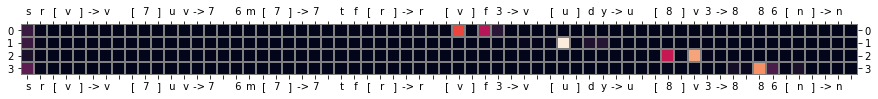

In [1223]:
bi = 0
l, h = predicting_heads[1]; print(l, h)
tokens, labels, o = data_tuples[bi][3], data_tuples[bi][7], data_tuples[bi][8]
hk = blocks[l].ln_1(o.hidden_states[l])
plot_attn(o.attentions[l][0, h][labels[0] != -100], tokens=tokens)

[(8, 1), (12, 10), (13, 13)]


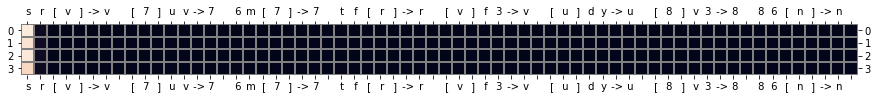

In [1230]:
intm_head_indices = [0, 1, 2]; print([intermediary_heads[hi] for hi in intm_head_indices])
hq = cat_hqs[bi][l][3:, -1:].sum((0, 1)).unsqueeze(0)  # mrie->ie->bie
aw = attn_forward(blocks[l], hq, hk, hk)[1][0, h][labels[0] != -100]
plot_attn(aw, tokens=tokens)

[(8, 1), (12, 10), (13, 13)]


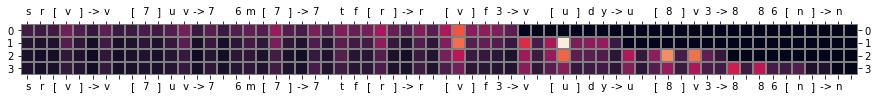

In [1221]:
intm_head_indices = [0, 1, 2]; print([intermediary_heads[hi] for hi in intm_head_indices])
hq = cat_hqs[bi][l][intm_head_indices, :8].sum((0, 1)).unsqueeze(0)  # mrie->ie->bie
aw = attn_forward(blocks[l], hq, hk, hk)[1][0, h][labels[0] != -100]
plot_attn(aw, tokens=tokens)

In [581]:
sa[:, :, :, -1] = 0
if sa.size(-2) == 1: sa = sa.squeeze(-2)  # blnm1i-> blnmi
Counter([tuple(head) for head in (sa > 20).nonzero()[:, 1:4].tolist()]).most_common()

[((13, 2, 0), 6), ((13, 2, 1), 3)]

In [296]:
a = sa[:, :, :, 0:-1].amax((-3, -2))  # blnmri->blni
Counter([tuple(head) for head in (a > 8).nonzero()[:, 1:3].tolist()]).most_common()

[((13, 2), 13), ((14, 6), 4), ((13, 4), 3)]

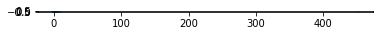

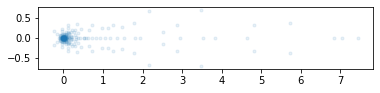

(0.9798403382301331, 0.9890806078910828)

In [992]:
plot_eigv(weightprod(model, [(8, 7), (12, 10), (14, 6)], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=True))

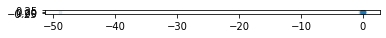

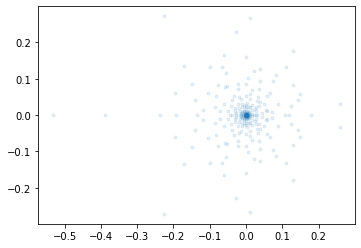

(-0.7608173489570618, 0.9093077182769775)

In [1288]:
plot_eigv(weightprod(model, [(3, 3), (12, 10), (13, 9)], 'e vo vo qk e', weBTA=weBTAs[0], absorb_ln=True))

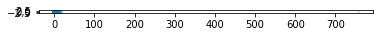

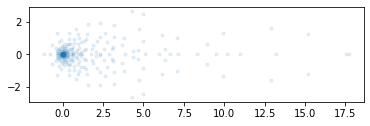

(0.9508721828460693, 0.967559278011322)

In [1022]:
plot_eigv(weightprod(model, [(13, 2), (14, 6)], 'e vo qk e', weBTA=weBTAs[0], absorb_ln=True))

In [ ]:
l, h = 6, 2
i = 2
t = data_tuples[i]
tokens, o = t[3], t[-1]
plot_attn(o.attentions[l][0, h], tokens=tokens)
# plot_attn(all_attentions2[i][l][0, h], tokens=tokens)

In [ ]:
x = sa[:, :, :, :-1, :]
plt.hist(x[(x != 0) & (x < 1000)].view(-1).numpy(), bins=40);

In [ ]:
x, y = sa[:, :, :, 0:3, :].amax((-3, -2)).reshape(-1), a[:, :].reshape(-1)
x, y = x[(x != 0) & (x > 0)], y[(x != 0) & ( x > 0)]
_=plt.plot(x, y, '.');
pearsonr(x, y)

In [ ]:
[data_tuple[0] for data_tuple in data_tuples]
a = []
for data_tuple in data_tuples[:]:
    text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels = data_tuple[:8]
    head_mask = torch.ones(L, 1, H, labels.size(-1))  # 11ni
    _ = head_mask.requires_grad_(True)
    o = forward(model, inputs, labels=labels, head_mask=head_mask)
    a.append(torch.autograd.grad(-o.loss, head_mask)[0].squeeze(1)[..., (labels != -100)[0]]) # l1ni->lni'
    show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
a = torch.stack(a)  # blni'

In [3584]:
a = torch.zeros(L, H, *self_attrs.size()[-2:])
a[tuple(zip(*predicting_heads))] = self_attrs
self_attrs = a

In [ ]:
sattr = self_attrs[:, :, 1, 6:10]
# pattern = ' '.join(['l n', ' '.join([f'd{i}' for i in range(sattr.ndim - 2)])]) + ' -> l n' # l n [d0 [d1]] -> l n
# sattr = einops.reduce(sattr, pattern, 'sum')
sattr = sum_except(sattr, (0, 1))
x, y = sattr[sattr != 0], attr.head[sattr != 0]
_=plt.plot(x, y, '.')
pearsonr(x, y)

In [ ]:
row, col = 2, 4
mask = torch.ones(self_attrs.size()[-2:]); mask[-1, -2:] = 0
top_attrs = torch.stack([self_attrs[head] * mask for head in 
    zip(*topk_md(self_attrs[:, :, :-1, :].sum((-2, -1)), row*col)[:2])])
top_attrs = rearrange(top_attrs, '(row col) m r -> (row m) (col r)', row=row, col=col)
xticklabels=[f'{l}-{h}' for l, h in relating_heads] + ['a', 'm']
yticklabels=[f'{l}-{h}' for l, h in intermediary_heads] + ['o']
plt.figure(figsize=(20, 5));
ax = sns.heatmap(top_attrs, xticklabels=xticklabels * col, yticklabels=yticklabels * row);
_ = ax.set_yticklabels(ax.get_ymajorticklabels(), rotation=0);
ax.tick_params(top=True, right=False, labeltop=True, labelright=False);

In [ ]:
12-10*3,
0.47

12-10*3, threshold=5., base_multiplier=1.5
tensor([0.0230, 0.0119, 1.2052, 0.2945, 0.0157, 0.0597, 0.0702, 0.5085, 0.2899,
        0.0326, 0.0408, 1.1831, 0.0516, 0.6363, 0.5234, 2.5790, 0.0979, 0.5943])
tensor(0.4565)
12-10*3, threshold=3., base_multiplier=1.5
tensor([0.0227, 0.0109, 1.2108, 0.2642, 0.0151, 0.0506, 0.0595, 0.5087, 0.3540,
        0.0263, 0.0336, 1.1175, 0.0426, 0.7020, 0.5188, 2.5127, 0.0997, 0.4610])
tensor(0.4450)
12-10*3, threshold=1., base_multiplier=1.5
tensor([0.0216, 0.0131, 1.2596, 0.3078, 0.0212, 0.0453, 0.0745, 0.7034, 0.2971,
        0.0242, 0.0579, 0.9990, 0.0391, 0.7800, 0.4985, 2.7309, 0.1179, 0.4555])
tensor(0.4693)

12-10*1, threshold=5., base_multiplier=1.5
tensor([0.0280, 0.0179, 1.5402, 0.6329, 0.0368, 0.1095, 0.1551, 0.9999, 0.4408,
        0.0323, 0.0402, 0.8825, 0.0553, 0.5654, 0.6607, 2.1981, 0.1345, 0.7474])
tensor(0.5154)
12-10*1, threshold=10., base_multiplier=1.5
tensor([0.0276, 0.0188, 1.5444, 0.5967, 0.0475, 0.0998, 0.1569, 1.0300, 0.4510,
        0.0330, 0.0390, 0.8318, 0.0685, 0.6363, 0.7036, 2.2156, 0.1415, 0.7441])
tensor(0.5214)
12-10*1, threshold=10., base_multiplier=2.0
tensor([0.0272, 0.0174, 1.5211, 0.5767, 0.0467, 0.0894, 0.1517, 0.9618, 0.4449,
        0.0375, 0.0390, 0.8318, 0.0626, 0.6357, 0.7095, 2.2156, 0.1410, 0.7165])
tensor(0.5126)

12-10*3, threshold=5., base_multiplier=1.5 opt
tensor([0.0239, 0.0128, 1.1290, 0.2517, 0.0170, 0.0526, 0.0707, 0.5806, 0.3219,
        0.0238, 0.0440, 0.9224, 0.0427, 0.7748, 0.5562, 2.6125, 0.1175, 0.4395])
tensor(0.4441)

8-1*1, threshold=5., base_multiplier=1.5 opt
tensor([0.0287, 0.0160, 1.5901, 0.6175, 0.0296, 0.0746, 0.1242, 0.9194, 0.5042,
        0.0330, 0.0492, 0.7875, 0.0552, 0.6154, 0.6522, 2.2360, 0.1363, 0.6757])
tensor(0.5080)

In [ ]:
test(model, data_tuples, special_head=(12, 10), wv=wv1, wo=wo1*0, special_head_multiplier=2.,
    multiplied_layers=range(13, L), attr_threshold=5., base_multiplier=1.5, verbose=True)

## Head geometry visualization

In [ ]:
def add_ws(model, ws, w2i, w_type, start_layer, end_layer, H):
    offset = len(w2i)
    dL = end_layer - start_layer
    n_ws = dL * H
    w_types = [w_type] * n_ws
    layers, heads = np.unravel_index(range(n_ws), (dL, H))
    layers = layers + start_layer
    w2i.update(OrderedDict(zip(
        zip(w_types, layers, heads),  # key, e.g. ('o', 2, 11)
        range(offset, offset + n_ws))))  # value, e.g. 0+43
    w_idx, transpose = ['q', 'k', 'v', 'o'].index(w_type), w_type == 'o'
    _ws = torch.cat([get_head_weights(model, l, transpose=transpose)[w_idx] for l in range(start_layer, end_layer)])  # l*nde->(ln)de
    ws = _ws if ws is None else torch.cat([ws, _ws])
    return ws, w2i

In [ ]:
ws, w2i = None, OrderedDict()
ws, w2i = add_ws(model, ws, w2i, 'o', 0, 13+1, H)
ws, w2i = add_ws(model, ws, w2i, 'q', 9, L, H)
ws, w2i = add_ws(model, ws, w2i, 'v', 8, 13+1, H)

In [ ]:
_distance, distance = get_affinities(ws, ws)
tsne = TSNE(n_components=2, metric='precomputed')
result = tsne.fit_transform(_distance)

In [ ]:
# _ = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

for cond, color in [([i for (m_type, l, h), i in w2i.items() if m_type == 'o' and l < 8], 'g'),
                    ([i for (m_type, l, h), i in w2i.items() if m_type == 'q' and 12 < l < 24], 'r')]:
    _ = plt.scatter(x=result[:, 0][cond], y=result[:, 1][cond], marker='.', color=color)
# _ = ax.scatter(x=result[:, 0], y=result[:, 1], marker='.')

for w_type, l, h in [('v', 12, 10), ('v', 8, 1), ('v', 8, 0), ('v', 8, 15), ('v', 11, 1),
                    ('o', 12, 10), ('o', 8, 1), ('o', 8, 0), ('o', 8, 15), ('o', 11, 1)]:
    i = w2i[(w_type, l, h)]
    _ = ax.annotate(f'{w_type}-{l}-{h}', (result[i, 0], result[i, 1]), color='g' if w_type == 'v' else 'r')

In [ ]:
ov_mask = einops.repeat(torch.BoolTensor([True, False]), 'b -> b l n', l=L, n=H)
qk_mask = einops.repeat(torch.BoolTensor([False, True]), 'b -> b l n', l=L, n=H)
# gt_l0_mask = einops.repeat(torch.ones(L, L) - torch.tril(torch.ones(L, L)) * 1, 'l0 l1 ->l0 n0 l1 n1 k', n0=H, n1=H, k=2).bool()
gt_l0_mask = einops.repeat(torch.ones(L, L) - torch.tril(torch.ones(L, L)) * 1, 'l0 l1 ->l0 n0 l1 n1', n0=H, n1=H).bool()
def layer_mask(l): mask = torch.zeros(L, H).bool(); mask[l] = True; return mask

mask = torch.zeros(2, L, H).bool()

In [ ]:
embed_outputs = {}

In [ ]:
_=plt.hist(qk_score[mask[1]].numpy(), bins=20)

In [2706]:
hds.kqovOV += [(3, 9), (4, 6), (13, 11)]

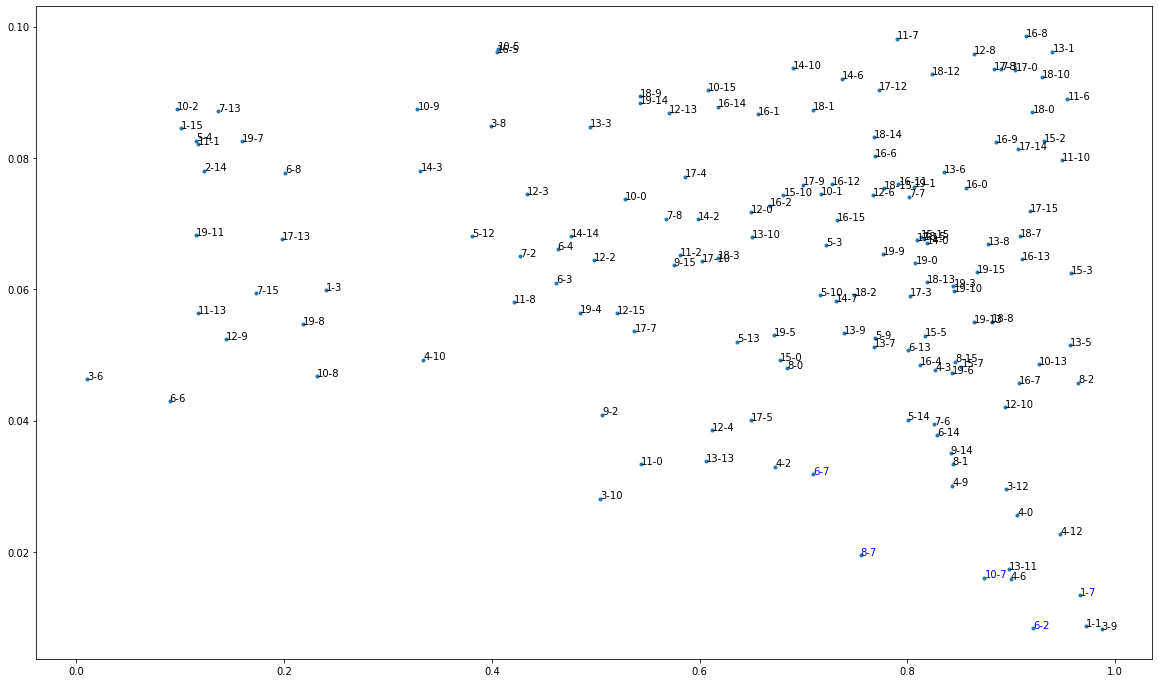

In [2704]:
_ = plt.figure(figsize=(20, 12));
x, y = eigvs.eqke[..., 0], pos_score
mask0 = layer_mask(range(1, 20)) & (y < 0.1) & (x > 0.)
_ = plt.plot(x[mask0], y[mask0], '.')
for l, h in mask0.nonzero().numpy():
    if True or (l, h) in hds.kqovOV: _ = plt.annotate(f'{l}-{h}', (x[l, h], y[l, h]), color='b' if (l, h) in hds.kqovOV else 'k')

In [2733]:
hds.kqOVov  # for ov, 16-7 is good, 11-0 is very good. but for qk, 16-7 is worse than 15-7, 11-0 is the worst!
# 15-7 is bad
# 16-7 is good, kqOVOV composable with 13-11

[(8, 1), (12, 10), (13, 13), (15, 7), (16, 7), (11, 0)]

In [2734]:
# t00, t01, t11 = eigvs.evoove, eigvs.ekqovove, eigvs.eqkkqe
t00, t01, t11 = eigvs.evoove, eigvs.ekqOVove[(15, 5)], eigvs.eqkkqe
# t00, t01, t11 = eigvs.evoove, eigvs.ekqovovove[((l0, h0), (l1, h1))], eigvs.eqkkqe
eigvs4 = small_to_big_pairwise_sim_tensor(t00, t01, t11)
qk_score = [eigvs.eqke[..., 0], eigvs.uovE][1]
l1 = 15
mask[0] = layer_mask(range(2, l1)) #& (pos_score < 0.05) & (eigvs.eqke[...,0] > 0.5)
mask[1] = layer_mask(range(l1 + 1, L)) & (eigvs.uovE > 0.5) & (pos_score < 0.1)
embed_outputs['ekqovove'] = [embed_by_pairwise_sim_tensor(eigvs4[..., i], mask) for i in [0, 1]] + [mask]

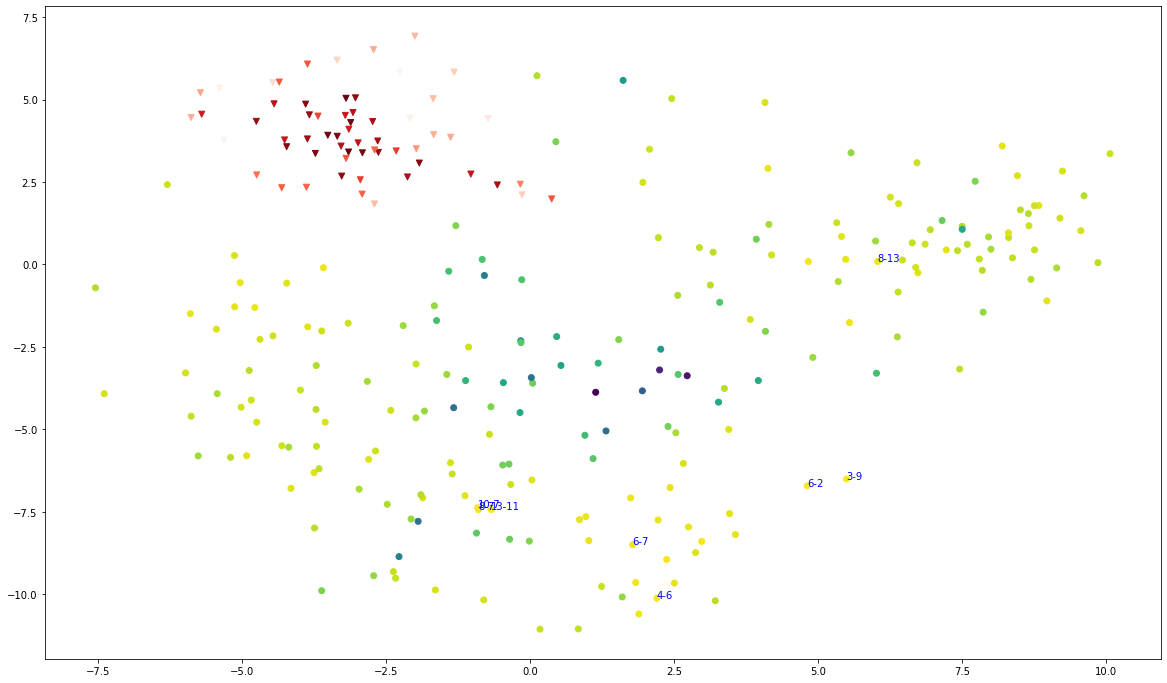

In [2735]:
outputs = embed_outputs['ekqovove']; use_reality = 0
result, mask = outputs[int(use_reality)], outputs[-1]

fig, ax = plt.subplots(figsize=(20, 12))
ov_score = [eigvs.eqke[...,0], pos_score][1]
qk_score = [eigvs.eqke[..., 0], eigvs.uovE, pos_score][1]
_ = plt.scatter(*tuple(result[0, mask[0]].T), marker='o', c=ov_score[mask[0]], cmap='viridis_r')
_ = plt.scatter(*tuple(result[1, mask[1]].T), marker='v', c=qk_score[mask[1]], cmap='Reds')
for l, h in mask[0].nonzero().numpy():
    if (l, h) in hds.kqovOV: _ = ax.annotate(f'{l}-{h}', result[0, l, h], color='b')
# k_comp_heads, same_qk_heads = [(6, 10), (5, 4), (3, 11)], [(8, 7), (6, 2), (1, 7), (6, 7), (8, 13), (10, 7)]  # (4, 0), (3, 9)

In [2530]:
todo_heads = [(18, 5), (19, 6), (18, 13), (14, 6), (19, 1), (17, 1), (19, 0), (17, 9),
              (17, 5), (15, 5), (13, 9)]
# 14-6 bad
# 15-5 strange

In [2558]:
# eigvs4 = small_to_big_pairwise_sim_tensor(eigvs.voov, eigvs.qkov, eigvs.qkkq)
eigvs4 = small_to_big_pairwise_sim_tensor(eigvs.evoove, eigvs.eqkove, eigvs.eqkkqe)
# eigvs4 = small_to_big_pairwise_sim_tensor(eigvs.evoove, eigvs.eqkove, eigvs.eqkkqe)
mask = ov_mask & layer_mask(range(1, 20)) | qk_mask & layer_mask(range(3, 20))
embed_outputs['eqkove'] = [embed_by_pairwise_sim_tensor(eigvs4[..., i], mask) for i in [0, 1]] + [mask]

In [3027]:
[(head, pos_score[head], eigvs.uovE[head], v) for head, v in 
     get_knn(eigvs.eqkove[..., use_reality] * gt_l0_mask, [(10, 4),], topk=10, sim_threshold=0.8).items()]

[((12, 10), tensor(0.0420), tensor(0.9601), 0.9933756),
 ((15, 7), tensor(0.0482), tensor(0.9753), 0.9716811),
 ((17, 5), tensor(0.0401), tensor(0.7289), 0.9611347),
 ((13, 13), tensor(0.0339), tensor(0.9344), 0.9565794),
 ((14, 6), tensor(0.0921), tensor(0.8779), 0.9401148),
 ((26, 13), tensor(0.0497), tensor(0.2504), 0.93656677),
 ((16, 7), tensor(0.0457), tensor(0.9951), 0.9277052),
 ((15, 5), tensor(0.0530), tensor(0.7712), 0.918713),
 ((22, 7), tensor(0.0607), tensor(0.6626), 0.91125286),
 ((13, 0), tensor(0.1552), tensor(0.0315), 0.9055322)]

In [3026]:
l, h = 13, 13; eigvs.uovE[l, h]; add_rows(topk_md(eigvs.eqkove[:, :, l, h, 0], 10), pos_score)

tensor(0.9344)

(array([11,  7, 10, 10, 12, 11,  9,  6, 15,  8]),
 array([11, 11,  4, 11, 12,  5,  5,  1, 13, 12]),
 array([0.9805672 , 0.95725864, 0.9565794 , 0.94977695, 0.9477071 ,
        0.94044596, 0.92341095, 0.91489214, 0.9099381 , 0.8962975 ],
       dtype=float32),
 array([0.3678885 , 0.573958  , 0.9267423 , 0.3241048 , 0.6542016 ,
        0.5387182 , 0.5770337 , 0.37738788, 0.30173954, 0.14588423],
       dtype=float32))

In [3025]:
l, h = 16, 7; eigvs.uovE[l, h]; add_rows(topk_md(eigvs.eqkove[:, :, l, h, 0], 10), pos_score)

tensor(0.9951)

(array([12, 11, 10, 14, 11, 10, 15,  5,  6,  3]),
 array([12, 11, 11,  9, 12,  4, 13,  6,  1,  5]),
 array([0.98865277, 0.96679175, 0.9461144 , 0.94406074, 0.9368196 ,
        0.9277052 , 0.9177019 , 0.91160303, 0.9104574 , 0.89909726],
       dtype=float32),
 array([0.6542016 , 0.3678885 , 0.3241048 , 0.57883555, 0.15507938,
        0.9267423 , 0.30173954, 0.6043932 , 0.37738788, 0.8296661 ],
       dtype=float32))

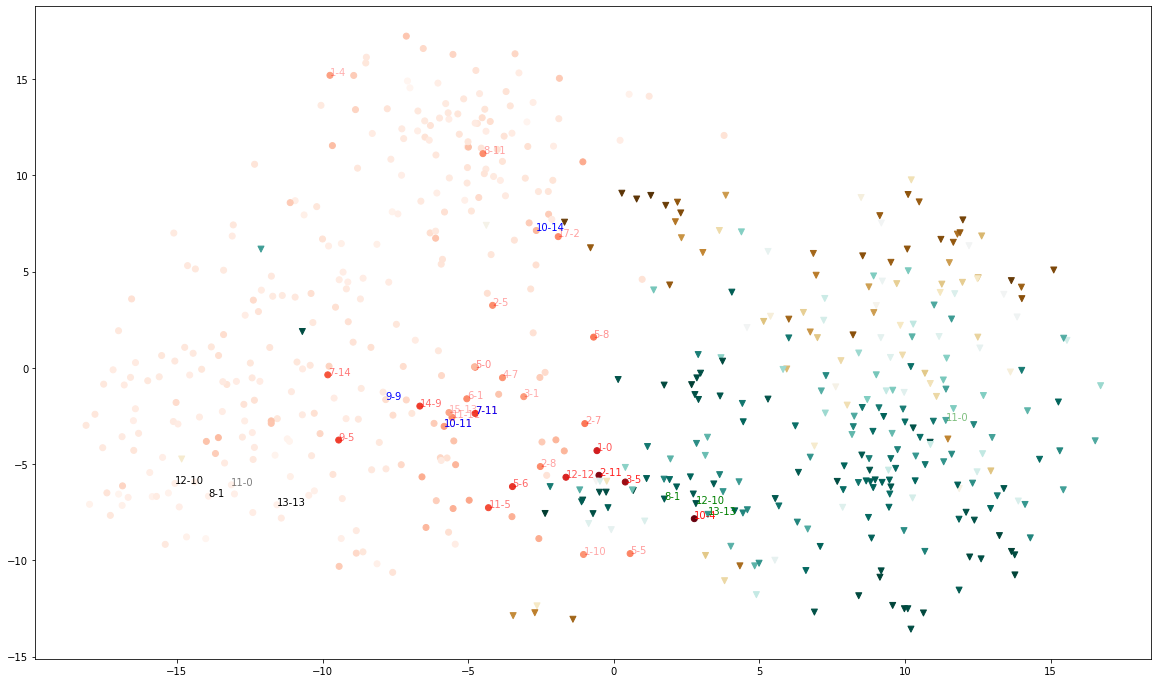

In [2576]:
outputs = embed_outputs['eqkove']; use_reality = 0
result, mask = outputs[int(use_reality)], outputs[-1]

fig, ax = plt.subplots(figsize=(20, 12))
ov_score = [eigvs.uovE, pos_score][1]  # rescale(qk[:, :, 1], 0.4).numpy()
qk_score = eigvs.eqke[..., 0]
_ = plt.scatter(*tuple(result[0, mask[0]].T), marker='o', c=ov_score[mask[0]], cmap='Reds')#  'RdYlBu_r')
_ = plt.scatter(*tuple(result[1, mask[1]].T), marker='v', c=qk_score[mask[1]], cmap='BrBG')
for b, l, h in (mask & (pos_score > 0.3)).nonzero().numpy():
    # if (l, h) not in [(1, 0), (2, 11), (12, 12)]: continue
    if b == 0: _ = ax.annotate(f'{l}-{h}', result[b, l, h], color='r' if b==0 else 'm', alpha=pos_score[l, h].item())
# cond = qk_score > 0.8
# # https://datavizpyr.com/connect-paired-points-with-lines-scatter-plot-matplotlib/
# x, y = zip(result[0][mask[0] & cond].T, result[1][mask[1] & cond].T)
# _=plt.plot(torch.stack(x), torch.stack(y), color='k', alpha=0.2)
# for (l, h), v in list(get_knn(eigvs.eqkove[..., use_reality] * gt_l0_mask, [(10, 4), (2, 11), (3, 5)]).items()) + [((11, 0), 1)]:
#     _ = ax.annotate(f'{l}-{h}', result[1, l, h], color='b', alpha=1 or rescale(v, 0.9))
#     _ = ax.annotate(f'{l}-{h}', result[0, l, h], color='g', alpha=1 or rescale(v, 0.9))
for (l, h) in todo_heads[:0] + hds.kqOVov[:3] + [(11, 0)]:
    alpha = 1 if (l, h) in hds.kqOVov[:3] else 0.5
    _ = ax.annotate(f'{l}-{h}', result[1, l, h], color='g', alpha=alpha)
    _ = ax.annotate(f'{l}-{h}', result[0, l, h], color='k', alpha=alpha)
for (l, h) in [(10, 11), (7, 11), (10, 14), (9, 9)]: _ = ax.annotate(f'{l}-{h}', result[0, l, h], color='b')

In [ ]:
eigvs4 = small_to_big_pairwise_sim_tensor(eigvs.evoove, eigvs.eqkove, eigvs.eqkkqe)
mask = qk_mask & layer_mask(range(3, 16))
result0 = embed_by_pairwise_sim_tensor(eigvs4[..., 0], mask)
result1 = embed_by_pairwise_sim_tensor(eigvs4[..., 1], mask)
embed_outputs['eqkkqe'] = (result0, result1, mask)

In [ ]:
_=plt.hist(qk_score[mask[1]].numpy(), bins=20)

In [ ]:
outputs = embed_outputs['eqkkqe']; use_reality = 0
result, mask = outputs[int(use_reality)], outputs[-1]

fig, ax = plt.subplots(figsize=(20, 12))
qk_score = qk[...,0]
_ = plt.scatter(*tuple(result[1][mask[1]].T), marker='o', c=qk_score[mask[1]], cmap='RdBu_r')
for l, h in heads.KQQK:
    _ = ax.annotate(f'{l}-{h}', result[1, l, h], color='k')

In [ ]:
ws = weightprod(model, [(2, 11), (3, 5)], 'vo ov', return_ws=True)
rws = [torch.randn_like(w) for w in ws]
i = 2; A, B = reduce(torch.matmul, rws[:i]), reduce(torch.matmul, rws[i:])
denorm = A.norm() * B.norm()
(A @ B).norm() / denorm

In [ ]:
top_pos_heads = [(2, 11), (3, 5), (12, 12), (10, 4)]
top_same_qk_heads = [(1, 7), (3, 9), (6, 2), (7, 9), (8, 7), (8, 13)]

In [ ]:
eigvs.qk = compute_eigvs(model, [all_heads_by_layer], 'kq')
eigvs.eqke = compute_eigvs(model, [all_heads_by_layer], 'e kq e', weBTA=weBTAs[0])
eigvs.uovE = eigv_positivity[:, :, 1]

In [ ]:
hds.KQovov = {}

In [ ]:
head2 = (22, 14)
if head2 not in hds.KQovov:
    hds.KQovov[head2] = (eigvs.uovE[head2], torch.Tensor([plot_eigv(prod, plot=False)[0] for _, prod in 
                            iweightprod(model, [hds.kqovOV[:-2], (12, 10), head2], 'e vo vo qk e', weBTA=weBTAs[0])]))
    print(hds.KQovov[head2])

In [3203]:
add_cols(set(hds.KQovov.keys()) - set(KQovov), [eigvs.uovE, pos_score])

[[13, 4, tensor(-0.8382), tensor(0.1067)],
 [16, 10, tensor(0.3291), tensor(0.0871)],
 [16, 14, tensor(-0.3460), tensor(0.0878)],
 [13, 15, tensor(0.8067), tensor(0.1008)],
 [19, 12, tensor(0.9358), tensor(0.1358)],
 [24, 15, tensor(0.4789), tensor(0.0622)]]

## kqovovov

(12, 10)


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


tensor(0.8294)

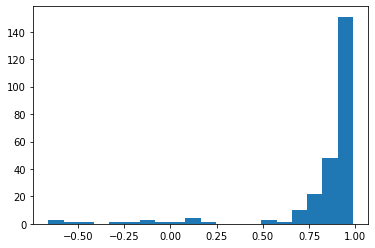

In [3012]:
head1 = hds.kqOVov[1]; print(head1)

KQovov_cond = (eigvs.uovE > 0.6) & (pos_score < 0.1)
KQovov = [tuple(head) for head in (layer_mask(range(head1[0] + 1, L)) & KQovov_cond).nonzero().numpy()]

vs = compute_eigvs(model, [hds.kqovOV[:4], head1, KQovov], 'e vo vo qk e', weBTA=weBTAs[0])[..., 0]
x = vs[vs != 0]; x.mean(); _=plt.hist(x.numpy(), bins=20)

100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


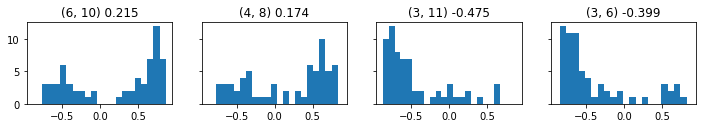

In [3013]:
vs = compute_eigvs(model, [hds.QKov, head1, KQovov], 'e vo vo qk e', weBTA=weBTAs[0])[..., 0]
nrows, ncols = 1, len(hds.QKov); fig, axs = plt.subplots(nrows, ncols, sharey=True, sharex=True, figsize=(12, 1.5))
for i, head in enumerate(hds.QKov):
    # print(head)
    x = vs[head][vs[head] != 0]
    ax = axs[i]
    _=ax.hist(x.numpy(), bins=20); _=ax.set_title(f'{head} {round(x.mean().item(), 3)}')

In [3015]:
head0 = hds.QKov[3]; print(head0)
hds.kqovOV[:4]
torch.Tensor([plot_eigv(prod, plot=False)[0] for head, prod in iweightprod(model, [head0, hds.kqovOV[:4]], 'e vo ov e', weBTA=weBTAs[0])])

(3, 6)


[(8, 7), (6, 2), (6, 7), (10, 7)]

tensor([ 0.8180, -0.1356,  0.8746,  0.7359])

In [3016]:
vs = compute_eigvs(model, [heads_in_layers(0, head0[0]), head0, head1, KQovov], 'e vo vo vo qk e', weBTA=weBTAs[0])[..., 0]

100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


(2, 7) tensor(0.4283) tensor([ 0.9262, -0.5480, -0.7804,  0.8749])
(2, 6) tensor(0.2466) tensor([0.8645, 0.6617, 0.5862, 0.8188])
(2, 15) tensor(0.1175) tensor([ 0.7764, -0.8304, -0.3706,  0.7647])
(1, 4) tensor(0.3150) tensor([-0.5120, -0.1751, -0.8090,  0.6616])
(0, 0) tensor(0.2984) tensor([0.9003, 0.5156, 0.7520, 0.7421])
(2, 9) tensor(0.2042) tensor([ 0.6855,  0.2858, -0.3577,  0.7110])
(1, 5) tensor(0.0535) tensor([ 0.7358, -0.4647,  0.1587,  0.6801])
(0, 7) tensor(0.4213) tensor([-0.8936,  0.4105, -0.7548, -0.8617])
(1, 12) tensor(0.1436) tensor([-0.5772,  0.9153,  0.0203, -0.8904])
(2, 2) tensor(0.1362) tensor([ 0.2106,  0.7240, -0.3803, -0.5852])


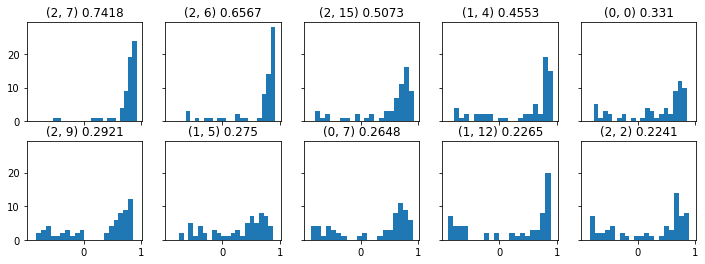

In [3017]:
nrows, ncols = 2, 5; fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12, 4))
for i, head_1 in enumerate(zip(*topk_md(vs.sum(dim=(-2, -1)), 10)[:2])):
    print(head_1, pos_score[head_1],
        torch.Tensor([plot_eigv(prod, plot=False)[0] for head, prod in iweightprod(
            model, [head_1, head0, hds.kqovOV[:4]], 'e vo vo ov e', weBTA=weBTAs[0])]))
    x = vs[head_1][vs[head_1] != 0]
    ax = axs[i // ncols, i % ncols]
    _=ax.hist(x.numpy(), bins=20)
    _=ax.set_title(f'{head_1} {round(x.mean().item(), 4)}')#; plt.show()

## Affinity analysis

In [ ]:
_affinities = torch.zeros((L, L, H, H))
affinities = torch.zeros((L, L, H, H))
for l0 in tqdm(range(0, l1)):
    for l2 in range(l1 + 1, L):
        if True:
        # with Timer(f'layer{l0}-layer{l2}'):
            wv0, wo0 = get_head_weights(model, l0, transpose=True)[2:]
            wq2, wk2 = get_head_weights(model, l2, transpose=True)[:2]
            wv0, wo0, wq2, wk2 = wv0.to('cuda'), wo0.to('cuda'), wq2.to('cuda'), wk2.to('cuda')
            with torch.no_grad():
                a, na = get_affinities3(wv0 @ wo0, _wvo, wq2 @ wk2.transpose(-2, -1))
            a, na = a.to('cpu'), na.to('cpu')
            _affinities[l0, l2] = a.squeeze(1)  # m1o->mo
            affinities[l0, l2] = na.squeeze(1)  # m1o->mo

_affinities, affinities = rearrange(_affinities, 'k l m n -> k m l n'), rearrange(affinities, 'k l m n -> k m l n')
np.savez_compressed(f'affinities{l1}-{h1}.npz', a=_affinities.numpy(), na=affinities.numpy())

In [ ]:
data = np.load(f'affinities{l1}-{h1}.npz')
affinities = torch.Tensor(data['na'])
# topk_md(torch.einsum('kmln->km', affinities), 20)  # klmn->km/ln
# fig, ax = plt.subplots(figsize=(20, 10))
# _ = sns.heatmap(rearrange(affinities[: l1, :, l1 + 1: L], 'l0 h0 l2 h2 -> (l0 h0) (l2 h2)'), ax=ax)

In [ ]:
[(l, h, v, eigv_positivity[l, h]) for l, h, v in zip(*topk_md(torch.einsum('kmln->ln', affinities), 10))]

In [ ]:
[(l, h, v, eigv_positivity[l, h], k_comp_max[l, h]) for l, h, v in zip(*topk_md(torch.einsum('kmln->km', affinities), 20))]

In [ ]:
[((l, h), count, eigv_positivity[l, h]) for (l, h), count in Counter(
    zip(*np.unravel_index(affinities.view(-1).topk(200).indices, affinities.size())[:2])).most_common()]

In [ ]:
for l0, h0, l2, h2 in zip(*np.unravel_index(affinities.view(-1).topk(100).indices, affinities.size())):
    if True: #(l0, h0) == (8, 7) and (l2, h2) == (22, 5):
        wv0, wo0 = get_head_weights(model, l0, h0, transpose=True)[2:]
        wq2, wk2 = get_head_weights(model, l2, h2, transpose=True)[:2]
        q, kT = (wv0 @ wo0 @ wv1 @ wo1 @ wq2), wk2.T
        eigv_pos = plot_eigv((kT @ q).eig()[0], plot=False)
        print(f'{l0}-{h0}, {l2}-{h2}', eigv_pos, eigv_positivity[l2, h2])

In [ ]:
na0 = get_ov_affinities(model, l1, wv1, wo1, range(l1))

In [ ]:
[(i, f'{l0}-{h0}', k_comp_max[l0, h0], eigv_positivity[l0, h0], pos_heads2val.get((l0, h0)))
    for i, (l0, h0) in enumerate(zip(*topk_md(na0, 10)[:2]))]

In [ ]:
n_heads2=40
na2 = get_qk_affinities(model, l1, wv1, wo1, range(l1 + 1, L))
heads2 = list(zip(*topk_md(na2, n_heads2)[:2]))
# heads2 = [(3, 11), (8, 1), (12, 10), (13, 13), (14, 6), (15, 7), (16, 7)]
# heads2 = [(13, 2), (14, 6), (16, 6)]

In [ ]:
for l0, h0 in heads0:
    wq0, wk0 = get_head_weights(model, l0, h0, transpose=True)[:2]
    ln0 = blocks[l0].ln_1
    print(l0, h0, eigv_positivity[l0, h0], get_eigv_pos(wk0.T @ wq0), get_eigv_pos((_e[1] @ wk0).T @ (_e[1] @ wq0)), get_eigv_pos((ln0(_e[1]) @ wk0).T @ (ln0(_e[1]) @ wq0)))

In [ ]:
add_attr(topk_md(na0, 100, zipped=True), [eigv_positivity_noln[:, :, [0, 2]], pos_score, k_comp_wmean])

In [ ]:
# n_heads0=20
# na0 = get_qk_affinities(model, l1, wv1, wo1, range(l1 + 1, L))
# na0 = get_ov_affinities(model, l1, wv1, wo1, range(l1))
# heads0 = list(zip(*topk_md(na0, n_heads0)[:2]))
heads0 = [(3, 6), (3, 11), (4, 8), (6, 10)]
# heads0 = [(4, 1), (6, 15), (8, 13), (10, 1)]  # eigv_pos012 < -0.8
# heads0 = [(3, 6), (3, 12), (4, 6), (4, 0), (6, 10), (8, 1)] # k_comp_wmean > 0.2
# heads0 = [(1, 7), (3, 9), (6, 2), (6, 7), (8, 7), (10, 7)] # k_comp_wmean < 0.2 and eigv_pos > 0, i.e. the good ones
heads2 = [(13, 2), (14, 6)]

In [ ]:
eigv_pos012 = compute_eigv_pos012(model, l1, h1, wv1, wo1, heads0, heads2,
    eigv_positivity, heads_1=None, use_ln=True, _e=_e[0], verbose=True)

In [ ]:
del compute_eigv_pos012
from model_utils import compute_eigv_pos012

In [ ]:
eigv_pos012 = compute_eigv_pos012(model, l1, h1, wv1, wo1, [(6, 10)], heads2,
    eigv_positivity, heads_1=[(5, 1)], use_ln=True, _e=_e[0], verbose=True)

In [ ]:
l1, h1 = 12, 10; wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]

In [ ]:
add_attr([(l0, h0, l2, h2, torch.Tensor(eigv_pos)) for (l0, h0, l2, h2), eigv_pos in eigv_positivity012[l1, h1].items()
    if pos_score[l0, h0] < 0.2 and k_comp_wmean_ln[l0, h0] > 0.2], eigv_positivity_noln)

In [ ]:
x, y = zip(*[(eigv_pos[1], pos_score[l0, h0]) for (l0, h0, l2, h2), eigv_pos in eigv_positivity012[l1, h1].items()
    if pos_score[l0, h0] < 0.045 and k_comp_wmean_ln[l0, h0] < 0.2])
_ = plt.figure(figsize=(20, 10)); _ = plt.scatter(x, y, marker='.', alpha=0.3)

In [ ]:
_ = plt.hist(x, bins=20)

In [ ]:
n_intermediary_heads = 100
# n_heads0, n_heads2 = 20, 40  # gpt2-large
# n_heads0, n_heads2 = 15, 30  # gpt-j
n_heads0, n_heads2 = 100, 40  # gpt-j
# eigv_positivity012 = {}
# maybe_intermediary_heads = list(zip(*topk_md(k_comp_max, n_intermediary_heads)[:2]))
# maybe_intermediary_heads = [(l1, h1) for l1, h1 in maybe_intermediary_heads if 0 < l1 < L - 1]
maybe_intermediary_heads = [(12, 10)] # [(8, 1), (13, 13)]
# maybe_intermediary_heads = list(zip(*topk_md(conductivity, 20)[:2]))
for l1, h1 in (maybe_intermediary_heads):
    wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
    na0 = get_ov_affinities(model, l1, wv1, wo1, range(l1))
    heads0 = list(zip(*topk_md(na0, n_heads0)[:2]))
    na2 = get_qk_affinities(model, l1, wv1, wo1, range(l1 + 1, L))
    heads2 = list(zip(*topk_md(na2, n_heads2)[:2]))
    eigv_pos012 = compute_eigv_pos012(model, l1, h1, wv1, wo1, heads0, heads2, 
        eigv_positivity, use_ln=True, _e=_e[0], verbose=False)
    eigv_positivity012[l1, h1] = eigv_pos012

In [ ]:
eigv_positivity012_ln = eigv_positivity012

In [ ]:
# with gzip.open(f'eigv_positivity012_{model_name.split("/")[-1]}.pkl.gz', 'wb') as f:
#     pickle.dump(eigv_positivity012, f)
with gzip.open(f'eigv_positivity012_{model_name.split("/")[-1]}.pkl.gz', 'rb') as f:
    eigv_positivity012 = pickle.load(f)

In [ ]:
conductivity = torch.zeros(L, H)
for l, h in eigv_positivity012:
    conductivity[l, h] = get_conductivity(eigv_positivity012, l, h)

In [ ]:
names, affinity_val, eigv_pos_ov, k_comp = zip(*[(f'{l}-{h}', v, eigv_positivity[l, h, 1].item(), k_comp_max[l, h].item()) 
        for l, h, v in zip(*topk_md(na2, 50))])
# plt.figure(figsize=(16, 10))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.scatter(x=eigv_pos_ov, y=k_comp, marker='.', alpha=affinity_val)

## Positional heads & K-compositions

In [ ]:
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.scatter(x=eigv_positivity[:, :, 1].view(-1), y=k_comp_max.view(-1), marker='.')#, alpha=affinity_val)

In [966]:
pos_score = get_positional_score(model)

In [ ]:
positional_heads = topk_md(pos_score, 60, zipped=True) # 60 for gpt-j
positional_heads = sorted(positional_heads, key=lambda x: x[-1], reverse=True)  # sorted by value
positional_heads = sorted(positional_heads, key=lambda x: x[0]) # then by layer
positional_heads
pos_heads2val = OrderedDict(((l, h), v) for l, h, v in positional_heads)

In [ ]:
for l, h, v in sorted(positional_heads, key=lambda x: x[-1], reverse=True):
    wv, wo = get_head_weights(model, l, h, transpose=True)[2:]
    print(f'{l}-{h}', v, eigv_positivity[l, h], get_eigv_pos(wo @ wv))

In [ ]:
l1, h1 = 12, 10; wv1, wo1 = get_head_weights(model, l1, h1, transpose=False)[2:]

In [ ]:
# all_heads = [(l, h) for l in range(l1//2, l1) for h in range(H)]
heads0 = [(l, h) for l, h, _ in positional_heads]
# heads0 = set(all_heads) - set(heads0)

In [ ]:
wvs0, wos0 = zip(*[get_head_weights(model, l, h, transpose=True)[2:] for l, h in heads0])
wvs0 = rearrange(list(wvs0), 'b e d -> b e d')
wos0 = rearrange(list(wos0), 'b d e -> b d e')
# heads0_outputs = rearrange([blocks[l].ln_1(_e[1]) for l, _ in heads0], 'b v e -> b v e')
heads0_outputs = rearrange([_e[0] for l, _ in heads0], 'b v e -> b v e')
heads0_outputs = heads0_outputs @ wvs0 @ wos0  # bve,bed,bde->bve

In [ ]:
k_compositions = torch.zeros(L, H, len(heads0))
for l1 in tqdm(range(L)):
    # ln_e = blocks[l1].ln_1(_e[1])
    # ln_heads0_outputs = blocks[l1].ln_1(heads0_outputs)
    ln_e = _e[0]
    ln_heads0_outputs = heads0_outputs
    for h1 in range(H):
        if l1 == 0:
            eigv_pos = [0. for _ in range(len(heads0))]
        else:
            wq1, wk1, wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)
            q = ln_e @ wq1
            k = ln_heads0_outputs @ wk1
            M = k.transpose(-2, -1) @ q   # bdv,vd->bdd
            eigv_pos = [get_eigv_pos(m) for m in M]
            eigv_pos = [ep if l < l1 else 0. for ep, (l, _) in zip(eigv_pos, heads0)]
        k_compositions[l1, h1] = torch.Tensor(eigv_pos)

In [ ]:
plot_k_comp([(3, 11), (4, 8), (6, 10), (12, 10)], k_compositions_noln, pos_heads2val)

In [ ]:
heads = [all_heads, all_heads]
get_l1_start = lambda l: 0
pattern, weBTA = 'vo kq', None
# pattern, weBTA = 'e vo kq e', weBTAs[0]
# pattern, weBTA = 'E vo kq E', weBTAs[1]
with torch.no_grad(): _eigvs = compute_eigvs(model, heads, pattern, weBTA=weBTA, get_l1_start=get_l1_start)
rpattern = pattern.replace(' ', '')[::-1]
np.savez_compressed(f'{model_name.split("/")[-1]}/eigvs_{rpattern}.npz', d=_eigvs.half())
eigvs[rpattern] = _eigvs

In [ ]:
l1, h1 = 8, 7
# l1, h1 = 6, 2
_eigvs = compute_eigvs(model, [(l1, h1), k_comp_heads, all_heads], 'e vo ov ov e', weBTA=weBTAs[0], l1_range_fn=lambda l0: range(0, l0))

In [ ]:
plot_eigv(weightprod(model, [(6, 7), (6, 2)], 'e vo ov e', weBTA=weBTAs[0]), start_i=1)

In [ ]:
l0, h0 = 4, 8
eigvs.evoove[l0, h0, l1, h1]
add_rows(topk_md(_eigvs[l0, h0, :, :, 0], 5), pos_score)

In [ ]:
eigvs = Eigovs()
for pattern in ['voov', 'qkkq', 'qkov']:
    for we_str in ['', 'e', 'E']:
        _pattern = we_str + pattern + we_str
        setattr(eigvs, _pattern, torch.Tensor(np.load(f'{model_name.split("/")[-1]}/eigvs_{_pattern}.npz')['d']))

In [ ]:
rpattern = 'qkkq'
# rpattern = 'voov'
# rpattern = 'qkov'
_eigvs = torch.Tensor(np.load(f'{model_name.split("/")[-1]}/eigvs_{rpattern + "_fro"}.npz')['d'])
if rpattern == rpattern[::-1]: _eigvs = complete_tril(_eigvs)
setattr(eigvs, rpattern + '_fro', _eigvs)

In [ ]:
# plt.figure(figsize=(20,10))
x, y = eigvs.qkov[..., 0].view(-1), eigvs.qkov_fro[..., 0].view(-1)
# x, y = x[x ]
_ = plt.hist(x.numpy(), bins=40); plt.show()
_ = plt.hist(y.numpy(), bins=40); plt.show()
_ = plt.scatter(x, y, '.', alpha=0.05); plt.show()

In [2595]:
rpattern = 'ekqOVove'
if not hasattr(eigvs, rpattern): setattr(eigvs, rpattern, {})
for l, h in todo_heads + [(12, 10)]:
# for l, h in hds.kqOVov:
#     if (l, h) not in [(11, 0)]: continue
    getattr(eigvs, rpattern)[(l, h)] = torch.Tensor(np.load(f'{model_name.split("/")[-1]}/eigvs_{rpattern}_{l}-{h}.npz')['d'])
# rpattern = 'ekqovovove'
# if not hasattr(eigvs, rpattern): setattr(eigvs, rpattern, {})
# l1, h1 = 12, 10
# for (l0, h0) in [(3, 11), (6, 10)]:
#     key = ((l0, h0), (l1, h1))
#     if key not in getattr(eigvs, rpattern):
#         getattr(eigvs, rpattern)[key] = torch.Tensor(np.load(f'{model_name.split("/")[-1]}/eigvs_{rpattern}_{l0}-{h0}_{l1}-{h1}.npz')['d'])

In [ ]:
u = q @ v.T[0]
show_topk(*u.topk(40, largest=True), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
def get_pos_head_idx(l0, h0):
    i= None
    for i, (l, h, _) in  enumerate(positional_heads):
        if (l, h) == (l0, h0): return i

In [ ]:
np.savez_compressed(f'k_compositions_noln_{model_name.split("/")[-1]}.npz', k_compositions=np.array(k_compositions), positional_heads=positional_heads)

In [ ]:
# d = np.load(f"k_compositions_{model_name.split('/')[-1]}.npz")
# k_compositions, positional_heads = torch.Tensor(d['k_compositions']), d['positional_heads']
# k_compositions[k_compositions == -1] = 0
# k_comp_max = k_compositions.max(-1)[0]
# positional_heads = [[int(l), int(h), v] for l, h, v in positional_heads]
# pos_heads2val = OrderedDict(((l, h), v) for l, h, v in positional_heads)
k_comp_wmean = torch.einsum('lnk,k->ln', k_compositions, torch.Tensor(list(pos_heads2val.values()))) / \
    ((k_compositions != 0).sum(-1) + 1e-9)

In [961]:
# eigv_positivity_noln = compute_eigv_positivity(model, L, H, use_ln=False)
# np.savez(f'eigv_positivity_noln_{model_name.split("/")[-1]}.npz', a=eigv_positivity_noln.numpy())
data = np.load(f"eigv_positivity_{model_name.split('/')[-1]}.npz")
eigv_positivity_ov, eigv_positivity_qk = torch.Tensor(data['ov']), torch.Tensor(data['qk'])
eigv_positivity = rearrange([torch.Tensor(data['qk']), torch.Tensor(data['ov'])], 'k l n -> l n k') # k=2

## Interpret QK/OV circuits

In [ ]:
p = wp.size(1) #// 2  # 1024
_wp = wp[:, :p]
_p = mlp(_wp.T) + _wp.T

In [ ]:
layer, head = 13, 10
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
with torch.no_grad():
    eq = ek = e = blocks[layer].ln_1(_p)
    q, k = eq @ wq, ek @ wk
    m = q @ k.T
m.diagonal(offset=-1).mean()

In [ ]:
l0, h0 = 16, 2; wv0, wo0 = get_head_weights(model, l0, h0, transpose=False)[2:]
l1, h1 = 19, 11; wv1, wo1 = get_head_weights(model, l1, h1, transpose=False)[2:]
l2, h2 = 27, 17; wq2, wk2 = get_head_weights(model, l2, h2, transpose=False)[:2]

In [ ]:
ln0 = blocks[l0].ln_1; ln1 = blocks[l1].ln_1; ln2 = blocks[l2].ln_1

In [ ]:
ln0 = ln1 = ln2 = lambda x: x

In [ ]:
with torch.no_grad():
    q = wq2 @ T(ln2)(wo1 @ wv1 @ T(ln1)(wo0 @ wv0 @ T(ln0)(_e.T)))
    k = wk2 @ T(ln2)(_e.T)
    _m = q.T @ k

In [ ]:
# 看head+mlp[0]的ov circuit所作的变换, 2-gram ov 15-3, NE (esp. places) qk 4-4, x->num qk 6-15
# prev ov: 13-9, next num ov: 14-13, next word ov: 13-4, prepend space ov: 18-3/17-10, isa ov: 14-7, antonym ov: 16-14, copy ov 13-2
# NE qk 6-9 who also has copy-like ov
# subword num->whole word num qk and suffix token copy ov 3-6
# 4-3: lower-layer 8-1 12-10 like head
# 10-4: x->adv ov, e.g. including, resulting, subsequently, therefore
# 8-13: place NE qk
# **8-7: coref resolution qk, also very interesting ov
# 6-2: same qk
# 10-7: copy and next fused ov
# 4-1: num, name and place qk
# 24-11: copy ov, esp. num, prepend space
# 22-14: suffix token copy ov
# 21-8: copy ov, 1st letter to upper
# 22-5: copy ov, prepend space, 1st letter to lower, to original form
# 23-2: prefix token copy ov, prepend space, 1st letter to lower
# 3-9: subword->whole word qk for word completion
# 8-2: same qk; 7-9 year and place qk; 7-2 type->instance qk, dual to isa ov 14-7, can be used for coref resolution
# 7-14: x->NE qk; 6-1: x->adv/adj qk; 6-0: x->noun qk; special token and symbol qk 1-7
# next num qk 3-12 (work with prev ov), + 2-11 = same qk!; x->suffix qk 7-6 + 2-11
# prev word+num qk 3-3 (work with next ov), general qk 3-11
layer, head = 3, 12
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
# layer0, head0 = 8, 7; wv0, wo0 = get_head_weights(model, layer0, head0, transpose=True)[2:]
# if layer0 is not None: ek = blocks[layer].ln_1(blocks[layer0].ln_1(_e) @ wv0 @ wo0)

with torch.no_grad():
    ln = lambda x: x #blocks[layer].ln_1
    e = ln(_e[0])
    eq = ek = ln(_e[0])
    # A, B = _wu, ln_f(e @ wv @ wo)
    A, B = _wu @ wo.T, e @ wv
    q, k = eq @ wq, ek @ wk

In [ ]:
qk = True
with torch.no_grad():  # ve,ed,de,ev->vv
    # _m = ln(mlp(_we.T)) @ (wq.T @ wk) @ T(ln)(T(mlp)(_we)) if qk else _wu @ T(ln_f)(wo @ (wv @ T(ln)(T(mlp)(_we))))
    _m = q @ k.T if qk else _wu @ ln_f(B @ wo).T

In [ ]:
plot_eigv((k.T @ q).eig()[0] if qk else (B.T @ A).eig()[0], start_i=0)

In [ ]:
m = _m  # q->k, output->input
# m = _m.T  # k->q, input->output
values, indices = m.topk(25, largest=True)

In [ ]:
indices_fn = tokenizer.convert_ids_to_tokens
# indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)
# show_topk.indices_fn = tokenizer.convert_ids_to_tokens
# show_topk.indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)
for i in values.abs().mean(1).topk(500).indices.tolist():
    print(indices_fn(i), show_topk(values[i][:6], indices[i][:6], indices_fn=indices_fn))

In [ ]:
i = tokenizer.encode(' nobody')[0]; print(tokenizer.convert_ids_to_tokens(i))
show_topk(*m[i].topk(10))

## Attribution

In [ ]:
nrows = 1; k_shot = 0
# text = 'The Space Needle is in the city of Seattle.'
# text = 'Megan Rapinoe plays the sport of soccer.'
text = 'When Mary and John went to the store, John gave a drink to Mary.'
input_ids = data_tuples[0][1]
attn_mask = torch.ones(input_ids.size(1), input_ids.size(1)) * (-1e9)
attn_mask[:, [1, 3]] = 0
attn_mask = attn_mask.tril()
data_tuples = [predict(model, tokenizer, text, None, k_shot=k_shot, bos_token='Ġto', eos_token=None)]

 Ġclothing 0.0 {'Ġtrousers': 0.191, 'Ġpants': 0.057, 'Ġmother': 0.047} 	 Jessica has a dagger. Bear has a train. Sarah has a pair of trousers. Sarah's clothing
 Ġanimal 0.0 {'Ġclothing': 0.586, 'Ġclothes': 0.053, 'Ġfurniture': 0.024} 	 Andy has a deer. Hope has a spanner. Patrick has a desk. Andy's animal
 Ġappliance 0.001 {'Ġanimal': 0.253, 'Ċ': 0.17, 'Ġfruit': 0.057} 	 Clark has a washer. Jessica has a tractor. Winter has a mango. Clark's appliance
 Ġvehicle 0.037 {'Ġfruit': 0.272, 'Ġanimal': 0.044, 'Ġvehicle': 0.037} 	 India has an airplane. Jane has a horse. June has a banana. India's vehicle
 Ġflower 0.04 {'Ġplant': 0.09, 'Ġobject': 0.066, 'Ġfruit': 0.053} 	 Anna has a tulip. Jack has a strawberry. Jessica has an ant. Anna's flower
*Ġfruit 0.451 {'Ġfruit': 0.451, 'Ġplant': 0.089, 'Ġinsect': 0.044} 	 Forest has a monkey. Jake has a lime. Charlie has a mosquito. Jake's fruit
*Ġfruit 0.209 {'Ġfruit': 0.209, 'Ġplant': 0.132, 'Ġfood': 0.073} 	 Graham has a bear. Ari has a bee. Jack has

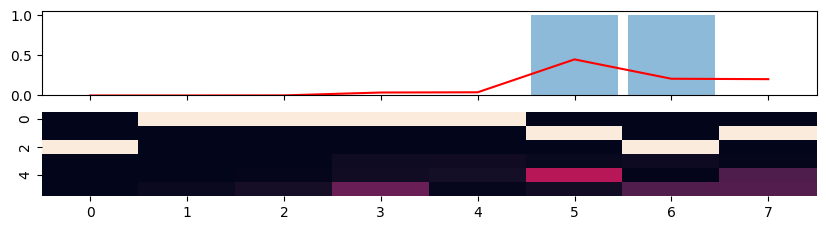

 Ġtool 0.001 {'Ġshovel': 0.107, 'Ġsister': 0.063, 'Ġbeetle': 0.061} 	 Joy has a beetle. Sarah has a lemon. Bear has a shovel. Bear's tool
 Ġtool 0.313 {'Ċ': 0.619, 'Ġtool': 0.313, 'Ġtools': 0.009} 	 Jennifer has a grenade. Miller has a lime. Phoenix has a awl. Phoenix's tool
 Ġclothing 0.001 {'Ġtool': 0.786, 'Ġhorse': 0.086, 'Ċ': 0.03} 	 Steven has a papaya. Mario has a shirt. Gary has a horse. Mario's clothing
 Ġappliance 0.003 {'Ċ': 0.503, 'Ġfurniture': 0.075, 'Ġclothing': 0.027} 	 Kelly has a washing machine. Amy has a bee. Dream has a couch. Kelly's appliance
 Ġinsect 0.001 {'Ġanimal': 0.21, 'Ġclothing': 0.098, 'Ġaccessory': 0.055} 	 Warren has an ant. Kate has a papaya. Roman has a zebra. Warren's insect
 Ġflower 0.066 {'Ġappliance': 0.122, 'Ċ': 0.105, 'Ġflower': 0.066} 	 Jay has a mango. Robin has a washing machine. Morgan has a daisy. Morgan's flower
 Ġanimal 0.053 {'Ġgarment': 0.153, 'Ġclothing': 0.131, 'Ġaccessory': 0.124} 	 Albert has an orange. Grey has a goose. James has a 

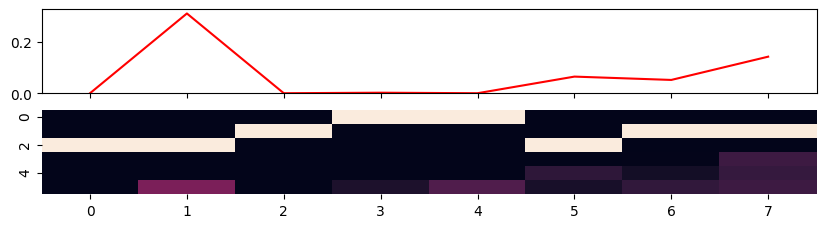

 Ġweapon 0.001 {'Ġmonkey': 0.31, 'Ġgrape': 0.06, 'Ġbomb': 0.045} 	 Mac has a monkey. Steven has a bomb. Ari has a grape. Steven's weapon
 Ġfruit 0.0 {'Ċ': 0.619, 'Ġweapon': 0.314, 'Ġis': 0.003} 	 Christian has a peach. Carter has a car. Laura has a sofa. Christian's fruit
 Ġfurniture 0.0 {'Ċ': 0.847, 'Ġfruit': 0.079, 'Ġweapon': 0.021} 	 Adam has a pair of pants. Justice has a bed. Laura has a cherry. Justice's furniture
 Ġclothing 0.051 {'Ġdress': 0.108, 'Ġclothes': 0.064, 'Ġclothing': 0.051} 	 June has a dress. Mario has a carriage. Elsa has a bus. June's clothing
*Ġflower 0.073 {'Ġflower': 0.073, 'Ġfurniture': 0.064, 'Ċ': 0.061} 	 Charlie has an apricot. Edward has a helicopter. Carter has a daisy. Carter's flower
*Ġfurniture 0.542 {'Ġfurniture': 0.542, 'Ġbed': 0.079, 'Ġmattress': 0.028} 	 Taylor has a durian. Andy has a kangaroo. August has a bed. August's furniture
 Ġanimal 0.173 {'Ġpet': 0.246, 'Ġanimal': 0.173, 'Ġtoy': 0.062} 	 Crystal has a strawberry. Dallas has a sofa. Charles

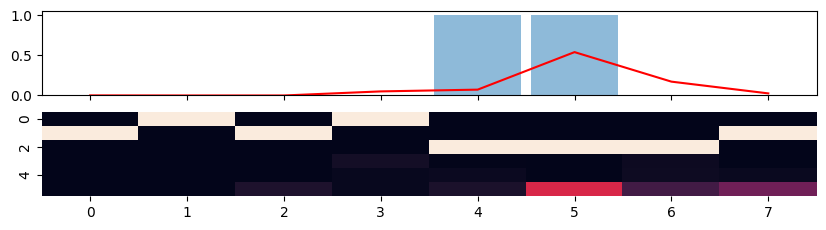

In [80]:
if model_name == 'EleutherAI/gpt-neox-20b': model, _ = models[model_name] # switch back from cpu to gpu model
data_tuples = [predict(model, tokenizer, text, examples, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)[0]
    for text, examples in zip(texts, all_examples)]

In [68]:
topk_md(get_head_matching_scores(data_tuples, 'bos->ans0]', k_shot=k_shot), 10)

(array([13, 11, 20, 15, 16, 15, 17,  9, 10, 13]),
 array([ 7,  9,  5, 15, 15,  8,  9,  0,  3,  2]),
 array([0.18072732, 0.15982012, 0.15066226, 0.11485373, 0.11096672,
        0.10722838, 0.09877288, 0.09826813, 0.08932344, 0.07760217],
       dtype=float32))

In [ ]:
top_heads = topk_md(attn_mll, 1, transpose=True)#[2:4]
for l, h, v in top_heads:
    print(l, h, v)
    for text, input_ids, labels, ranges, *args, o, attn_attr in data_tuples:
        print(text[:10])
        aw = o.attentions[l][0, h]
        bos_indices = args[1]; ystart = bos_indices[k_shot]; ystop = aw.size(0)
        tokens = [t.replace('Ġ', '').replace('Ċ', '-'*12) for t in tokenizer.convert_ids_to_tokens(input_ids[0])]
        plot_attn(aw, tokens, ystart=None, ystop=None, topk=int(len(ranges) * 1.5),
            figsize=(20, 20), fontsize=9, transpose=True, use_imshow=False)
        plt.show()

In [83]:
si = -1
attribute_k = False
root = node = Node('[-1] root'); node.data = AttrData(step=si)
nodes = {}; nodes[si] = node; print_tree(root)

 [-1] root


In [592]:
# 查看当前父节点的信息
# si = 0
parent = nodes[si]#.parent.children[0]
print(parent.name)
attr = parent.data.attr
topk_md(attr.head, 10) # list(zip(*topk_md(attr.head, 10)))
topk_md(attr.mlp, 5) # list(zip(*topk_md(attr.mlp, 5)))

[-1] root


(array([ 9,  9, 10, 11, 10,  9, 11, 10, 11, 10]),
 array([ 6,  9,  0,  1,  2,  8,  2, 10,  3,  1]),
 array([1.6213511 , 1.392967  , 1.1210587 , 1.0349882 , 1.0031589 ,
        0.9165508 , 0.7543835 , 0.67497045, 0.55150944, 0.38160044],
       dtype=float32))

(array([10,  8, 11,  7,  5]),
 array([0.68378955, 0.68123186, 0.4735209 , 0.18533467, 0.08372677],
       dtype=float32))

In [593]:
# 选择下一步要归因的head/mlp，创建节点数据
topk = [0, 1, 2]
# layer, head = list(zip(*topk_md(attr.head, 10)[:2]))[topk]
layer, head = np.array(list(zip(*topk_md(attr.head, 10)[:2])))[topk].T
# layer, head = list(zip(*topk_md(attr.mlp, 10)))[topk][0], None
label_type = [None, 'labels', 'argmax_labels', 'argmax_attn_labels', 'attn_labels'][-1]
attribute_k = False
if si == -1: assert label_type is not None # in ['labels', 'argmax_labels', 'argmax_attn_labels', 'attn_labels']
else: label_type = None
data = AttrData(step=si + 1, topk=topk, layer=layer, head=head, label_type=label_type, 
    attribute_k=label_type in ['argmax_attn_labels', 'attn_labels'] and attribute_k)
print(data2str(data))

[0] top[0, 1, 2] 9-6,9-9,10-0 attn_labels


In [594]:
# 创建节点添加到树，并作为当前父节点
si += 1
node = Node(data2str(data), parent); node.data = data; nodes[si] = node
print([dt[0] for dt in data_tuples], k_shot)
nodes[si].name = '*' + nodes[si].name
print_tree(root)
nodes[si].name = nodes[si].name[1:]  # strip prepending '*'

['When Mary and John went to the store, John gave a drink to Mary.'] 0
 [-1] root┐
          └*[0] top[0, 1, 2] 9-6,9-9,10-0 attn_labels


In [395]:
if model_name == 'EleutherAI/gpt-neox-20b': model, _ = models[model_name + '/cpu']

In [ ]:
if getattr(result, 'root', None) is None:
    si = -1
    root = node = Node('[-1] root'); node.data = AttrData(step=si)
    nodes = {}; nodes[si] = node; print_tree(root)
    result.root = root; result.node = node

attn_patterns = ['bos->[ans0', 'bos->ans0]']
scores = {ap: reduce_objects([get_head_matching_scores(dt, ap) for dt in data_tuples]) for ap in attn_patterns}
node, root = result.node, result.root
attr = reduce_objects([attribute_step(model, dt, node, root) for dt in data_tuples], fields=['head', 'mlp'])
plot_attr(attr, attr)
topk_md(a, 10)
# pd.concat([to_df(*topk_md(a, 10))
#     for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
node.data.attr = attr; node.data.scores = scores

sum_forward ... done 0:00:03.081637
grad ... done 0:00:04.826203
sum_forward ... done 0:00:03.920159
grad ... done 0:00:04.350459
sum_forward ... done 0:00:04.118529
grad ... done 0:00:04.996778
attribution step -1 results


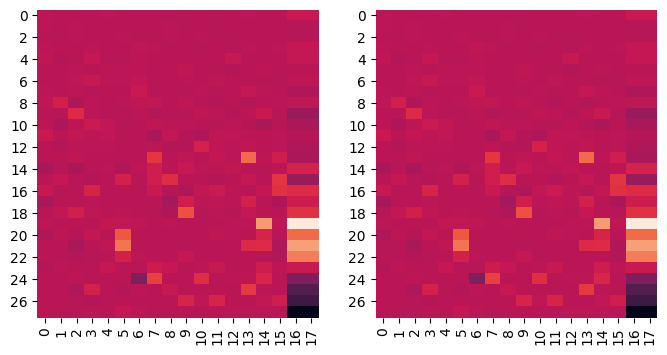

,0,1,2,0,1,2,0,1,0,1
0,19,14,0.748711,19,14,0.748711,19,1.193781,19,1.193781
1,21,5,0.548801,21,5,0.548801,21,0.763456,21,0.763456
2,13,13,0.507810,13,13,0.507810,22,0.596792,22,0.596792
3,20,5,0.425523,20,5,0.425523,20,0.510878,20,0.510878
4,18,9,0.386884,18,9,0.386884,18,0.244268,18,0.244268
5,24,7,0.306191,24,7,0.306191,16,0.203594,16,0.203594
6,25,13,0.285172,25,13,0.285172,14,0.159166,14,0.159166
7,13,7,0.268154,13,7,0.268154,17,0.099380,17,0.099380
8,15,15,0.258497,15,15,0.258497,0,0.077222,0,0.077222
9,16,15,0.239112,16,15,0.239112,23,0.073371,23,0.073371


In [84]:
attrs, attrs2 = [], []#; node = nodes[si]
for text, input_ids, labels, ranges, *_, o in data_tuples:
    fns = path2fns(node, root, partial(node2fn, model=model, outputs=o, labels=labels))
    (output_layer, _labels) = (node.data.layer, None) if len(fns) > 0 else (L, labels)
    to_layer = max(output_layer) if isinstance(output_layer, Iterable) else output_layer
    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, output_layer=output_layer)
    keys = ['embed_mask', 'mlp_mask', 'attn_weights']
    x = OrderedDict((key, get_x(key, o, to_layer=to_layer)) for key in keys)
    # _labels = get_argmax_labels(model, o.hidden_states[-2], _labels)
    attr, ys, logits = attribute(fwd_fn, model, x, fns, num_points=4 if attribute_k else 7) 
    # fwd_fn = partial(sum_forward, outputs=o, labels=_labels, reduce_fn=torch.cat, scaled=False)
    attr2 = attr #attribute2(fwd_fn, model, x, fns)

    attrs.append(attr); attrs2.append(attr2)
    o.attn_attr[node.name] = attr.attn # associate non-averageable attn attr to current node. tricky
        
print(f'attribution step {si} results')
attr = reduce_objects(attrs, ['head', 'neuron', 'mlp']); attr2 = reduce_objects(attrs2, ['head', 'mlp'])
plot_attr(attr, attr2)
pd.concat([to_df(*topk_md(a[: to_layer], min(to_layer, 10)))
    for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
node.data.attr = attr

13 7 0
sum_forward ... done 0:00:00.431650
tensor([-10.8530,  -6.5836,  -5.1183,  -6.1446])
*Ġclothing 0.047 {'Ġclothing': 0.047, 'ĠWomen': 0.037, 'ĠFemale': 0.031, 'ĠWoman': 0.023} 	 Kelly rifle, Maria pants, Robin table. Maria -> clothing
 Ġinsect 0.066 {'Ġspiders': 0.8, 'Ġinsect': 0.066, 'Ġinsects': 0.065, 'Ġspider': 0.036} 	 London pliers, Johnny grape, Andy spider. Andy -> insect
 Ġappliance 0.001 {'Ġtoddler': 0.05, 'Ġmalls': 0.05, 'Ġwheel': 0.043, 'Ġshopping': 0.039} 	 Jon fox, Madison microwave, King duck. Madison -> appliance
*Ġinsect 0.412 {'Ġinsect': 0.412, 'Ġinsects': 0.196, 'Ġmosquitoes': 0.114, 'Ġmosquit': 0.08} 	 Angel mosquito, Roman tie, Adam ship. Angel -> insect
 Ġflower 0.0 {'Ġplush': 0.509, 'Ġamenities': 0.13, 'Ġdesserts': 0.021, 'Ġfurniture': 0.013} 	 Paris giraffe, Cal daisy, Roman sofa. Cal -> flower
*Ġinsect 0.541 {'Ġinsect': 0.541, 'Ġinsects': 0.264, 'Ġvenom': 0.102, 'ĠInsect': 0.062} 	 Rachel cherry, Jon sheep, Jay wasp. Jay -> insect
 Ġtool 0.0 {'Ġfemale': 0.

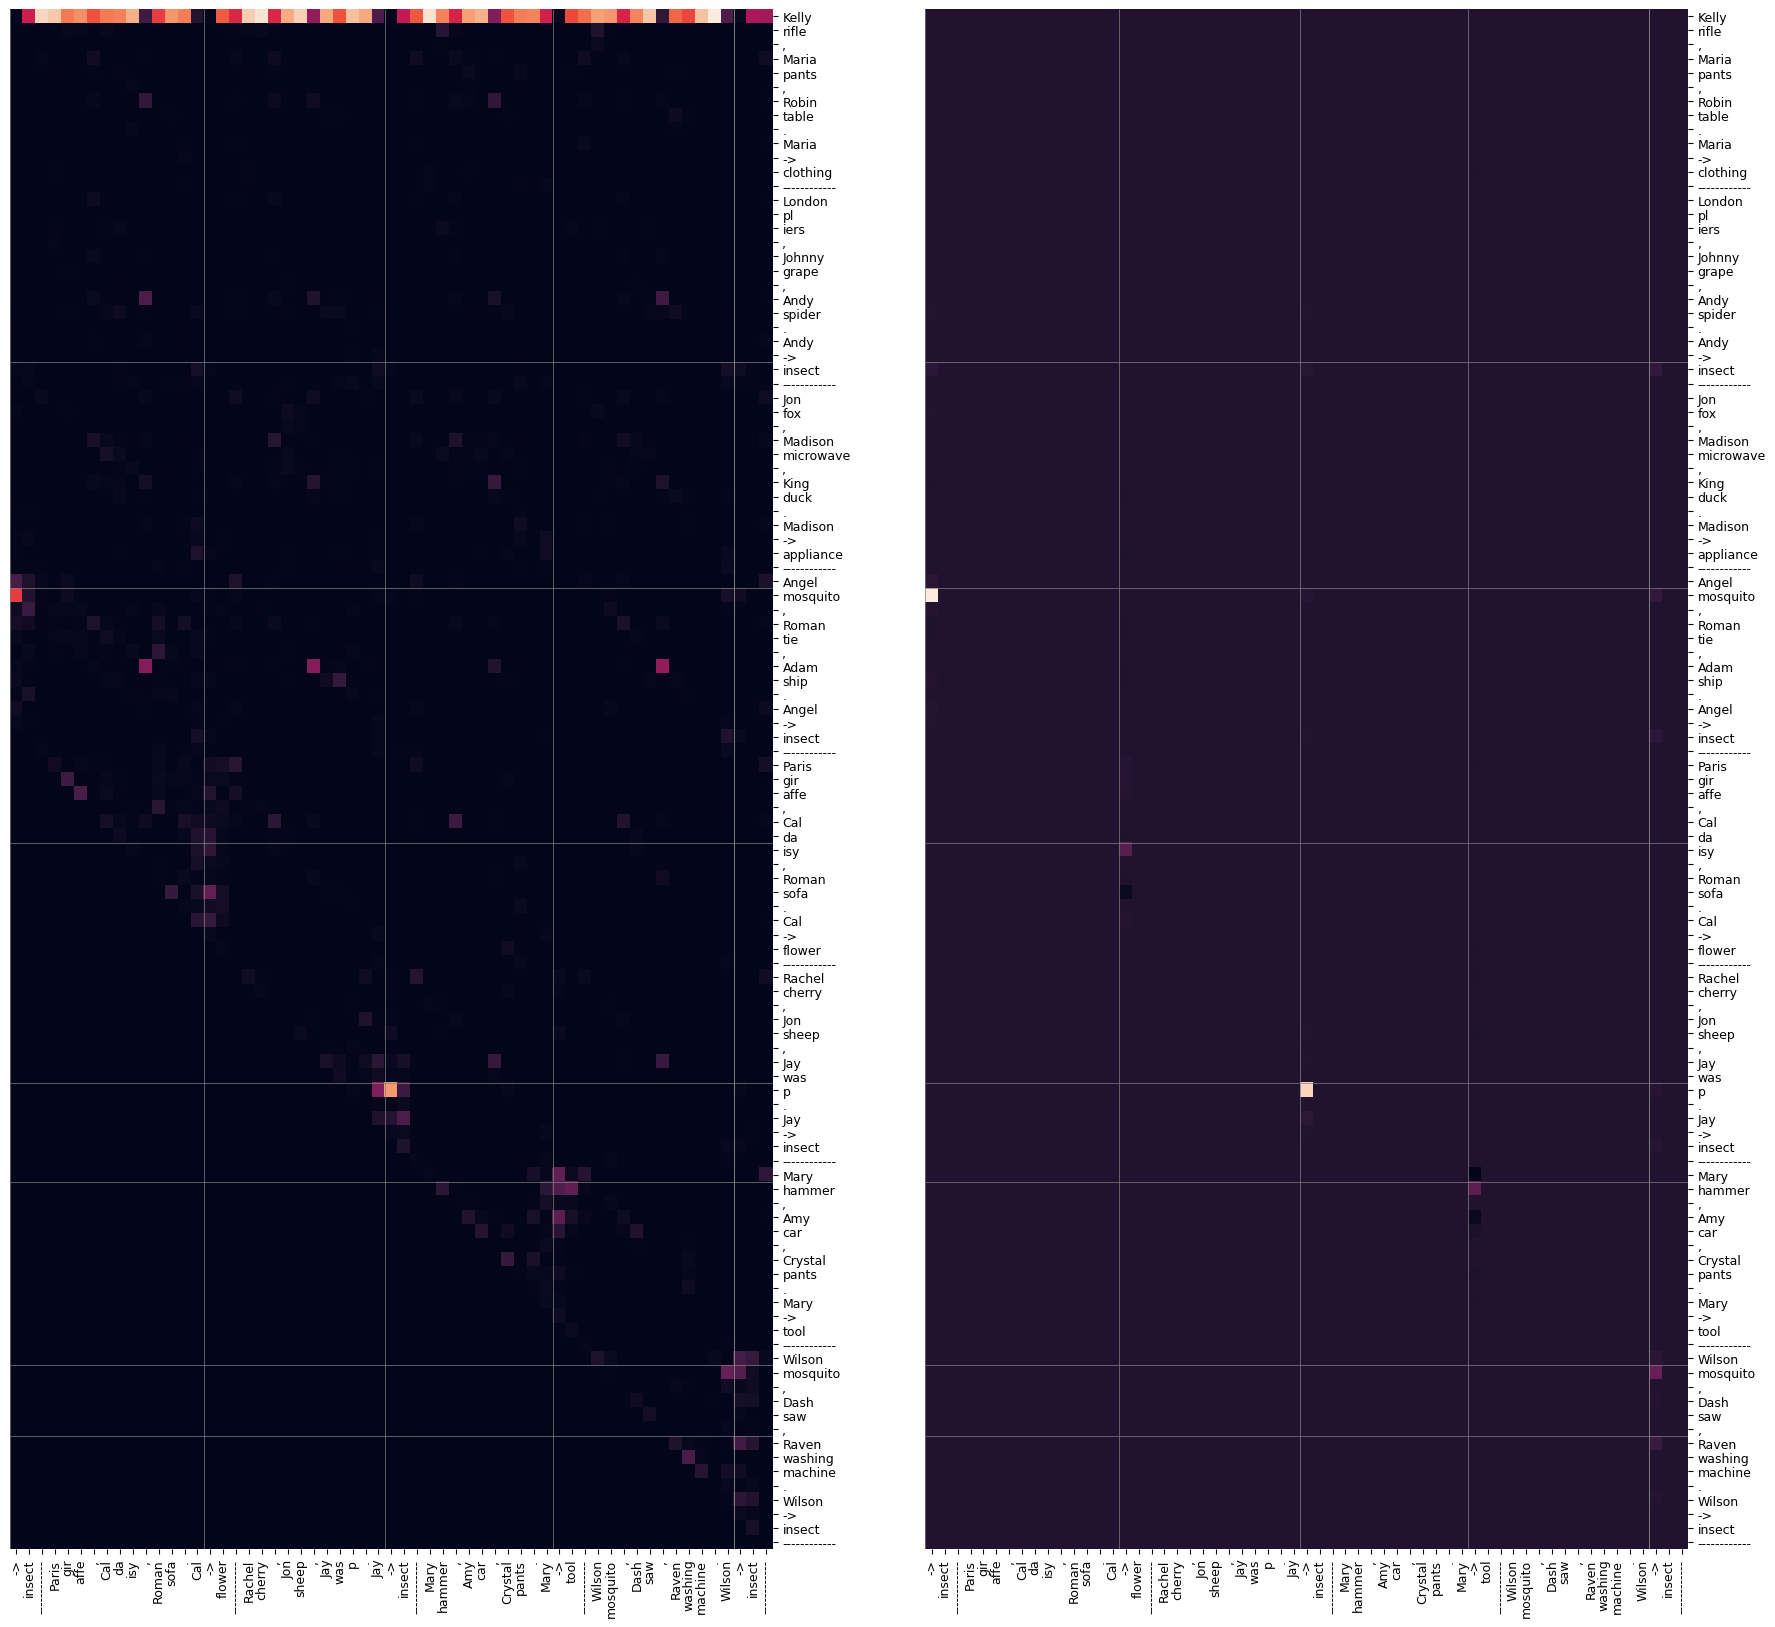

done 0:00:04.441848
sum_forward ... done 0:00:00.450057
tensor([-10.5814,  -9.3590, -10.7712, -14.4370])
 Ġvehicle 0.0 {'Ġwood': 0.009, 'Ġzo': 0.006, 'ĠUr': 0.006, 'Ġzoo': 0.006} 	 Henry apricot, Dash cannon, Victoria train. Victoria -> vehicle
 Ġflower 0.0 {'Ġmascot': 0.098, 'Ġaffection': 0.05, 'Ġmales': 0.036, 'Ġpets': 0.029} 	 Patrick tulip, Anthony elephant, Major scissors. Patrick -> flower
 Ġtool 0.0 {'Ġaest': 0.117, 'Ġpuberty': 0.089, 'Ġcute': 0.05, 'Ġadorable': 0.045} 	 Dash sofa, Albert spanner, April skirt. Albert -> tool
 Ġtool 0.0 {'Ġprince': 0.88, 'Ġprinces': 0.051, 'ĠPrince': 0.02, 'Prince': 0.006} 	 Prince wrench, Joy cow, Morgan shirt. Prince -> tool
 Ġtool 0.0 {'Ġplush': 0.152, 'Ġgarment': 0.064, 'Ġfeminine': 0.047, 'Ġhairst': 0.041} 	 Dallas dress, Taylor shovel, Arthur giraffe. Taylor -> tool
 Ġvehicle 0.0 {'Ġplants': 0.088, 'Ġtractor': 0.057, 'Ġbicycles': 0.029, 'Ġtoys': 0.029} 	 Raven sunflower, William rose, Sarah tractor. Sarah -> vehicle
 Ġtool 0.0 {'Ġautomobile

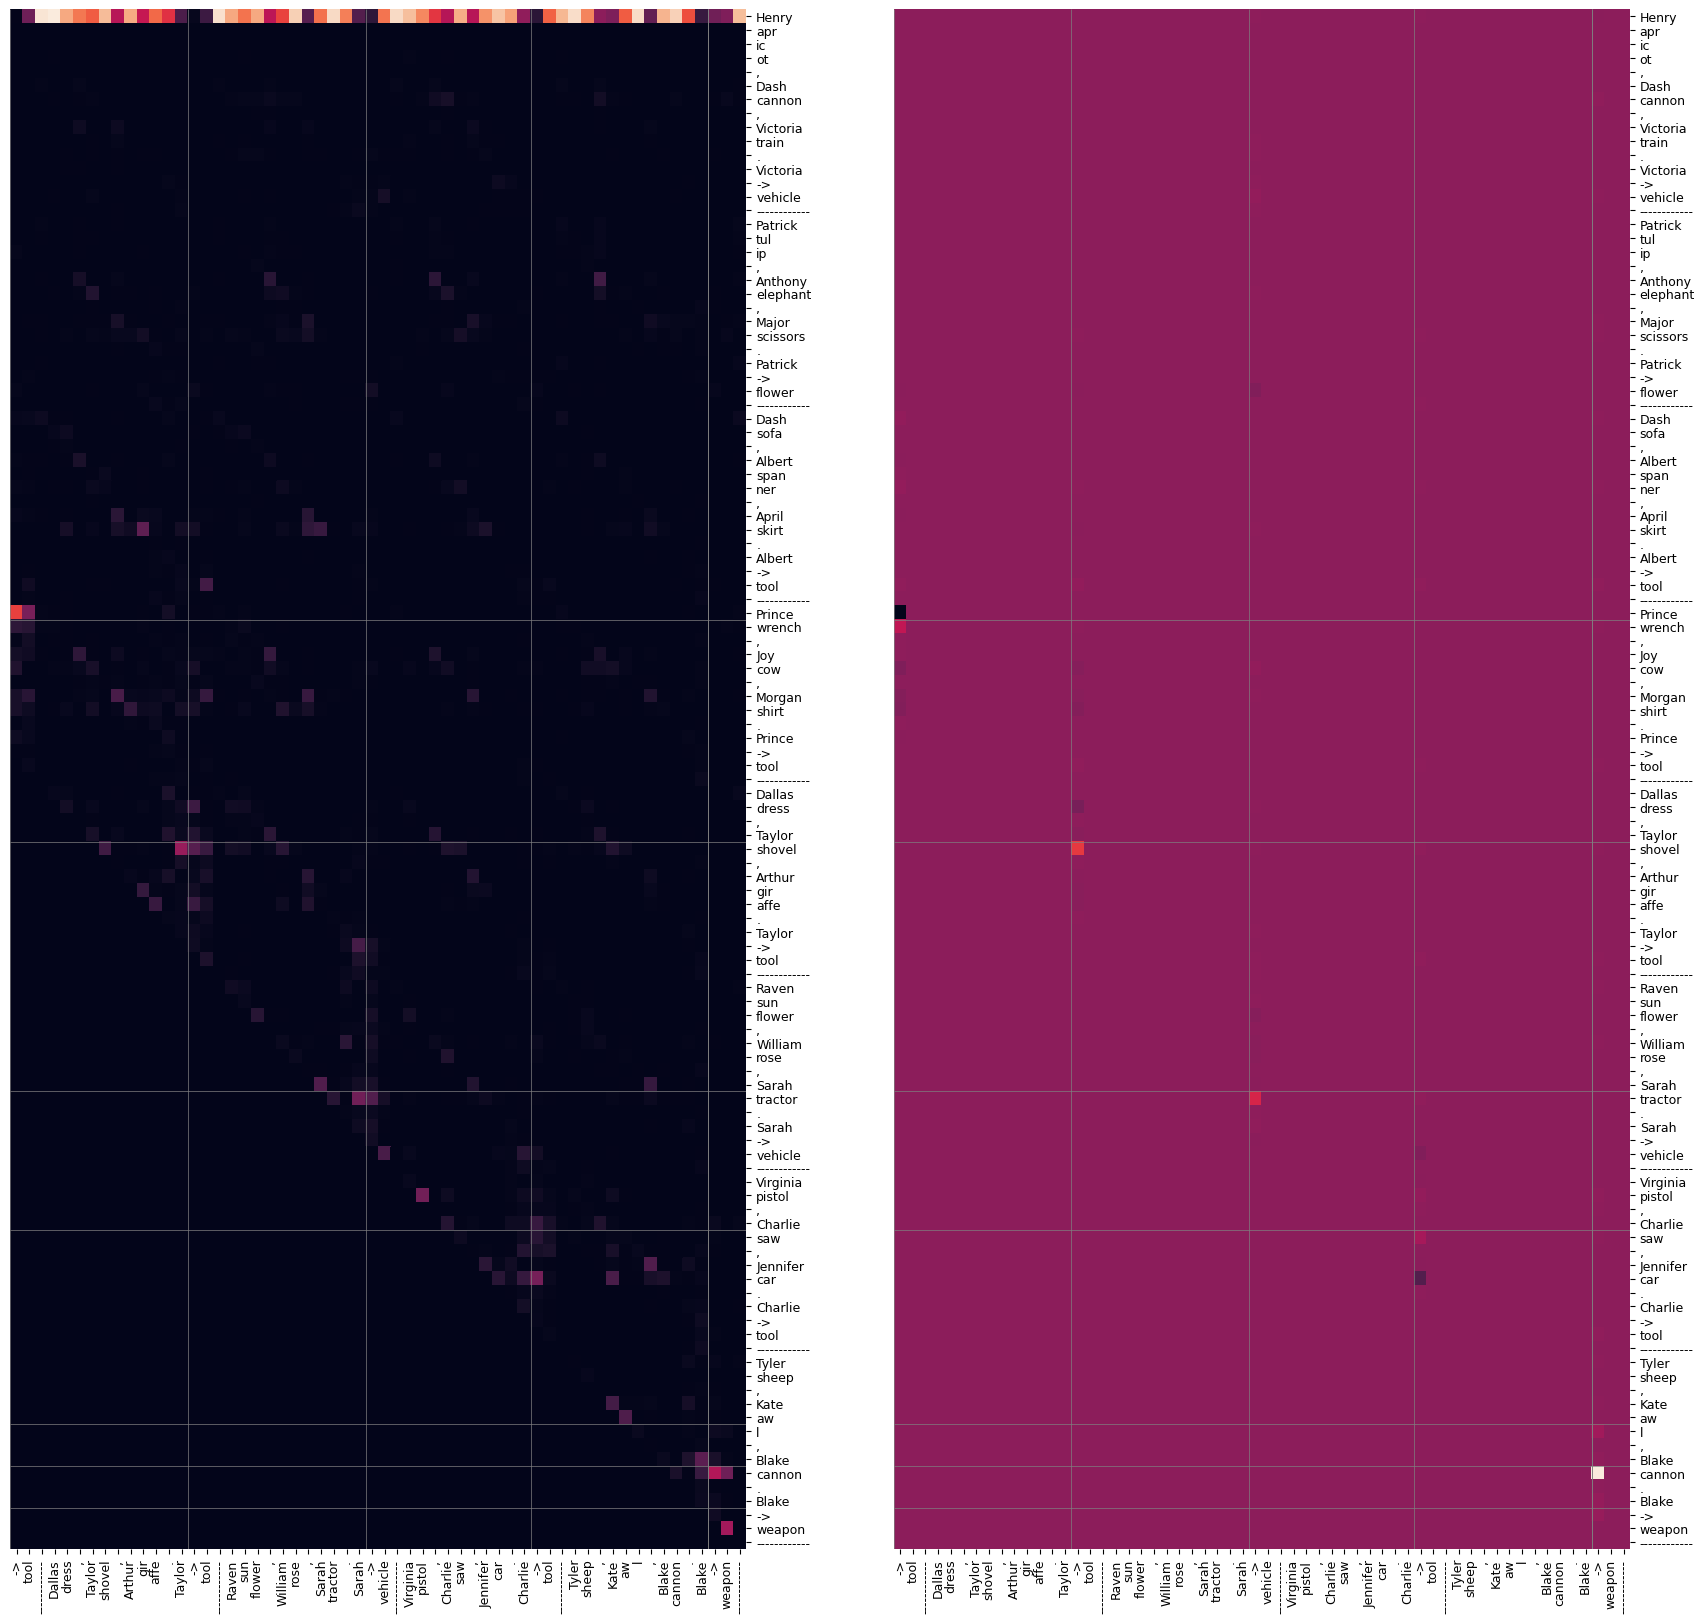

done 0:00:04.689541
sum_forward ... done 0:00:00.433271
tensor([-10.8891,  -8.0704,  -9.2087, -12.2917])
 Ġclothing 0.002 {'Ġanthrop': 0.02, 'Ġzoo': 0.017, 'Ġpoet': 0.013, 'Ġzo': 0.009} 	 Jamie pants, Prince monkey, Gary peach. Jamie -> clothing
 Ġvehicle 0.0 {'Ġerection': 0.208, 'Ġerect': 0.165, 'Ġprince': 0.058, 'Ġmarriage': 0.056} 	 Edward ship, Jamie hammer, Jane coat. Edward -> vehicle
 Ġanimal 0.169 {'Ġdogs': 0.453, 'Ġanimal': 0.169, 'Ġanimals': 0.126, 'Ġcanine': 0.123} 	 John scissors, Clark dog, Graham airplane. Clark -> animal
 Ġappliance 0.0 {'Ġoceans': 0.534, 'Ġocean': 0.434, 'Ocean': 0.009, 'Ġwater': 0.008} 	 Angel mango, Elsa durian, Ocean dryer. Ocean -> appliance
 Ġanimal 0.012 {'Ġhorses': 0.806, 'Ġhorse': 0.049, 'Ġanimals': 0.046, 'ĠHorses': 0.041} 	 Virginia apricot, Dash horse, Ruby plum. Dash -> animal
 Ġinsect 0.011 {'Ġcute': 0.137, 'Ġaide': 0.05, 'Ġemployee': 0.022, 'Ġadorable': 0.021} 	 India horse, Andy ant, Jack pliers. Andy -> insect
 Ġfruit 0.0 {'Ġmonarch': 0.

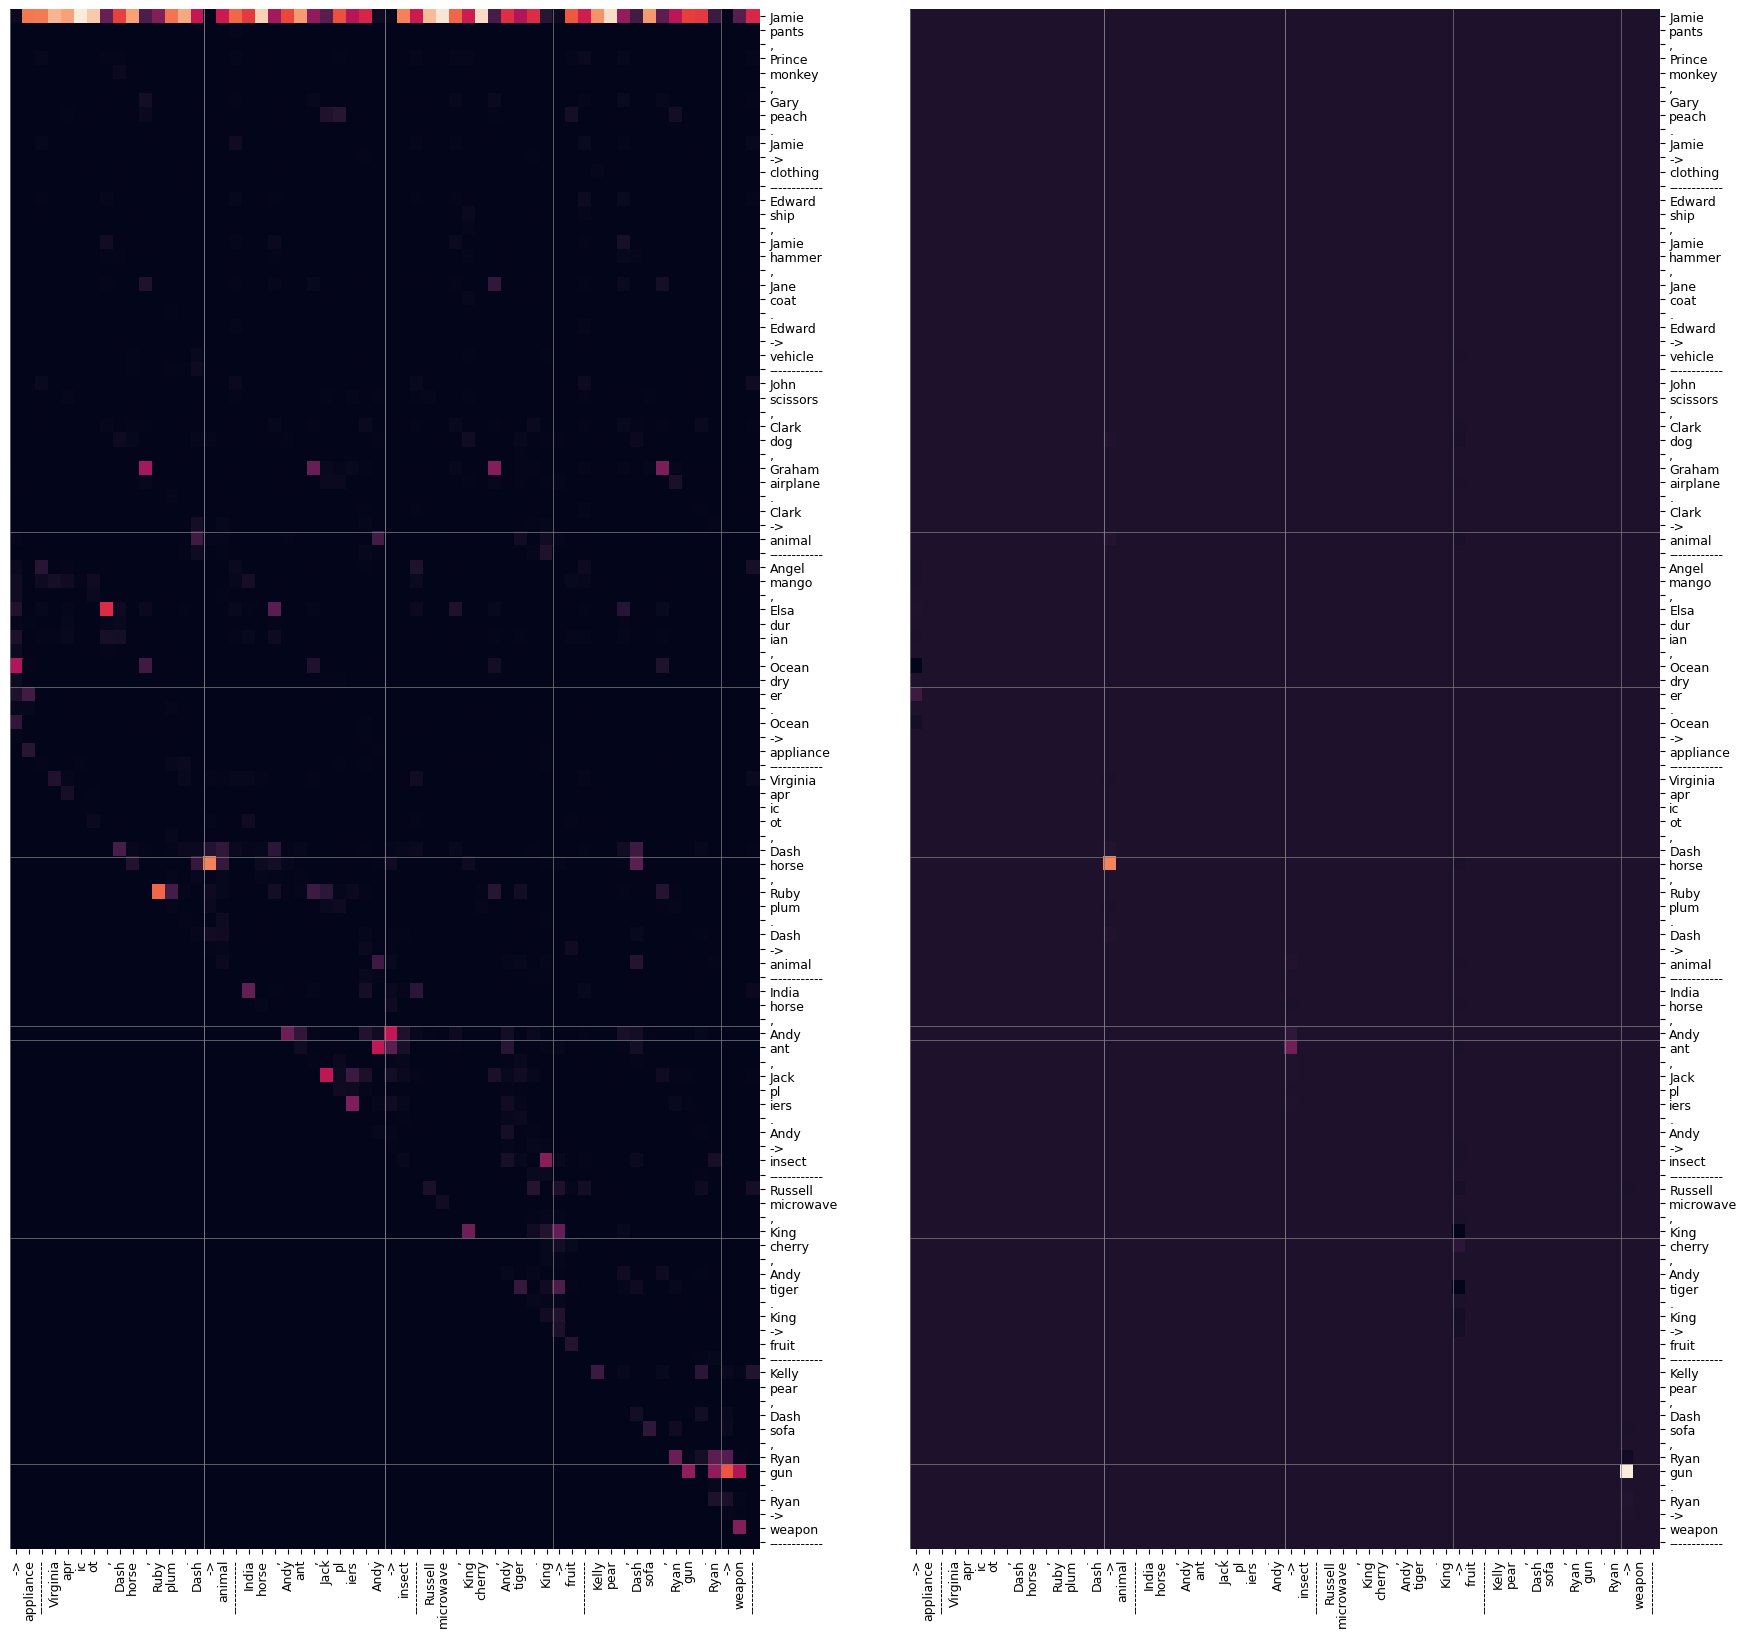

done 0:00:04.605262
sum_forward ... done 0:00:00.424739
tensor([-11.0748,  -6.8924,  -5.5220,  -6.4318])
 Ġweapon 0.0 {'Ġfactory': 0.014, 'Ġwood': 0.011, 'Ġzo': 0.005, 'ĠUr': 0.005} 	 Arthur pistol, Jamie dress, Sky microwave. Arthur -> weapon
 Ġfurniture 0.008 {'Ġrecl': 0.08, 'Ġclothing': 0.025, 'Ġsleeping': 0.023, 'Ġwardrobe': 0.022} 	 King blackberry, Graham tie, Johnny couch. Johnny -> furniture
 Ġappliance 0.0 {'Ġfurniture': 0.995, 'Ġrentals': 0.0, 'Ġwarehouses': 0.0, 'Ġpurchases': 0.0} 	 Andy blackberry, Grey microwave, Summer goat. Grey -> appliance
*Ġinsect 0.458 {'Ġinsect': 0.458, 'Ġinsects': 0.307, 'ĠInsect': 0.144, 'Ġvenom': 0.056} 	 Andrew shirt, Victoria dagger, King wasp. King -> insect
 Ġclothing 0.012 {'Ġcoats': 0.175, 'Ġgrape': 0.163, 'Ġpurchasing': 0.061, 'Ġcoat': 0.057} 	 Anna apple, Henry jacket, Andrew grape. Henry -> clothing
 Ġclothing 0.0 {'Ġmanufactures': 0.213, 'ĠPurch': 0.068, 'Ġpurchasing': 0.065, 'Products': 0.048} 	 Eva skirt, Jack washing machine, August 

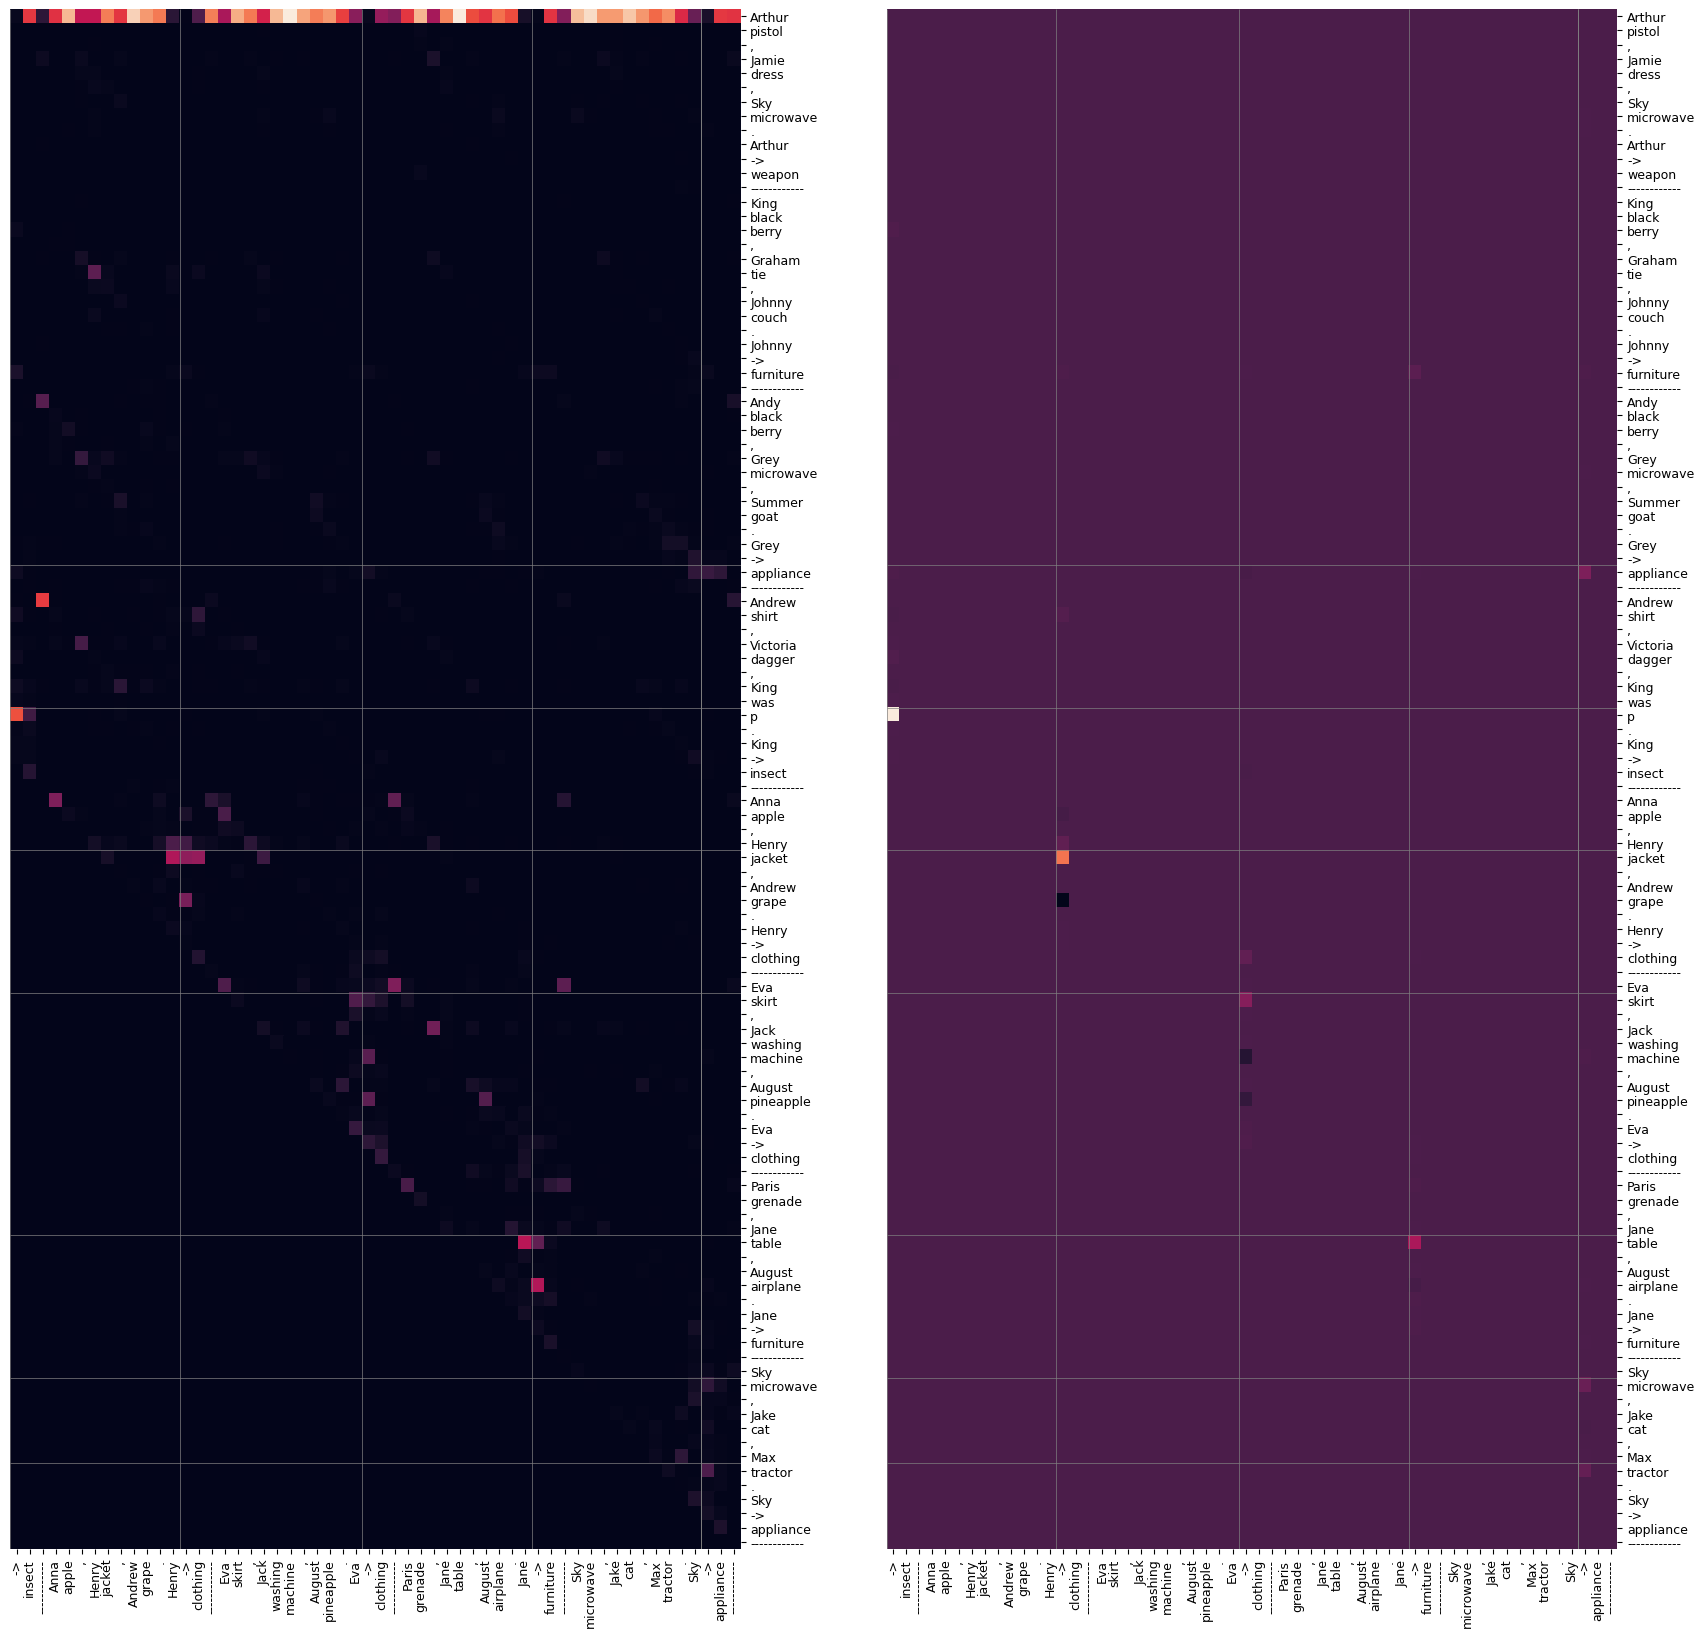

done 0:00:04.631272
21 5 0
sum_forward ... done 0:00:00.644687
tensor([-10.9759,  -6.6872,  -8.1611, -11.0174])
 Ġclothing 0.001 {'Ġwomen': 0.902, 'Women': 0.032, 'Ġgirls': 0.029, 'ĠWomen': 0.019} 	 Kelly rifle, Maria pants, Robin table. Maria -> clothing
 Ġinsect 0.0 {'Ġcrafts': 0.955, 'Ġgardening': 0.011, 'Ġshop': 0.009, 'Ġtrades': 0.006} 	 London pliers, Johnny grape, Andy spider. Andy -> insect
 Ġappliance 0.0 {'Ġanimal': 0.715, 'Ġanimals': 0.142, 'Animal': 0.078, 'ĠAnimal': 0.035} 	 Jon fox, Madison microwave, King duck. Madison -> appliance
 Ġinsect 0.0 {'Ġwedding': 0.17, 'Ġangels': 0.164, 'ĠAngels': 0.089, 'Ġangel': 0.089} 	 Angel mosquito, Roman tie, Adam ship. Angel -> insect
 Ġflower 0.003 {'Ġanimals': 0.277, 'Ġpets': 0.149, 'Ġanimal': 0.102, 'Ġflowers': 0.074} 	 Paris giraffe, Cal daisy, Roman sofa. Cal -> flower
 Ġinsect 0.0 {'Ġlivestock': 0.972, 'Ġanimal': 0.017, 'Ġanimals': 0.006, 'Animal': 0.001} 	 Rachel cherry, Jon sheep, Jay wasp. Jay -> insect
 Ġtool 0.004 {'Ġcrafts'

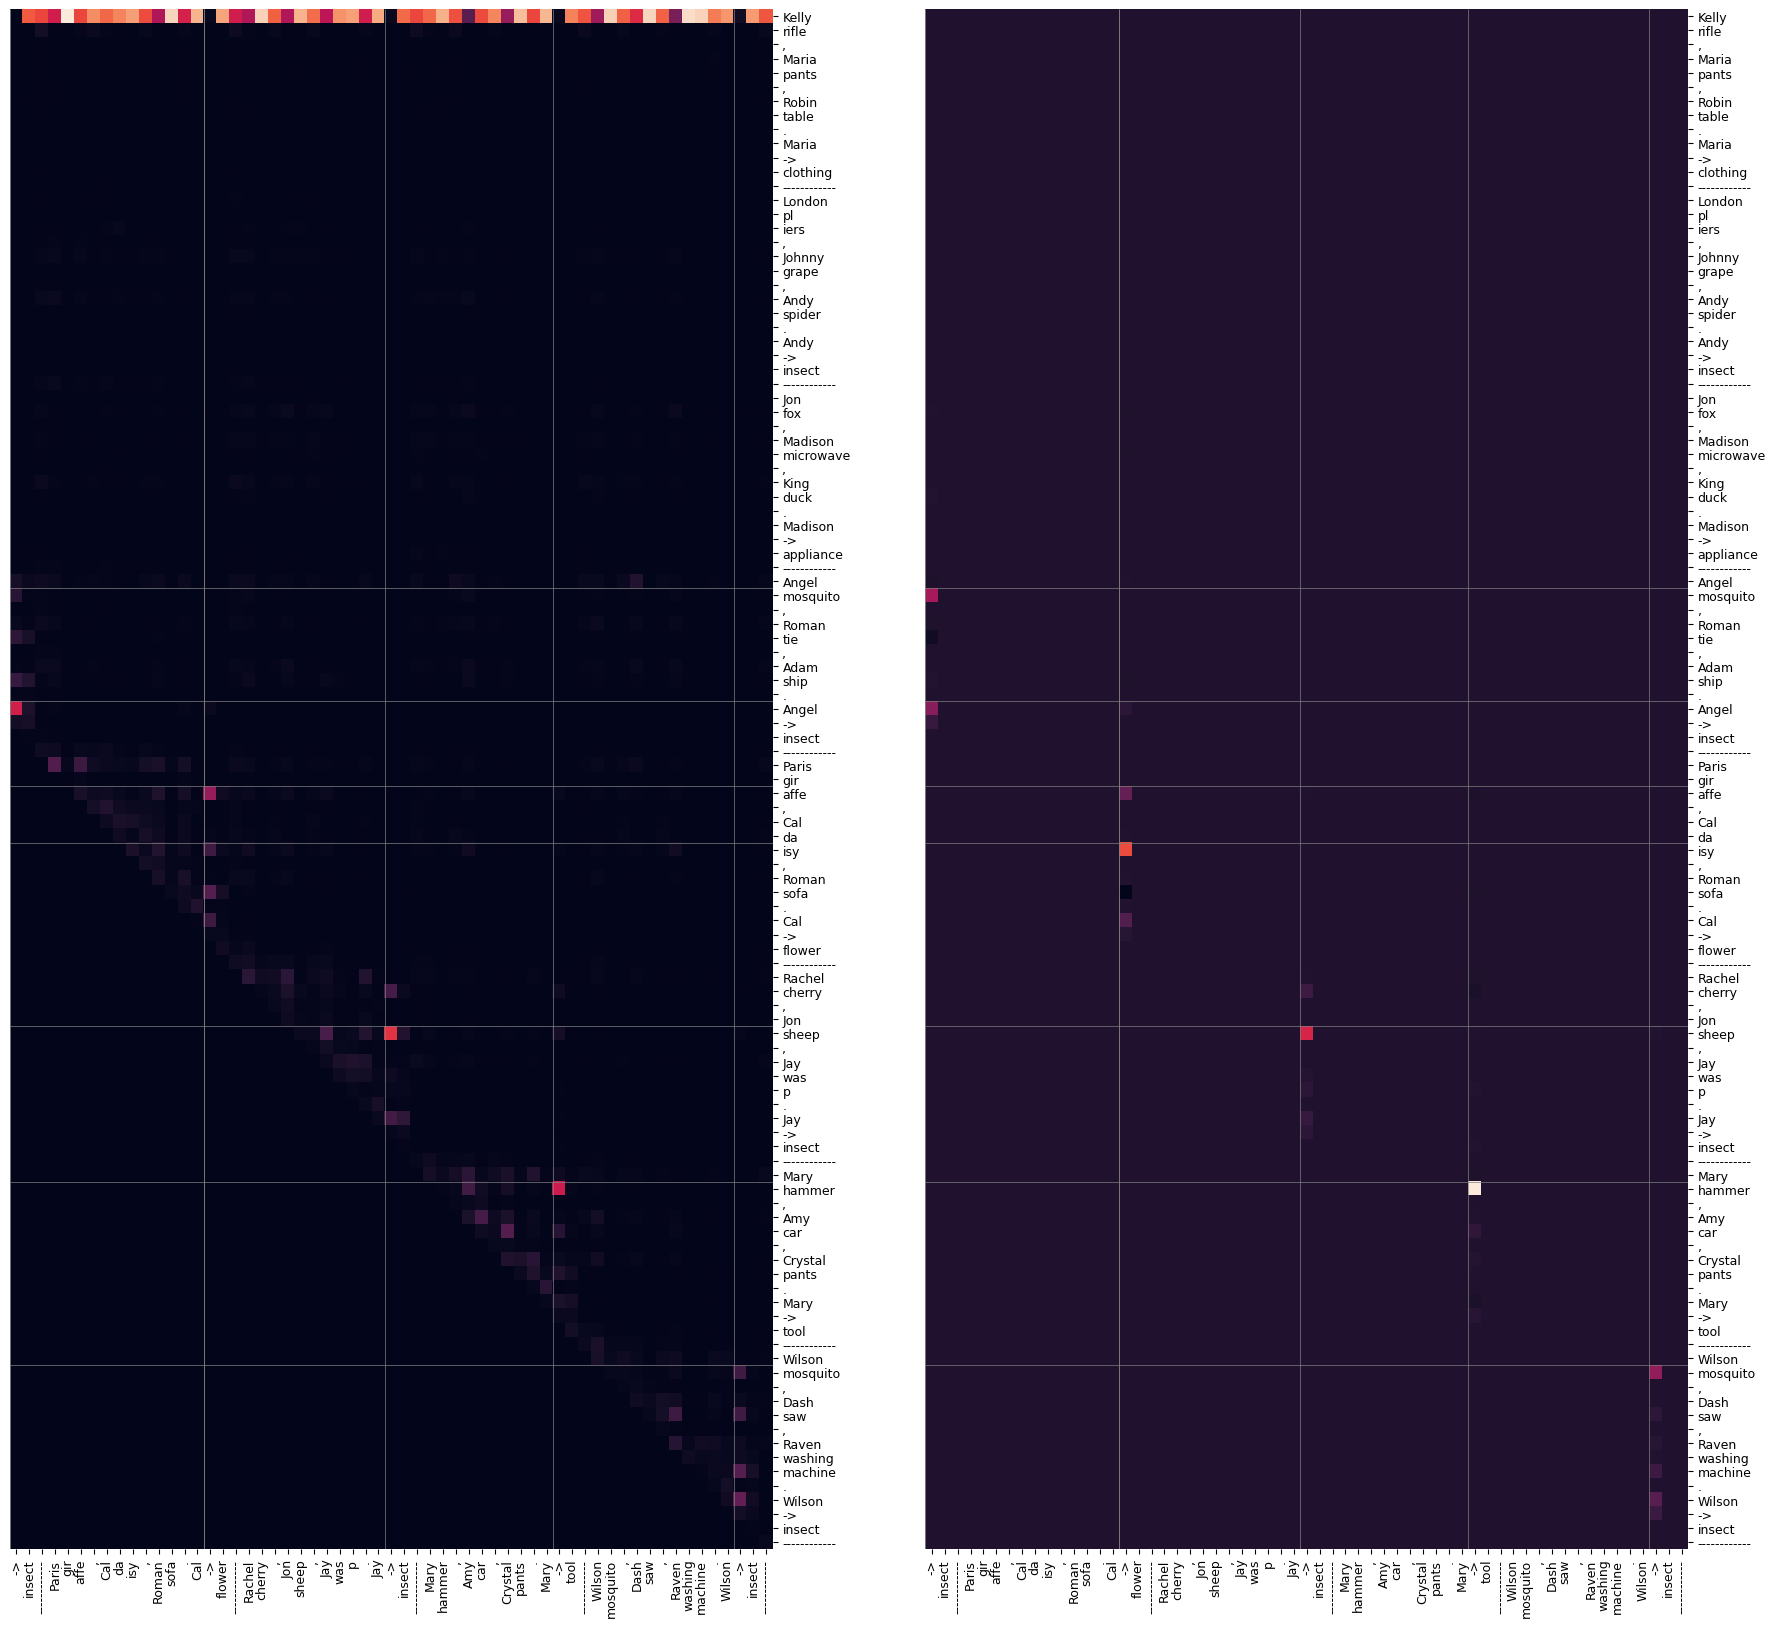

done 0:00:04.613534
sum_forward ... done 0:00:00.690198
tensor([-10.5550,  -9.0168, -15.3426, -22.7250])
 Ġvehicle 0.0 {'Ġgirls': 0.246, 'Ġrailway': 0.239, 'Ġpassenger': 0.147, 'Girls': 0.054} 	 Henry apricot, Dash cannon, Victoria train. Victoria -> vehicle
 Ġflower 0.0 {'Ġschool': 0.233, 'Ġchildren': 0.2, 'Ġkindergarten': 0.183, 'Ġpreschool': 0.138} 	 Patrick tulip, Anthony elephant, Major scissors. Patrick -> flower
 Ġtool 0.0 {'Ġfurniture': 0.983, 'Ġdresses': 0.006, 'Ġsewing': 0.002, 'Ġwardrobe': 0.002} 	 Dash sofa, Albert spanner, April skirt. Albert -> tool
 Ġtool 0.0 {'Ġlivestock': 0.982, 'Ġfarm': 0.01, 'Ġanimal': 0.003, 'Ġanimals': 0.001} 	 Prince wrench, Joy cow, Morgan shirt. Prince -> tool
 Ġtool 0.0 {'Ġzoo': 0.302, 'Ġlivestock': 0.264, 'Ġnursery': 0.179, 'Ġanimals': 0.091} 	 Dallas dress, Taylor shovel, Arthur giraffe. Taylor -> tool
 Ġvehicle 0.0 {'Ġgardening': 0.961, 'Ġflowers': 0.017, 'Ġgarden': 0.009, 'Ġfloral': 0.008} 	 Raven sunflower, William rose, Sarah tractor. Sar

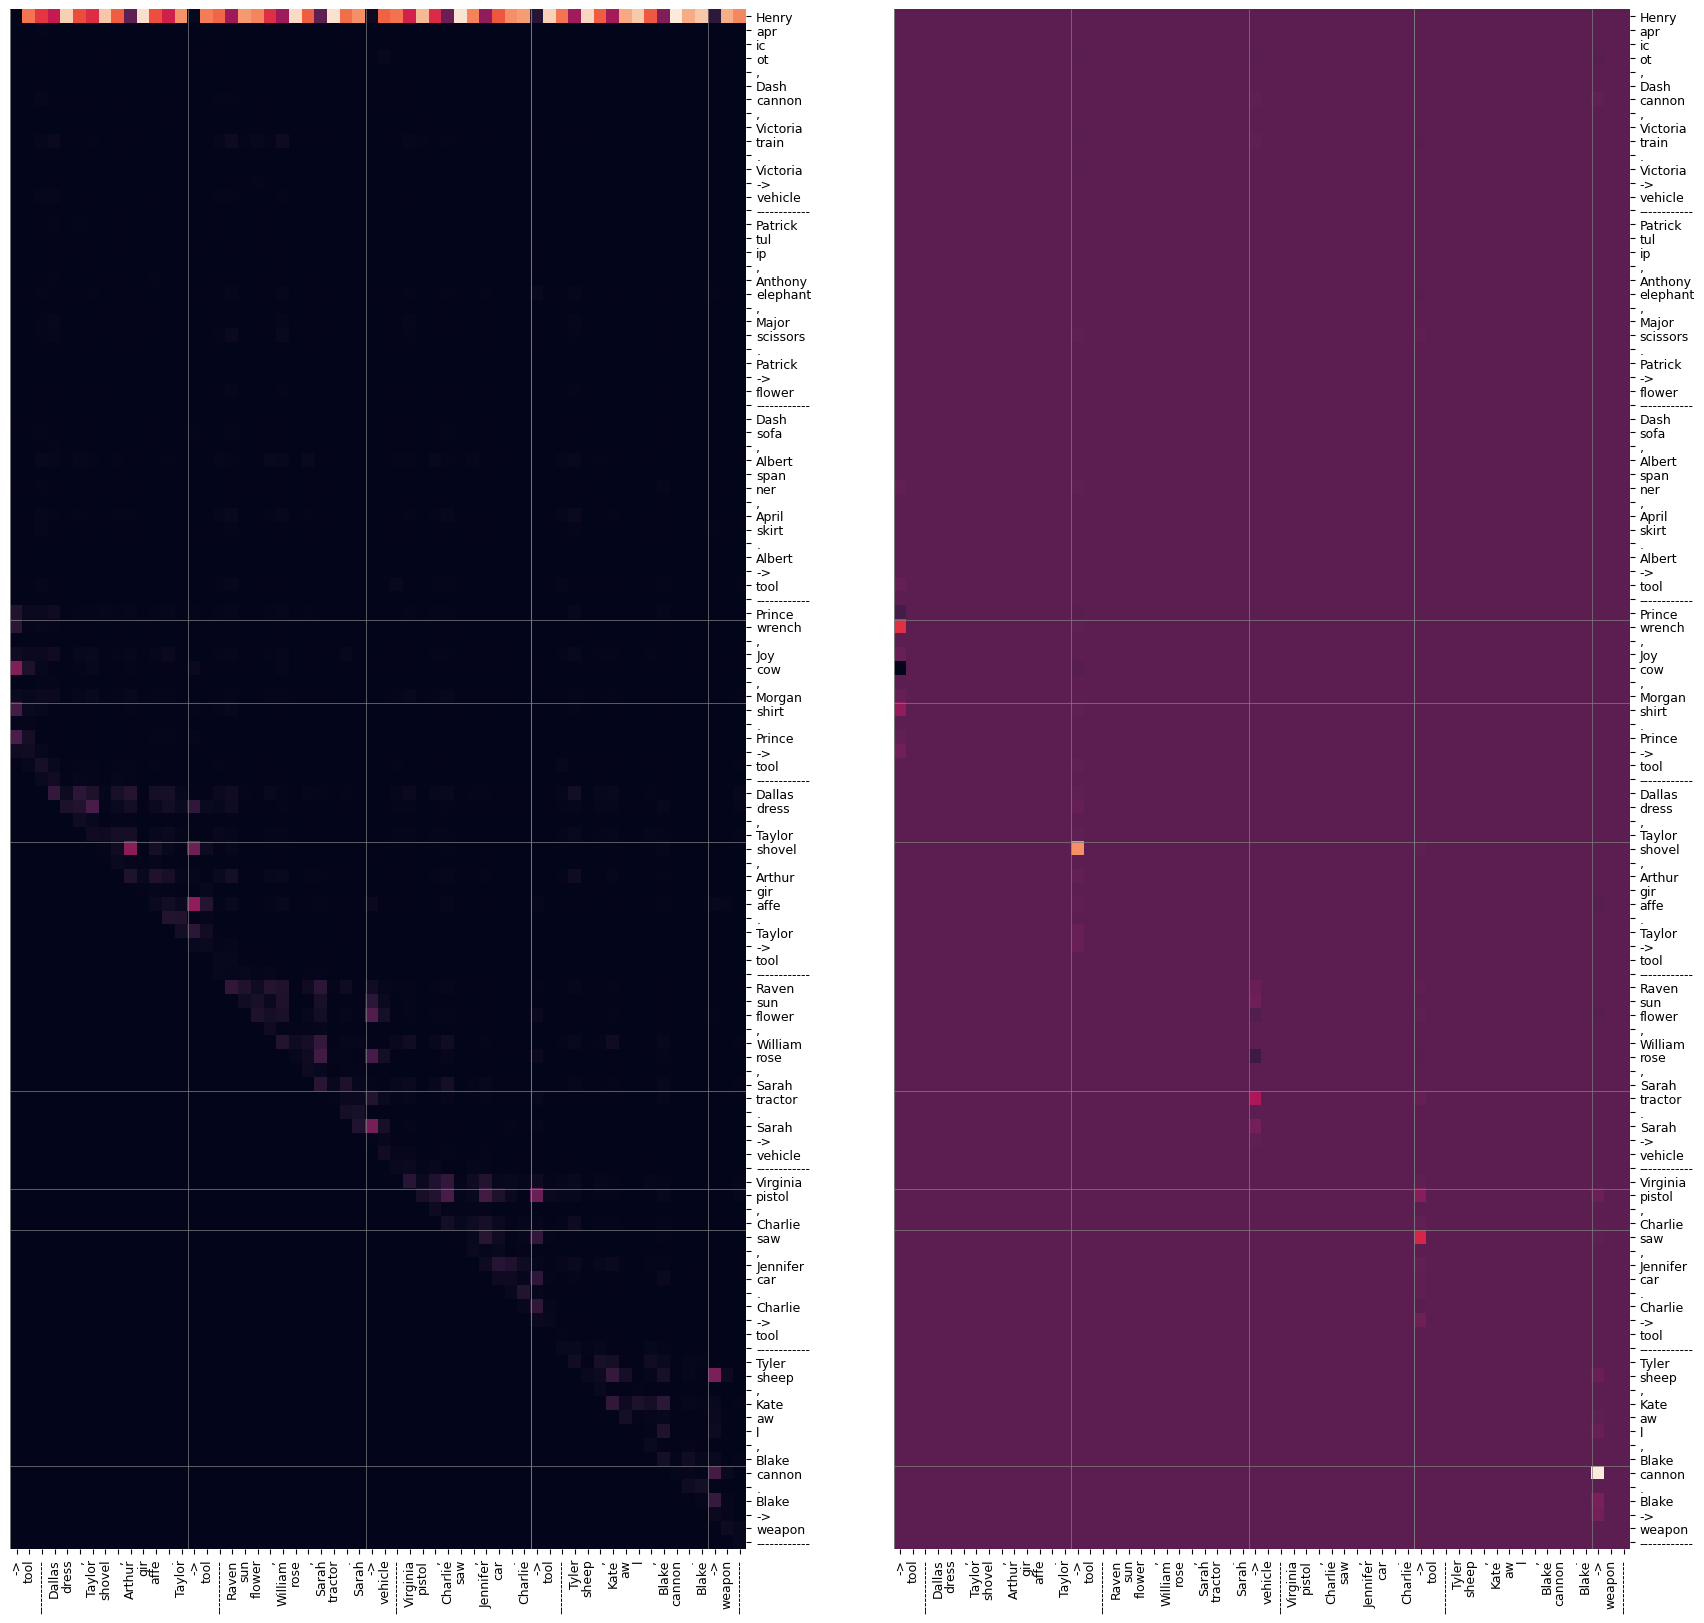

done 0:00:05.506711
sum_forward ... done 0:00:00.700096
tensor([-10.8957,  -8.7341, -14.0263, -20.4465])
 Ġclothing 0.0 {'Ġsexual': 0.326, 'Ġsexually': 0.196, 'Ġgigg': 0.143, 'sexual': 0.063} 	 Jamie pants, Prince monkey, Gary peach. Jamie -> clothing
 Ġvehicle 0.0 {'Ġclothing': 0.837, 'Ġapparel': 0.089, 'ĠClothing': 0.023, 'Ġwardrobe': 0.013} 	 Edward ship, Jamie hammer, Jane coat. Edward -> vehicle
*Ġanimal 0.424 {'Ġanimal': 0.424, 'Ġpets': 0.423, 'Ġanimals': 0.064, 'Ġdogs': 0.028} 	 John scissors, Clark dog, Graham airplane. Clark -> animal
 Ġappliance 0.0 {'Ġfood': 0.564, 'Ġseafood': 0.294, 'food': 0.086, 'Ġfoods': 0.016} 	 Angel mango, Elsa durian, Ocean dryer. Ocean -> appliance
 Ġanimal 0.0 {'Ġagricultural': 0.452, 'Ġagriculture': 0.188, 'Ġlivestock': 0.157, 'Farm': 0.08} 	 Virginia apricot, Dash horse, Ruby plum. Dash -> animal
 Ġinsect 0.0 {'Ġanimal': 0.713, 'Ġlivestock': 0.133, 'Ġanimals': 0.088, 'Ġhorses': 0.033} 	 India horse, Andy ant, Jack pliers. Andy -> insect
 Ġfruit 0

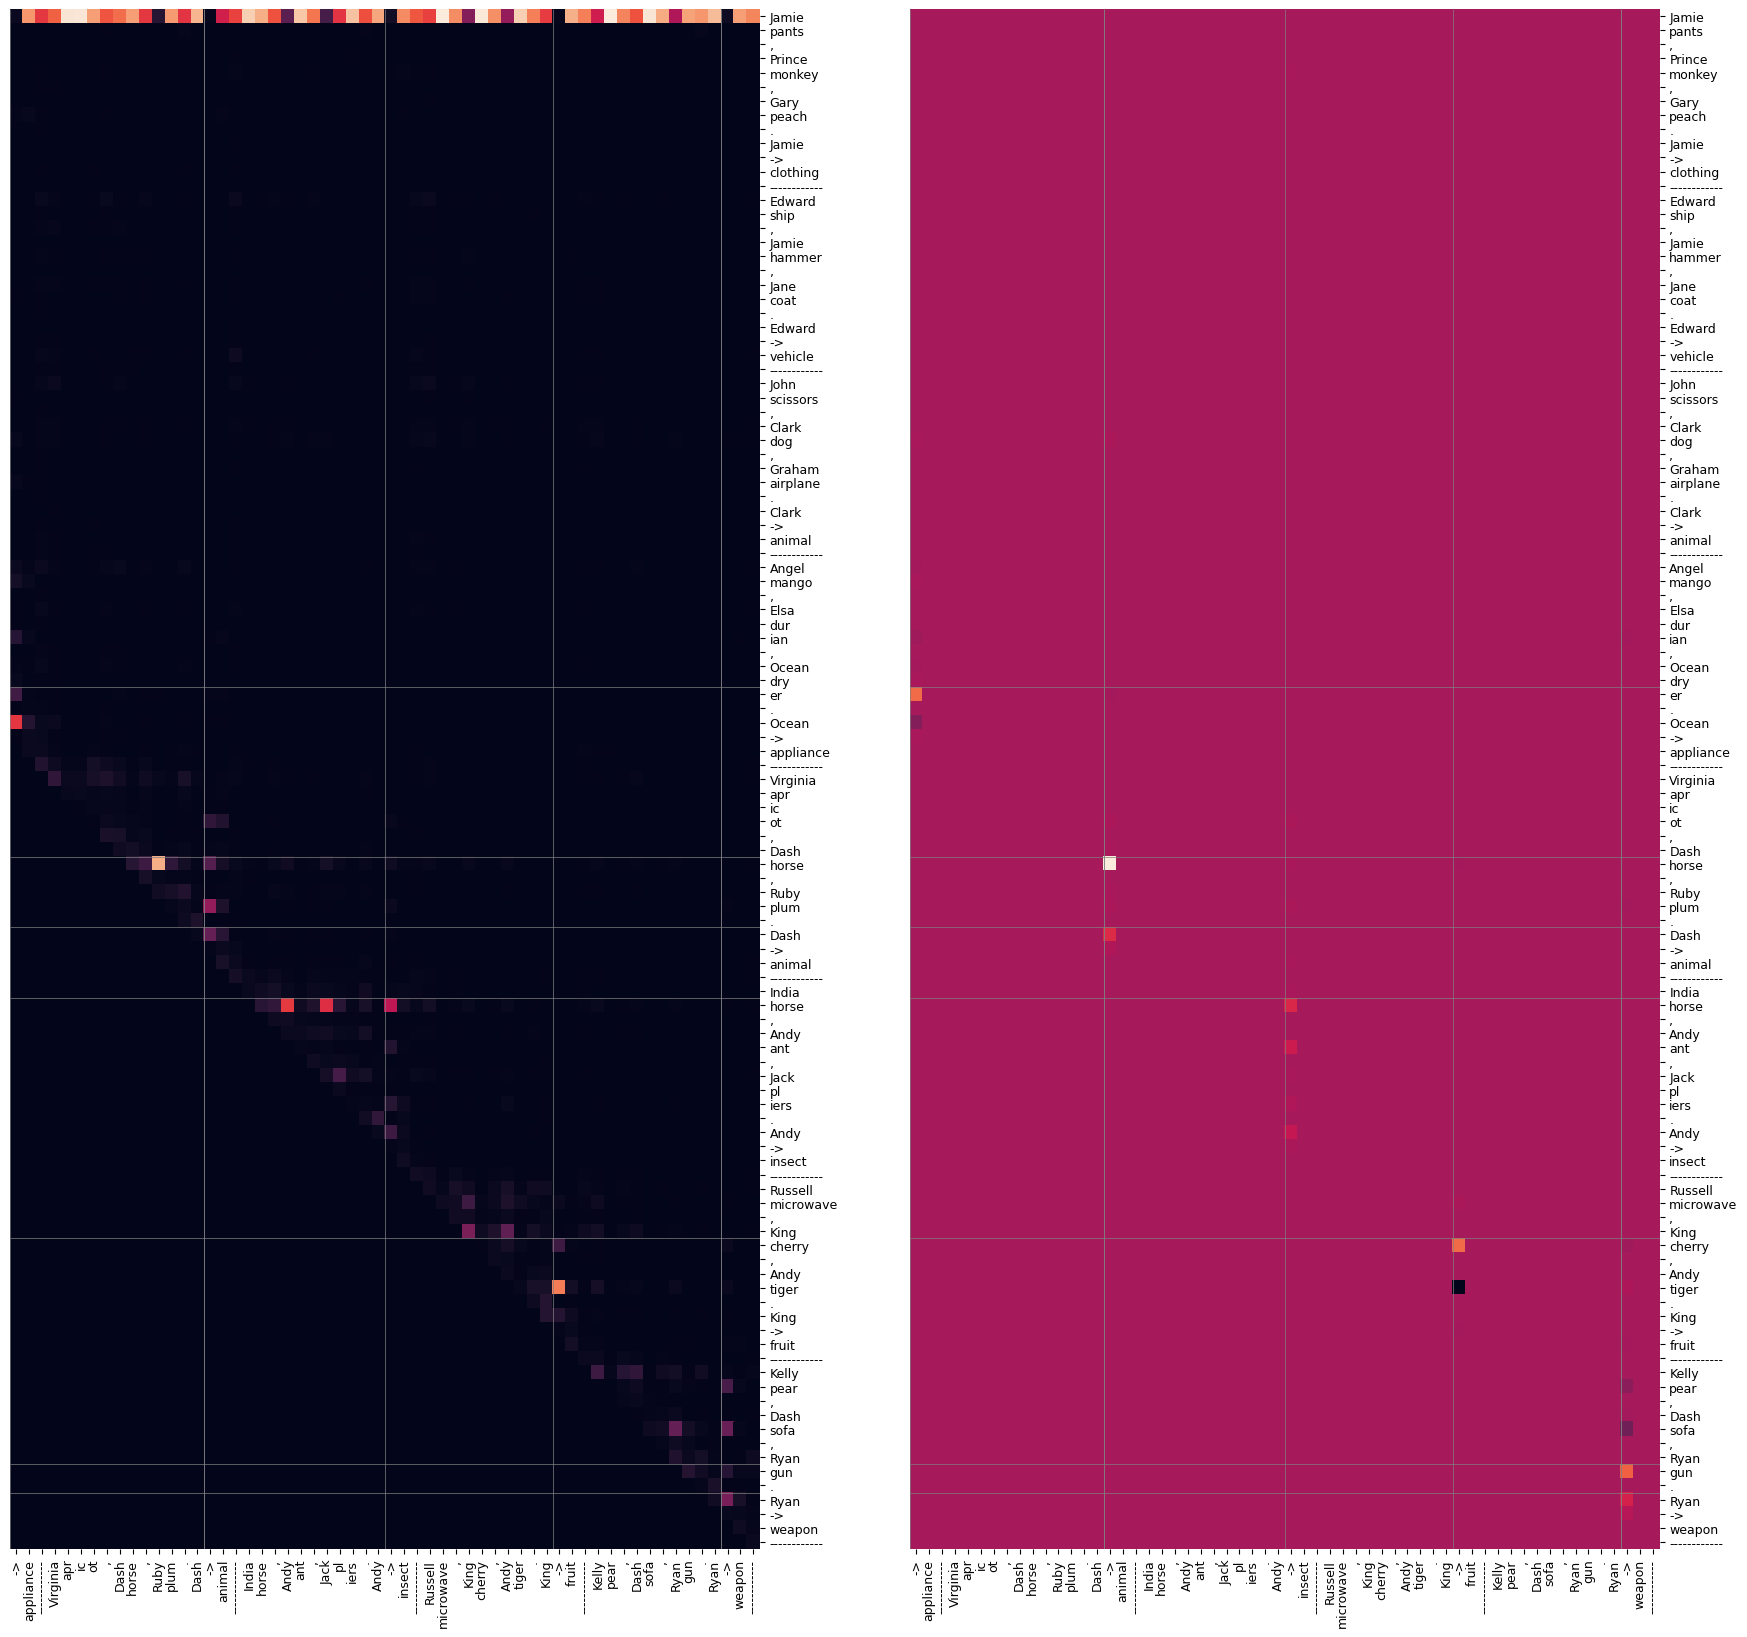

done 0:00:04.405742
sum_forward ... done 0:00:00.750648
tensor([-10.9343,  -6.9227, -10.2827, -14.6285])
 Ġweapon 0.0 {'Ġkitchen': 0.771, 'Ġcooking': 0.142, 'Ġcook': 0.021, 'Ġkitchens': 0.019} 	 Arthur pistol, Jamie dress, Sky microwave. Arthur -> weapon
*Ġfurniture 0.42 {'Ġfurniture': 0.42, 'Ġbedroom': 0.339, 'Ġclothing': 0.117, 'Ġwardrobe': 0.07} 	 King blackberry, Graham tie, Johnny couch. Johnny -> furniture
 Ġappliance 0.0 {'Ġanimal': 0.531, 'Ġlivestock': 0.298, 'Ġanimals': 0.052, 'Animal': 0.036} 	 Andy blackberry, Grey microwave, Summer goat. Grey -> appliance
 Ġinsect 0.0 {'Ġweapons': 0.717, 'Ġweapon': 0.089, 'Ġassassin': 0.06, 'Ġweaponry': 0.04} 	 Andrew shirt, Victoria dagger, King wasp. King -> insect
 Ġclothing 0.03 {'Ġfoods': 0.463, 'Ġfood': 0.453, 'Ġclothing': 0.03, 'Food': 0.028} 	 Anna apple, Henry jacket, Andrew grape. Henry -> clothing
 Ġclothing 0.0 {'Ġgroceries': 0.333, 'Ġgrocery': 0.236, 'Ġfood': 0.177, 'Ġkitchen': 0.139} 	 Eva skirt, Jack washing machine, August p

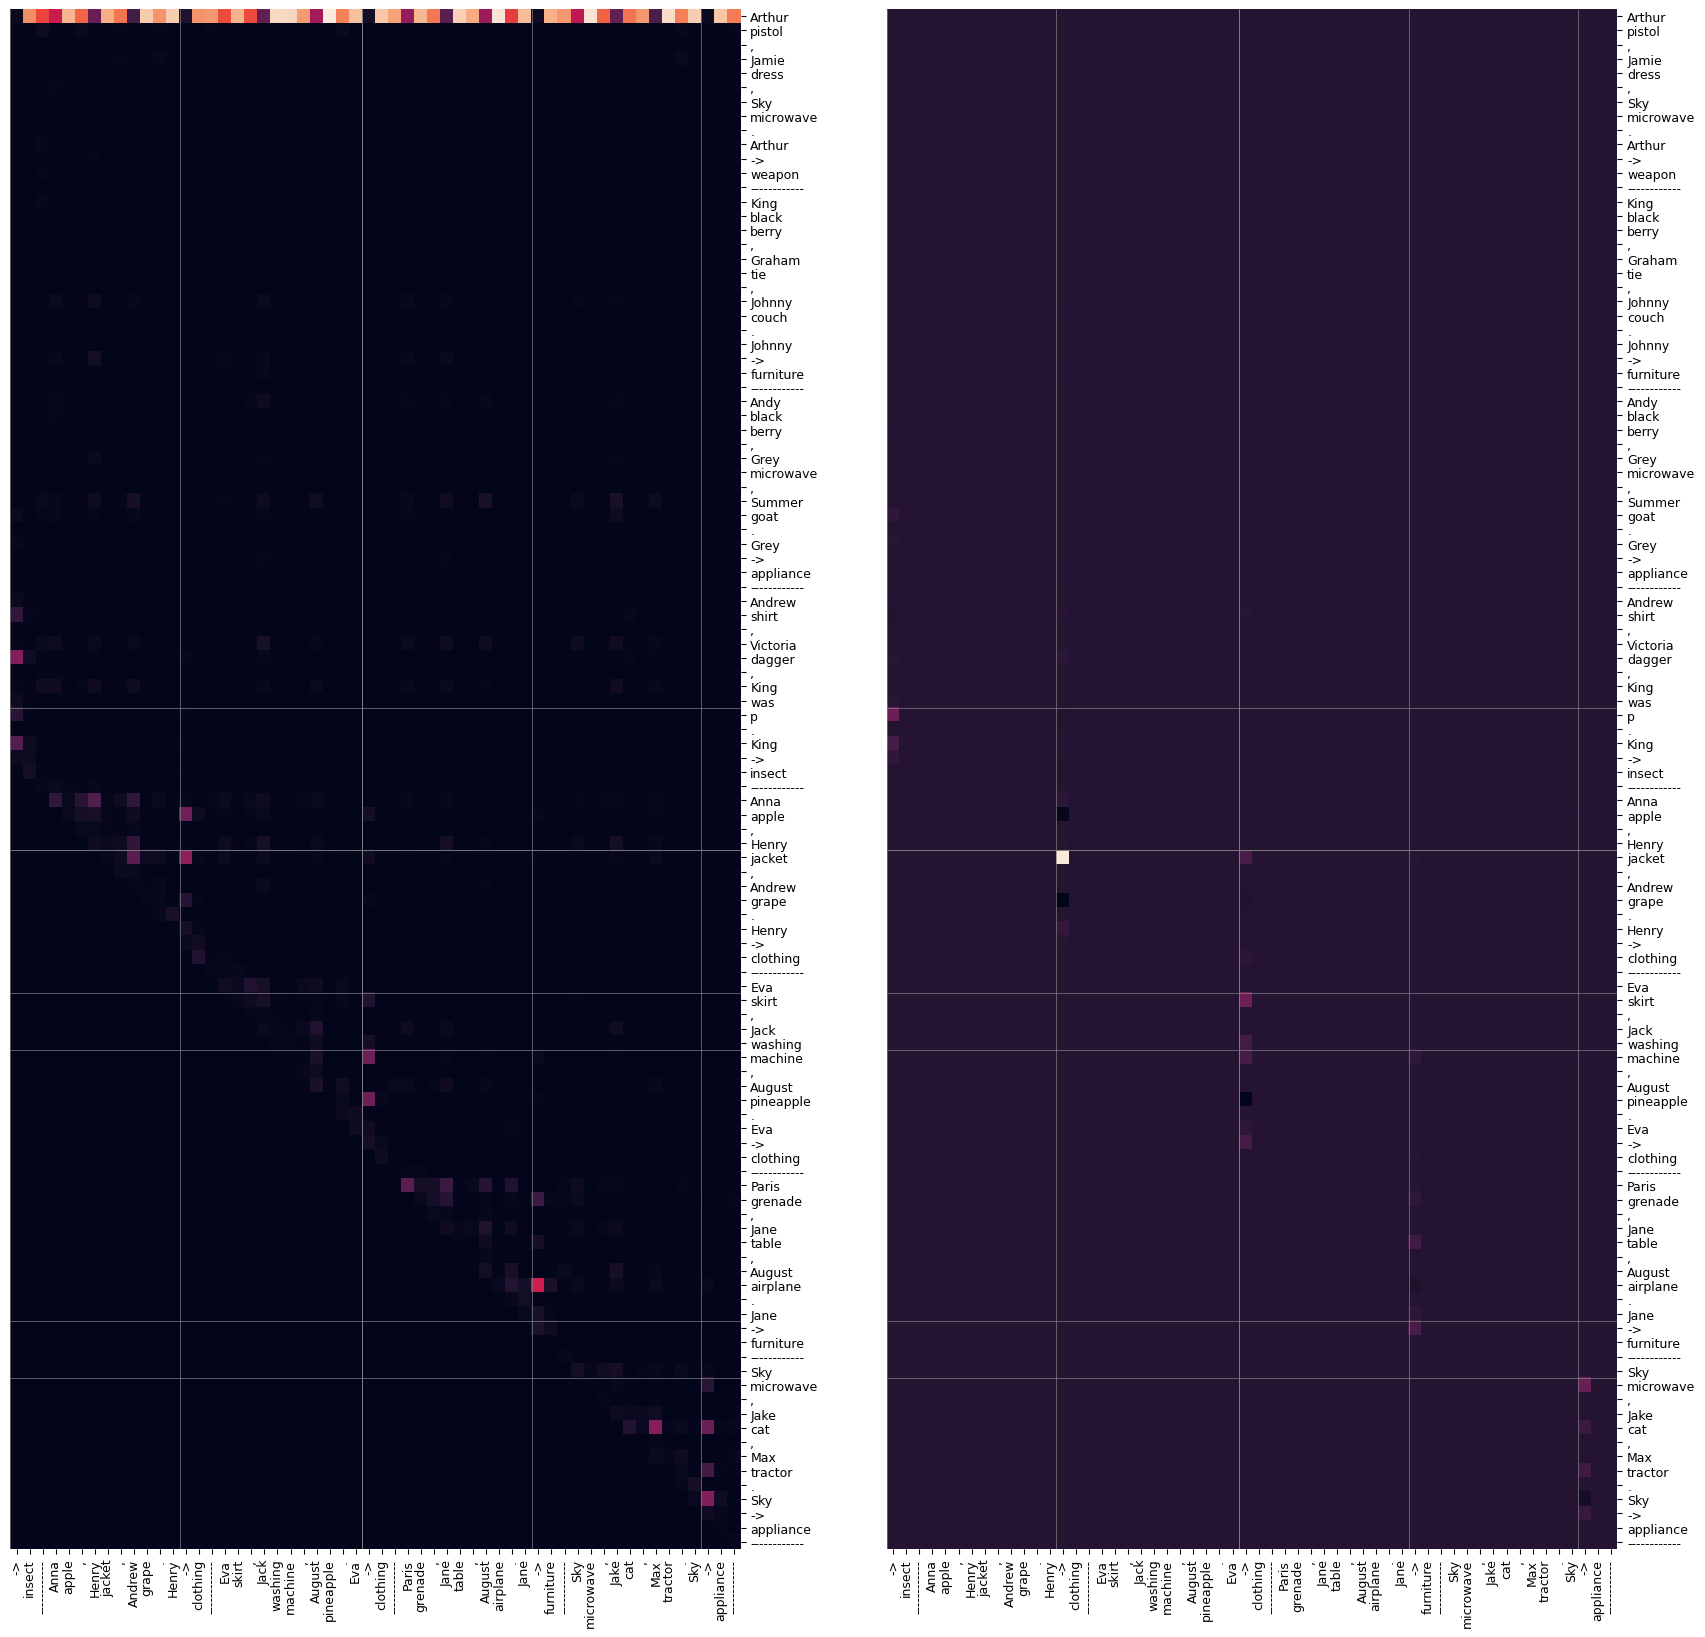

done 0:00:04.407221
15 8 0
sum_forward ... done 0:00:00.529203
tensor([-11.0860,  -8.4435,  -9.4493, -12.9852])
 Ġclothing 0.001 {'Ġfeminine': 0.473, 'Ġfemale': 0.226, 'Ġgender': 0.121, 'Ġfemin': 0.099} 	 Kelly rifle, Maria pants, Robin table. Maria -> clothing
*Ġinsect 0.302 {'Ġinsect': 0.302, 'animate': 0.132, 'Ġspiders': 0.111, 'ĠInsect': 0.079} 	 London pliers, Johnny grape, Andy spider. Andy -> insect
 Ġappliance 0.0 {'Ġgender': 0.414, 'Ġsexist': 0.256, 'Ġsexism': 0.141, 'gender': 0.099} 	 Jon fox, Madison microwave, King duck. Madison -> appliance
 Ġinsect 0.0 {'Ġgender': 0.335, 'gender': 0.11, 'Ġfemin': 0.094, 'Ġfeminine': 0.074} 	 Angel mosquito, Roman tie, Adam ship. Angel -> insect
 Ġflower 0.0 {'Ġfurniture': 0.998, 'Ġlayout': 0.001, 'Ġlayouts': 0.0, 'Ġarchitectural': 0.0} 	 Paris giraffe, Cal daisy, Roman sofa. Cal -> flower
 Ġinsect 0.018 {'Ġidentification': 0.533, 'Ġanimal': 0.192, 'ĠIdentification': 0.059, 'Ġidentifying': 0.046} 	 Rachel cherry, Jon sheep, Jay wasp. Jay -

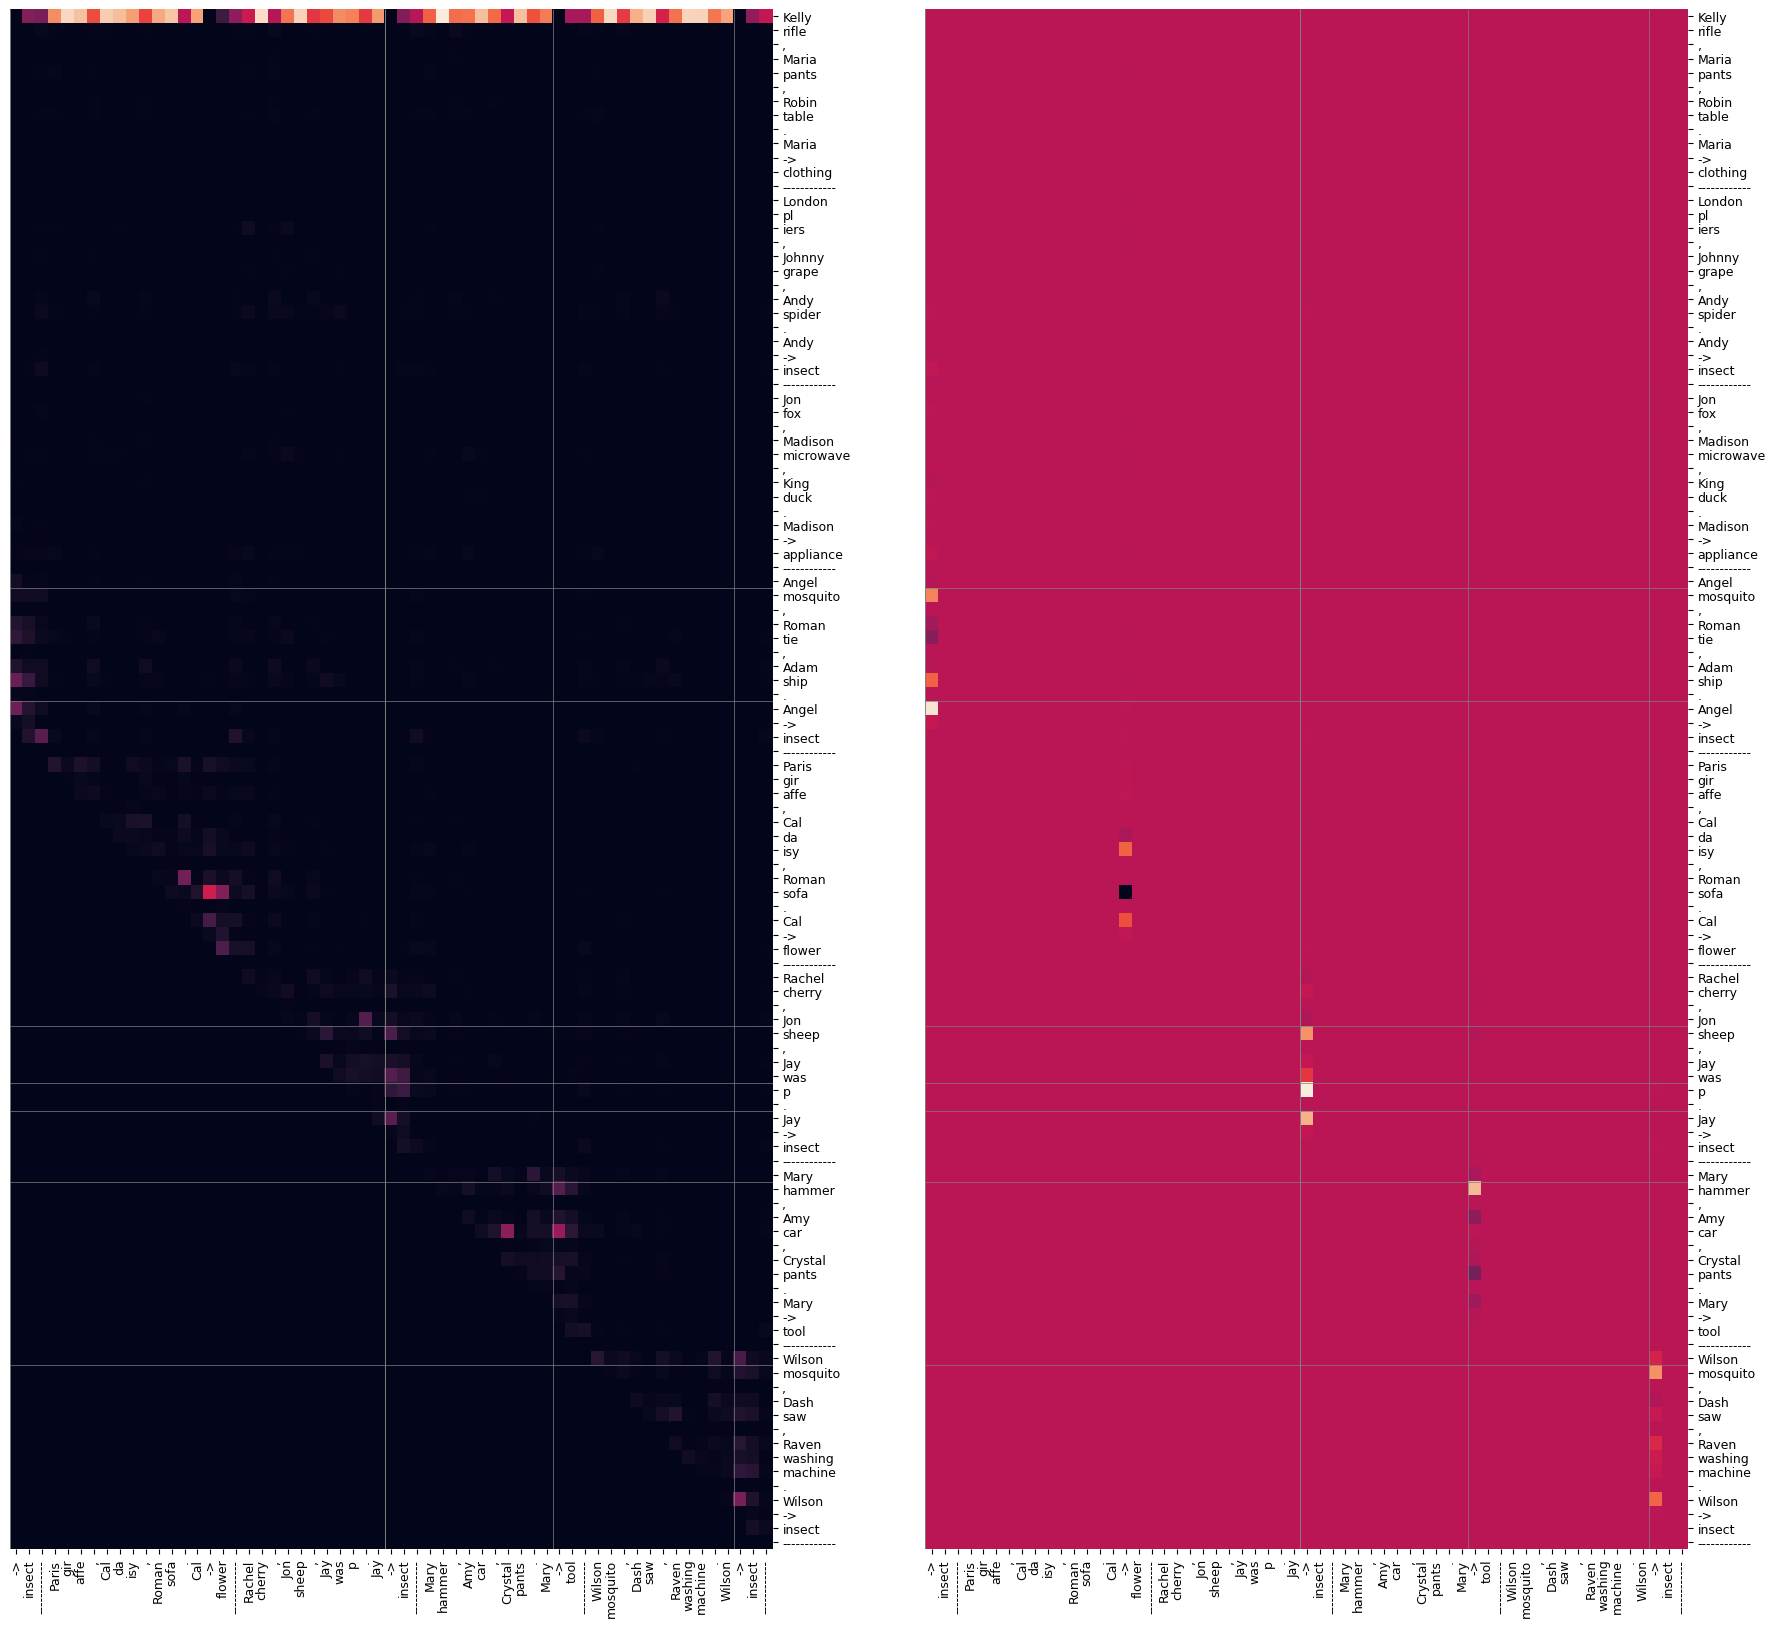

done 0:00:04.472942
sum_forward ... done 0:00:00.576419
tensor([-11.0383,  -9.7609, -12.0116, -16.5952])
 Ġvehicle 0.0 {'Ġgeographical': 0.293, 'Ġgeographic': 0.229, 'Ġtransportation': 0.132, 'Ġgeography': 0.1} 	 Henry apricot, Dash cannon, Victoria train. Victoria -> vehicle
 Ġflower 0.0 {'Ġcoincidence': 0.227, 'Ġpairing': 0.201, 'Ġmating': 0.147, 'Ġpronouns': 0.044} 	 Patrick tulip, Anthony elephant, Major scissors. Patrick -> flower
 Ġtool 0.0 {'Ġgender': 0.649, 'Ġnaming': 0.173, 'Ġgenders': 0.042, 'gender': 0.024} 	 Dash sofa, Albert spanner, April skirt. Albert -> tool
 Ġtool 0.0 {'Ġnaming': 0.581, 'Ġmasculine': 0.157, 'Ġgender': 0.088, 'Ġmascot': 0.046} 	 Prince wrench, Joy cow, Morgan shirt. Prince -> tool
 Ġtool 0.0 {'Ġgender': 0.199, 'Ġwardrobe': 0.13, 'gender': 0.09, 'Ġsurname': 0.087} 	 Dallas dress, Taylor shovel, Arthur giraffe. Taylor -> tool
 Ġvehicle 0.0 {'Ġgender': 0.734, 'gender': 0.117, 'Ġfemin': 0.069, 'Ġgenders': 0.017} 	 Raven sunflower, William rose, Sarah tracto

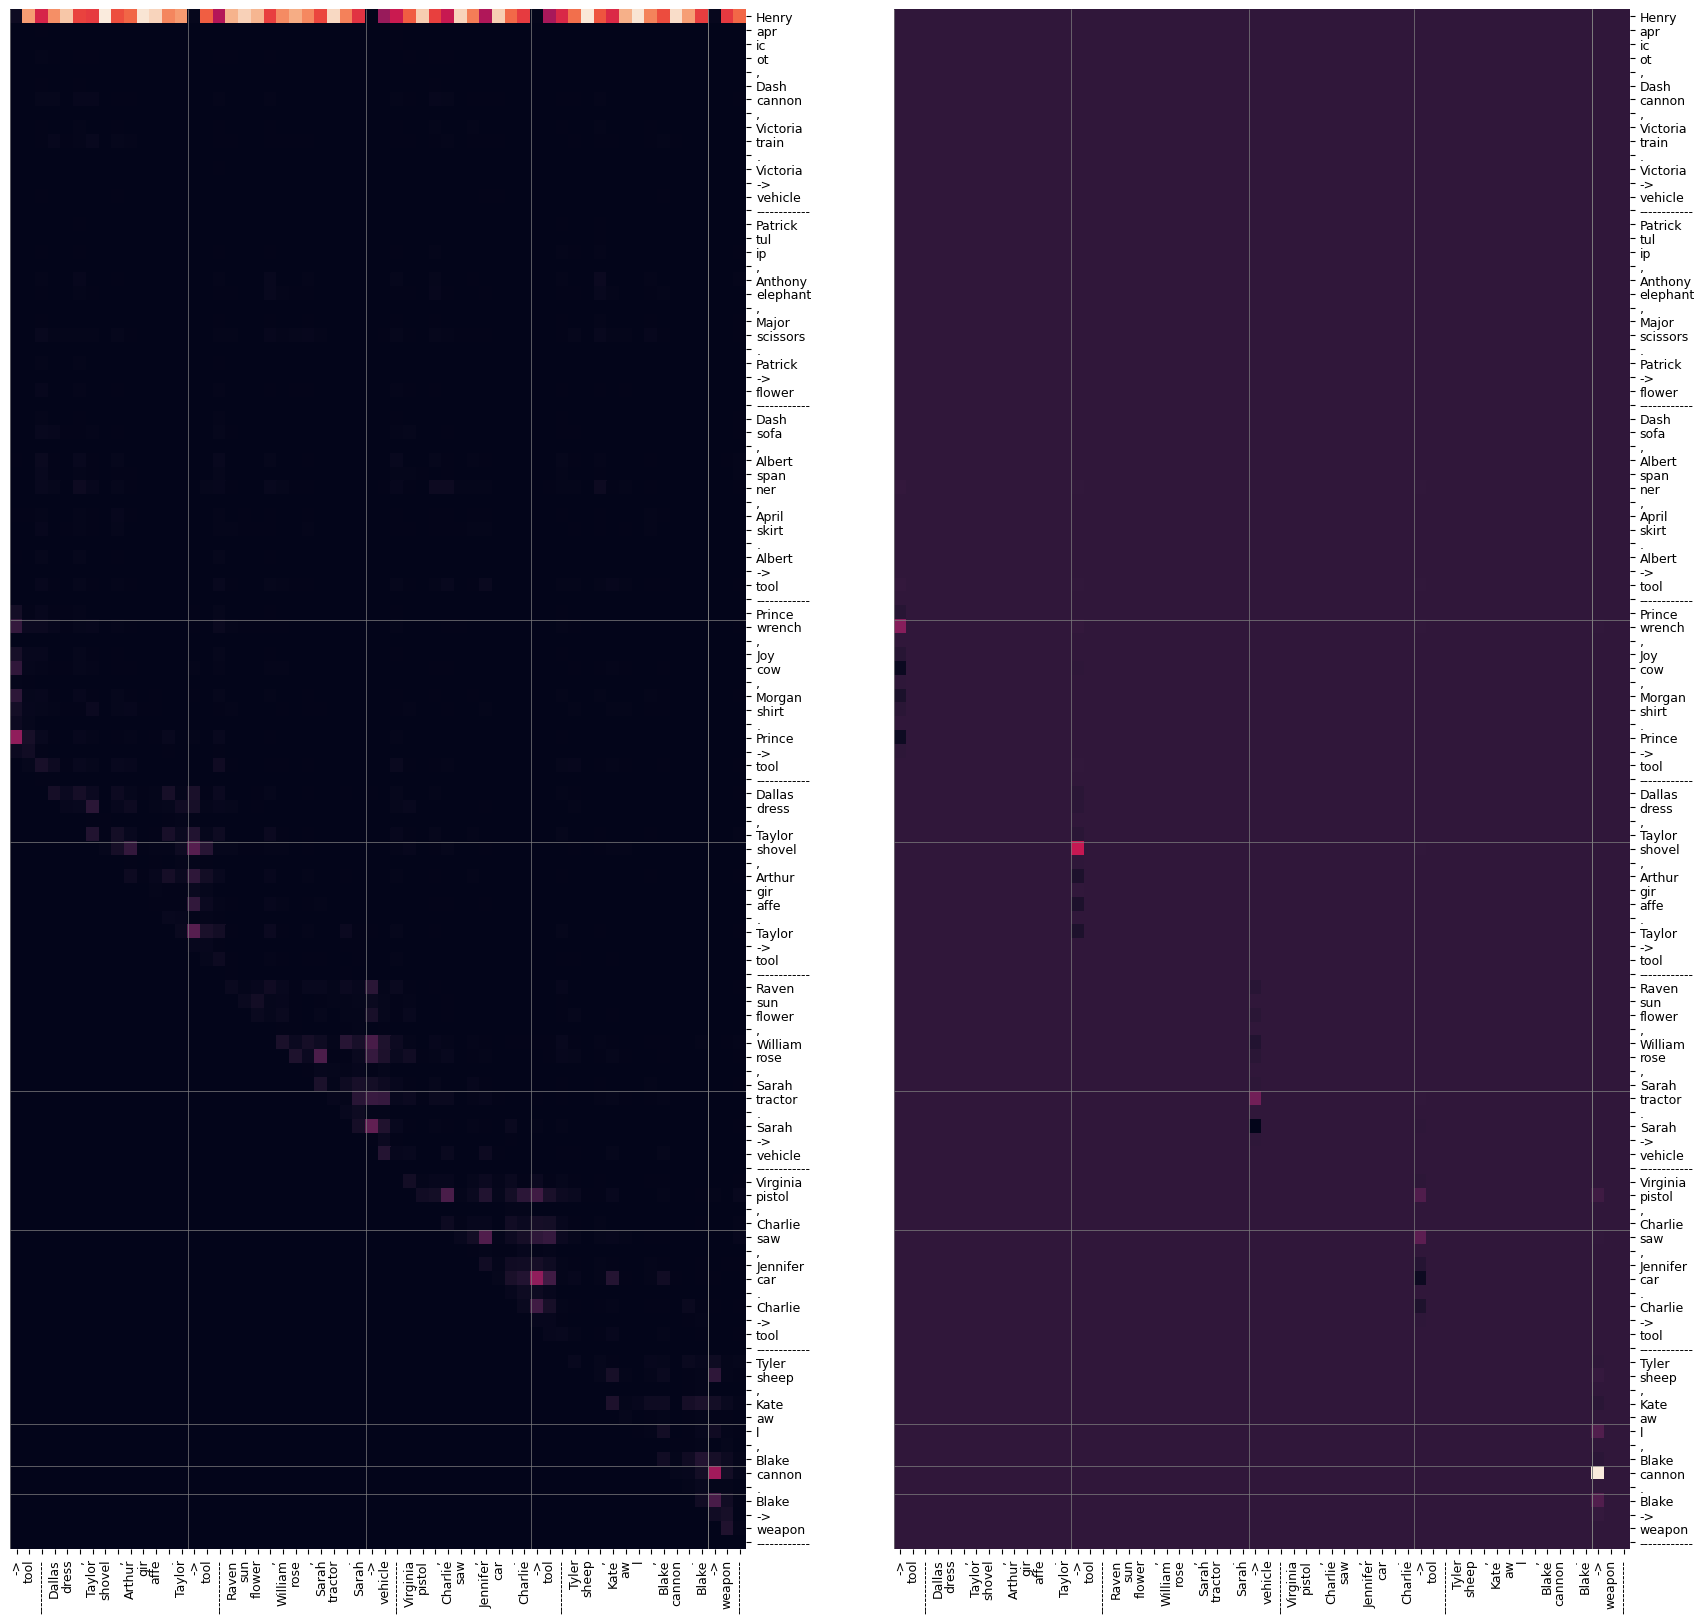

done 0:00:04.529914
sum_forward ... done 0:00:00.550848
tensor([-10.9991,  -7.2463,  -7.2504,  -9.1482])
 Ġclothing 0.0 {'Ġnickname': 0.921, 'Ġsurname': 0.058, 'Ġpronunciation': 0.014, 'Ġpronouns': 0.003} 	 Jamie pants, Prince monkey, Gary peach. Jamie -> clothing
 Ġvehicle 0.0 {'Ġwardrobe': 0.555, 'Ġclothing': 0.359, 'Ġclothes': 0.014, 'Ġgender': 0.01} 	 Edward ship, Jamie hammer, Jane coat. Edward -> vehicle
 Ġanimal 0.0 {'Ġalphabet': 0.947, 'Ġspelling': 0.013, 'Ġstereotypes': 0.009, 'Ġnaming': 0.008} 	 John scissors, Clark dog, Graham airplane. Clark -> animal
 Ġappliance 0.0 {'Ġwater': 0.517, 'Ġmoisture': 0.152, 'Ġwaterproof': 0.145, 'ĠWater': 0.111} 	 Angel mango, Elsa durian, Ocean dryer. Ocean -> appliance
 Ġanimal 0.213 {'Ġgenetics': 0.236, 'Ġanimal': 0.213, 'Ġnaming': 0.174, 'Ġgenetic': 0.12} 	 Virginia apricot, Dash horse, Ruby plum. Dash -> animal
 Ġinsect 0.011 {'Ġalphabet': 0.207, 'gender': 0.094, 'Ġpuzzles': 0.082, 'Ġmasculine': 0.065} 	 India horse, Andy ant, Jack pliers

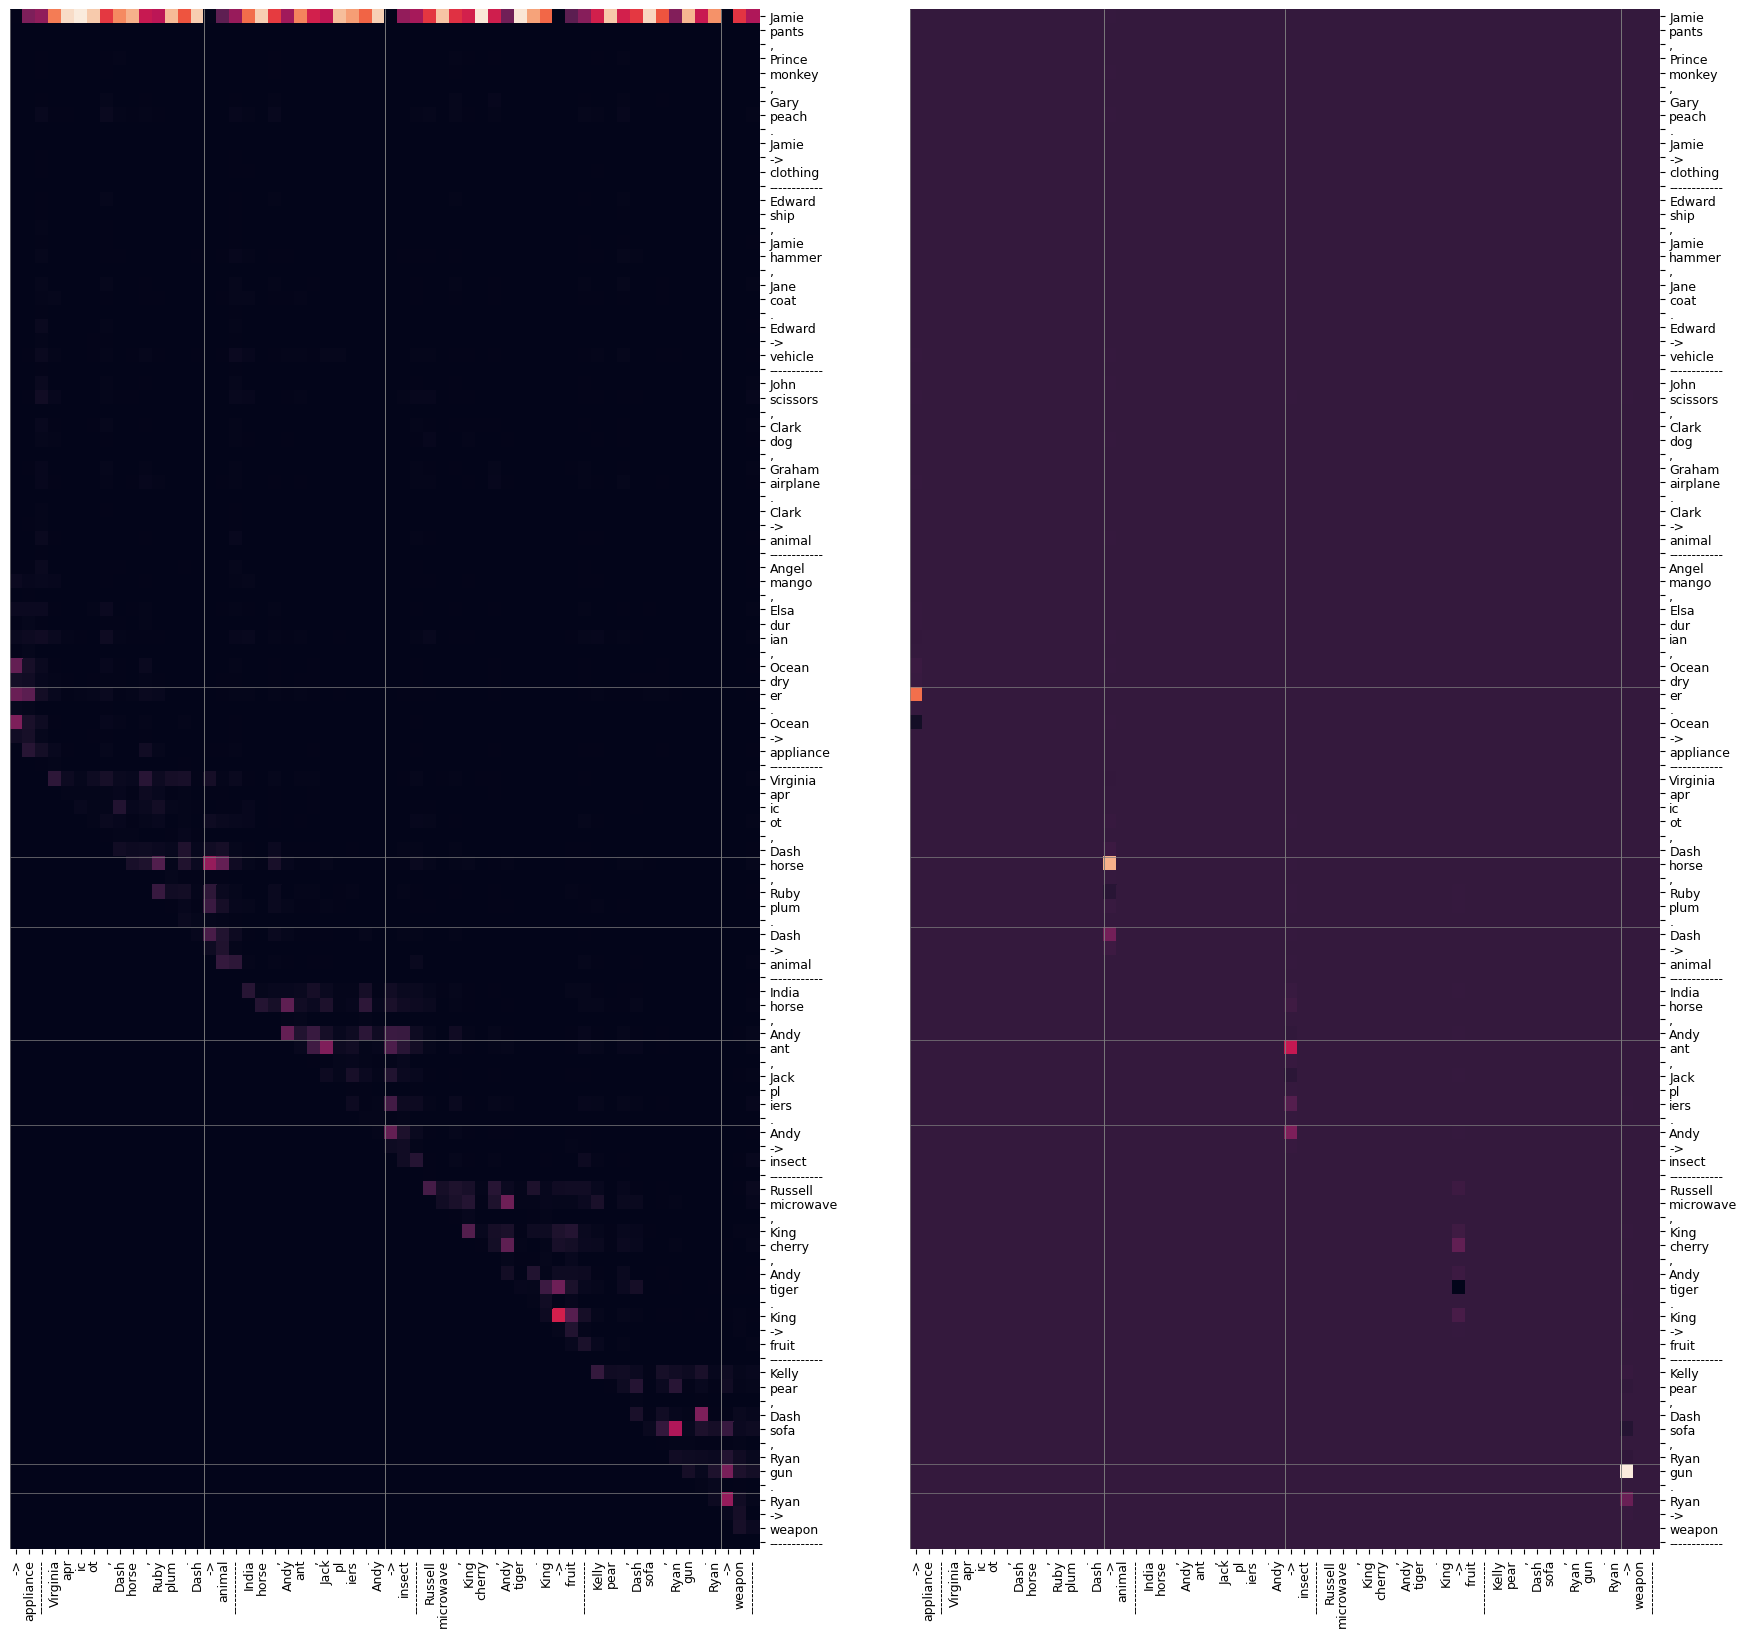

done 0:00:04.428394
sum_forward ... done 0:00:00.533640
tensor([-11.1608,  -7.6573,  -7.5092,  -9.4712])
 Ġweapon 0.0 {'Ġgadgets': 0.327, 'Ġappliances': 0.187, 'Ġitems': 0.145, 'ĠGadget': 0.048} 	 Arthur pistol, Jamie dress, Sky microwave. Arthur -> weapon
*Ġfurniture 0.913 {'Ġfurniture': 0.913, 'Ġwardrobe': 0.032, 'Ġclothing': 0.012, 'ĠClothing': 0.005} 	 King blackberry, Graham tie, Johnny couch. Johnny -> furniture
 Ġappliance 0.0 {'Ġcolors': 0.462, 'Ġcolor': 0.262, 'Ġcolour': 0.097, 'Ġcoloring': 0.08} 	 Andy blackberry, Grey microwave, Summer goat. Grey -> appliance
 Ġinsect 0.071 {'Ġallergic': 0.15, 'Ġallergy': 0.107, 'Ġpoison': 0.1, 'Ġinsect': 0.071} 	 Andrew shirt, Victoria dagger, King wasp. King -> insect
 Ġclothing 0.0 {'Ġfood': 0.385, 'Ġtasting': 0.207, 'Ġaroma': 0.121, 'Ġdietary': 0.061} 	 Anna apple, Henry jacket, Andrew grape. Henry -> clothing
 Ġclothing 0.0 {'Ġnaming': 0.384, 'Ġalphabet': 0.065, 'Ġrename': 0.059, 'Ġsmell': 0.053} 	 Eva skirt, Jack washing machine, Augus

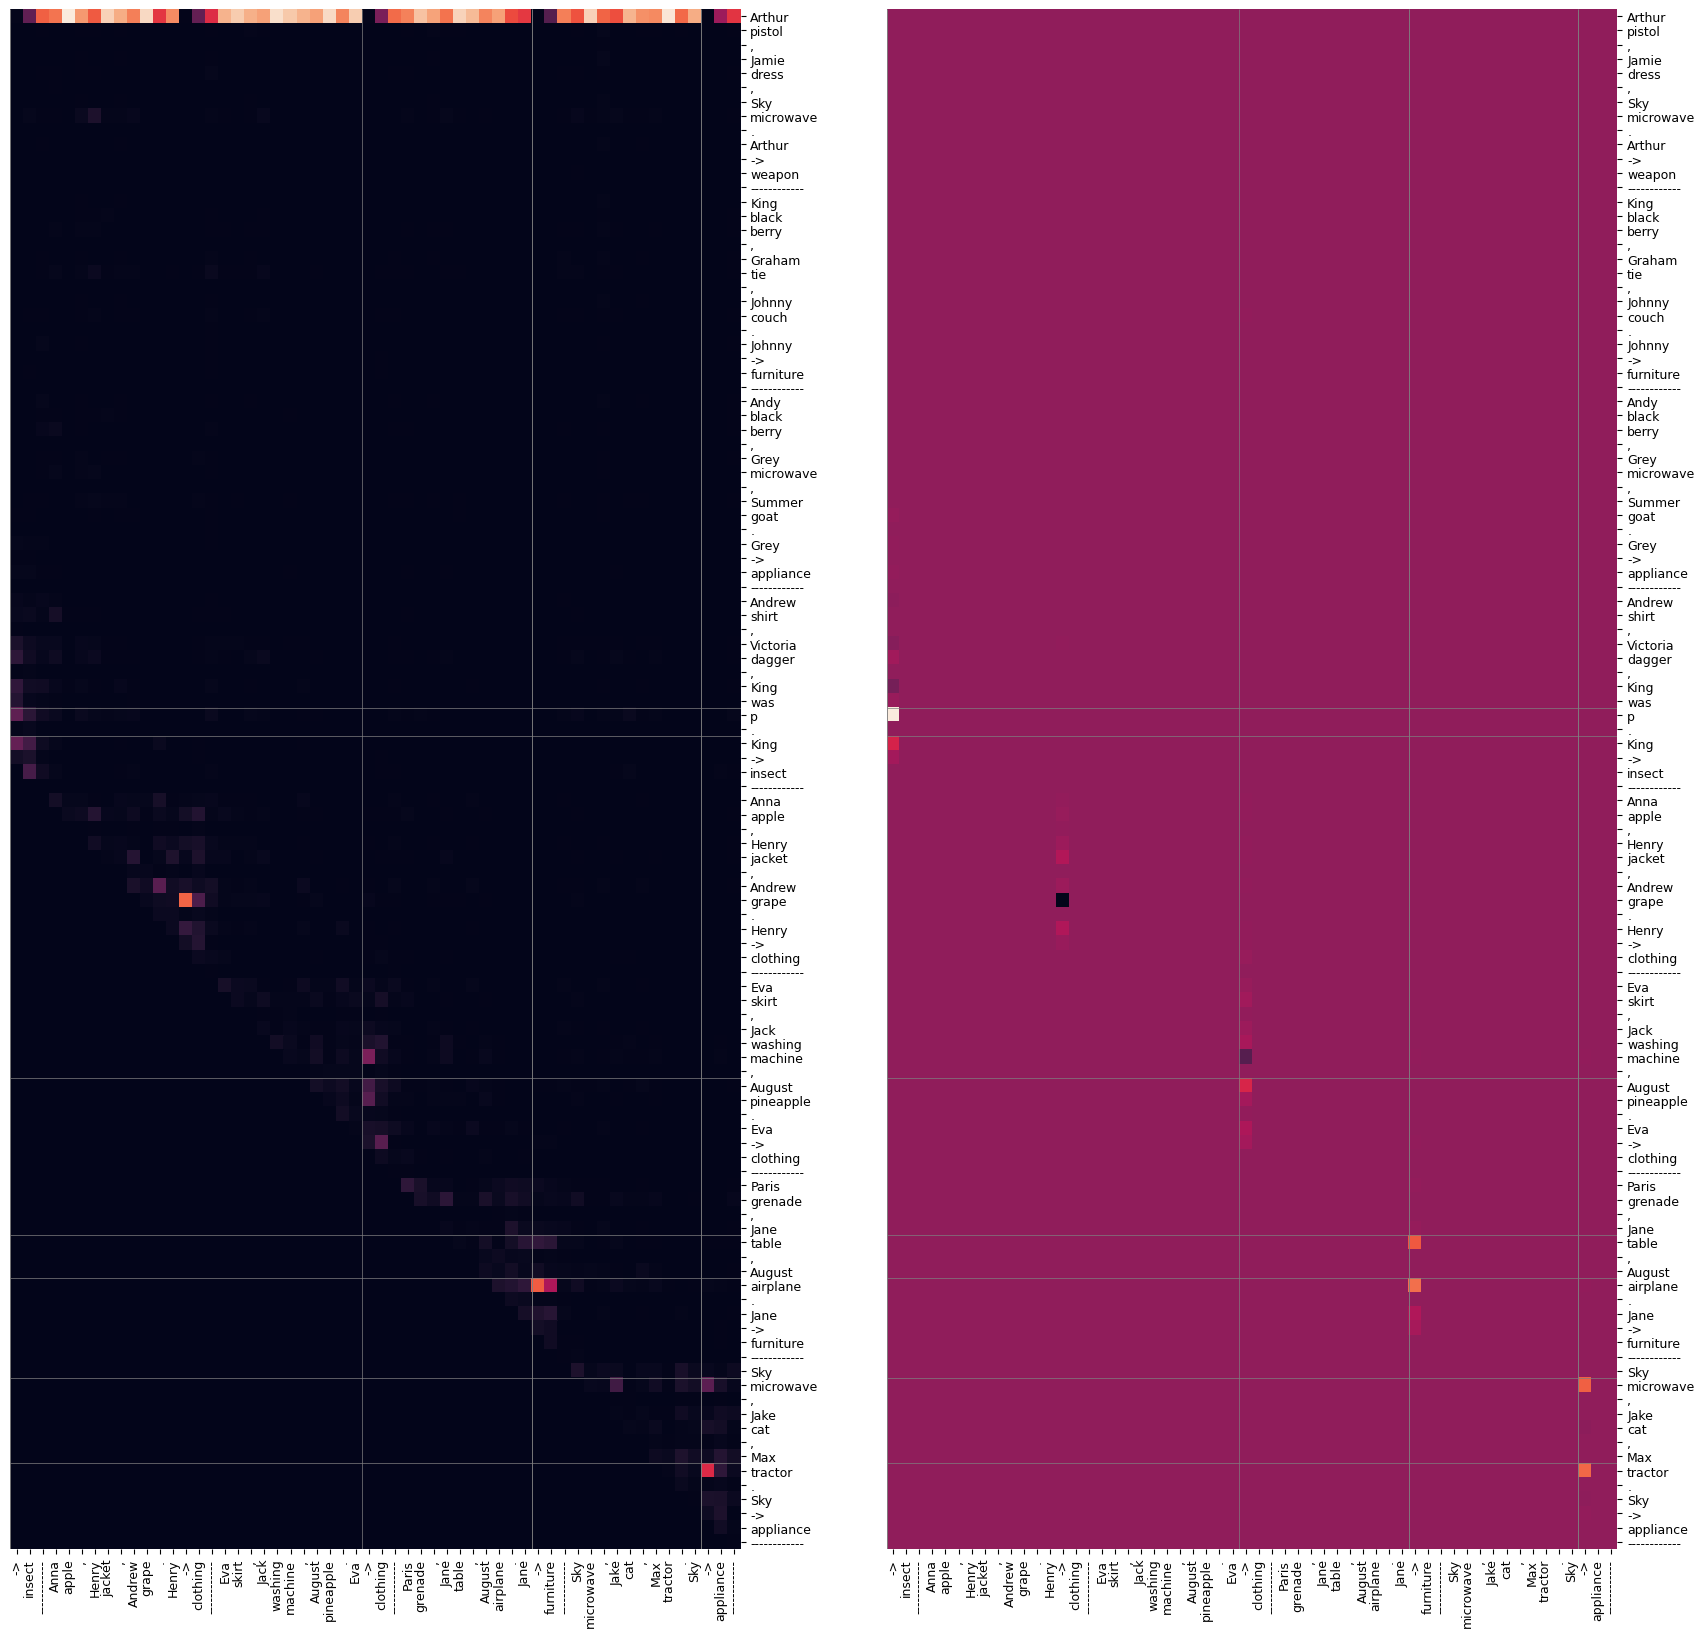

done 0:00:04.375038


In [300]:
attr = node.data.attr; data_tuples = result.data_tuples
for l, h, v in [(13, 7, 0), (21, 5, 0), (15, 8, 0)]: #list(zip(*topk_md(attr.head, 6))):
# for l, v, h in list(zip(*topk_md(attr.mlp, 5) + ([-1]*5,))):
    print(l, h, v)#, get_head_rank(attr2.head, l, h))#, eigv_positivity[l, h], pos_score[l, h])
    for text, input_ids, labels, ranges, *args, o in data_tuples[:4]:
        attn_attr = o.attn_attr
        fns = path2fns(node, root, partial(node2fn, model=model, outputs=o, labels=labels))
        fwd_fn = partial(sum_forward, outputs=o, output_layer=l)
        _labels = labels if len(fns) == 0 else None
        # _labels = get_argmax_labels(model, o.hidden_states[-2], _labels)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l], labels=_labels) \
            if h >= 0 else partial(mlp_forward, layer=l, labels=_labels)
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        _, ys, logits = attribute(fwd_fn, model, x, [fn] + fns, num_points=3, forward_only=True); print(ys)
        if iterable(logits): logits = sum(logits)
        if logits.size(-1) == model.lm_head.out_features:  # lm_logits
            _ = show_predictions(tokenizer, *args, logits=logits[-1:], labels=_labels, topk=4, sep='\t')
        elif logits.size(-1) == input_ids.size(1): # attn_logits, bij
            plot_attn(logits[-1].softmax(dim=-1), tokens, figsize=(5, 5))  # bnij->ij
            plot(logits[-1, -3, :13])

        if h == -1: continue
        attn, aa = o.attentions[l][0, h], attn_attr[node.name][l, h]
        bos_indices = args[1]; ystart = (si <= 0)*bos_indices[k_shot]; ystop = aa.size(0)
        # fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10*(ystop-ystart)/aa.size(0)))
        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(40*(ystop-ystart)/aa.size(0), 20))
        tokens = [t.replace('Ġ', '').replace('Ċ', '-'*12) for t in tokenizer.convert_ids_to_tokens(input_ids[0])]
        y_pos, x_pos, _ = topk_md(aa, k=nrows-k_shot)
        with Timer():
            for ax, a in zip(axs, [attn, aa]):
                plot_attn(a, tokens, ax=ax, ystart=ystart, ystop=ystop, y_pos=y_pos, x_pos=x_pos,
                fontsize=9, transpose=True, use_imshow=False)
            plt.show()

In [ ]:
group0 = [(1, 7), (6, 2), (8, 7)]; group1 = [(3, 6), (3, 11), (4, 8), (6, 10)]
neuron = attr.neuron
for (l0, h0), (l1, h1) in product(group0, group1):
    print(f'{l0}-{h0}, {l1}-{h1}', nn.CosineSimilarity(0)(neuron[l0, h0].mean(0), neuron[l1, h1].mean(0)))
print()
for (l0, h0), (l1, h1) in combinations(group0, 2):
    print(f'{l0}-{h0}, {l1}-{h1}', nn.CosineSimilarity(0)(neuron[l0, h0].mean(0), neuron[l1, h1].mean(0)))
print()
for (l0, h0), (l1, h1) in combinations(group1, 2):
    print(f'{l0}-{h0}, {l1}-{h1}', nn.CosineSimilarity(0)(neuron[l0, h0].mean(0), neuron[l1, h1].mean(0)))

In [ ]:
attr = nodes[i].data.attr
for l, h, v in zip(*topk_md(attr.head, 1)):
    # if l != 14: continue
    print(l, h, v, get_head_rank(attr2.head, l, h))
    for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[1:2]:
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        fwd_fn = partial(sum_forward, outputs=o)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l],
                            labels=labels if len(fns) == 0 else None)
        post_fwd_fn = compose_forward_fns([fn] + fns, scaled=True)
        _, ys, logits = attribute(fwd_fn, model, x, post_fwd_fn, num_points=3, batch_size=3); print(ys)
        if logits.size(-1) == model.lm_head.out_features:
            show_predictions(text, examples, tokenizer, logits[-1:], bos_indices, eos_indices, answers, labels, 
                topk=4, show_range=range(k_shot, len(examples)), sep='\t')

        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
        aa = attn_attr[nodes[i].name][l, h]
        # attn_labels = aa / (aa.sum(-1, keepdim=True) + 1e-9)  # ij->i1
        for ax, a in zip(axs, [o.attentions[l][0, h], aa, ]):
            plot_attn(a, tokens, ax=ax)
        plt.show()

In [ ]:
# 对某层的attn_weights单独梯度归因
attrs = []
for attribute_layer in range(27):
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'head_mask': torch.ones(1, H, o.hidden_states[0].size(1))}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y, num_points=8)
    ys
    attrs.append(attr)
    
head_attr2 = rearrange([attr['head_mask'] for attr in attrs], 'l n i -> l n i')
head_attr2 = torch.einsum('lni->ln', head_attr2)
list(zip(*topk_md(head_attr2, 10)))

# 对某层的attn_weights单独梯度归因
for attribute_layer, attribute_head, __ in list(zip(*topk_md(head_attr, 10)))[:3]: # heads 27-17, 17-4, 22-13
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'attn_weights': o.attentions[attribute_layer]}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y)
    # ys
    print(attribute_layer, attribute_head)
    plot_attn(attr['attn_weights'][attribute_head], tokens, figsize=(5, 5))
    plt.show()

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [ ]:
# 找第2重要的induction head（17-4）的K-composition heads
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[1]
layer, head
aw_label = binarize(attn_attr[layer, head])
wq, wk = get_head_weights(layer, head)[:2]

In [ ]:
# 对head_output归因
query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

In [ ]:
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [ ]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, j_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

In [ ]:
for l, h, v in zip(*topk_md(attn_head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

## Tune intermediary heads

In [ ]:
d = defaultdict(int)
pairs = []
for l0, h0, l2, h2 in zip(*np.unravel_index(affinities.view(-1).topk(500).indices, affinities.size())):
    if d[(l0, h0)] < 10:
        d[(l0, h0)] += 1
        pairs.append(((l0, h0), (l2, h2)))
        if len(pairs) == 100: break
Counter([(l0, h0) for (l0, h0), (l2, h2) in pairs]).most_common()
random.shuffle(pairs)
train_set, val_set = pairs[:-20], pairs[-20:]

In [ ]:
def w_forward(head_pairs, wv1, wo1, alpha=0.1, compute_eigv=False):
    wvs0, wos0, wqs2, wks2 = zip(*[get_head_weights(model, l0, h0, transpose=True)[2:] +
                                get_head_weights(model, l2, h2, transpose=True)[:2] 
                                for (l0, h0), (l2, h2) in head_pairs])
    wvs0, wos0 = rearrange(list(wvs0), 'b e d -> b e d'), rearrange(list(wos0), 'b d e -> b d e')
    wqs2, wks2 = rearrange(list(wqs2), 'b e d -> b e d'), rearrange(list(wks2), 'b e d -> b e d')
    wvs0, wos0, wqs2, wks2 = wvs0.to(device), wos0.to(device), wqs2.to(device), wks2.to(device)
    wvo1 = wv1 @ wo1
    q, kT = wvs0 @ wos0 @ wvo1 @ wqs2, wks2.transpose(-2, -1)
    comp_norm = (q @ kT).norm(dim=(-2, -1)).mean()
    # loss = -comp_norm / wvo1.norm()
    loss = -(comp_norm - alpha * wvo1.norm())
    eigvs = [plot_eigv(m.eig()[0], plot=False) for m in kT @ q] if compute_eigv else None
    return loss, comp_norm, eigvs
    
def eval(dataset, wv1, wo1, bsz=8, compute_eigv=False, e=None, wu=None):
    losses, eigvs, comp_norms = [], [], []
    for i in range(len(dataset) // bsz):
        loss, comp_norm, _eigvs = w_forward(dataset[i * bsz: (i + 1) * bsz], wv1, wo1, compute_eigv=compute_eigv)
        losses.append(loss.item())
        comp_norms.append(comp_norm.item())
        if compute_eigv: eigvs += _eigvs
    if compute_eigv:
        print(torch.Tensor(eigvs))
        # e = model.transformer.h[l1].ln_1(_e)
        A, B = wu @ wo1.T.to('cpu'), e @ wv1.to('cpu')
        print('wvo1 eigv_pos =', plot_eigv((B.T @ A).eig()[0], plot=False))
    return round(sum(losses) / len(losses), 4), round(sum(comp_norms) / len(comp_norms), 4), round((wv1 @ wo1).norm().item(), 4)

In [ ]:
device = 'cuda'
wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
wv1, wo1 = wv1.detach().clone(), wo1.detach().clone()
wv1, wo1 = wv1.to(device), wo1.to(device)
_ = wv1.requires_grad_(True); _ = wo1.requires_grad_(True)
optimizer = optim.AdamW([wv1, wo1], lr=1e-4)
bsz, eval_bsz = 8, 4
# test(model, data_tuples)
# test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=wo1.to('cpu'))
# test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=2*wo1.to('cpu'))
with torch.no_grad(): print('Epoch', -1, 'train', eval(train_set, wv1, wo1), 
                        'val', eval(val_set, wv1, wo1, bsz=eval_bsz, compute_eigv=True, e=e, wu=wu))
for epoch in range(2):
    random.shuffle(train_set)
    for i in tqdm(range(len(train_set) // bsz)):
        optimizer.zero_grad()
        loss = w_forward(train_set[i * bsz: (i + 1) * bsz], wv1, wo1)[0]
        loss.backward()
        optimizer.step()
    with torch.no_grad(): print('Epoch', epoch, 'train', eval(train_set, wv1, wo1), 
                            'val', eval(val_set, wv1, wo1, bsz=eval_bsz, compute_eigv=True, e=e, wu=wu),)
                            # test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=wo1.to('cpu')))

In [ ]:
all_attrs, all_yss = {}, {}

In [ ]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [ ]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [ ]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

In [ ]:
_ = sns.heatmap(mean_nattrs, cbar=True)

In [ ]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [ ]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [ ]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

In [ ]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

In [ ]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [ ]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

In [ ]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [ ]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [ ]:
(l2, h2), (l1, h1) = chains[4]

In [ ]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [ ]:
e[:10] = 0

In [ ]:
scatter_plot(e)

In [ ]:
e = WOV[l2][h2].eig()[0]

In [ ]:
scatter_plot(e)

In [ ]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

In [ ]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [ ]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

In [ ]:
plot_eigenvalues(wov_evs)

In [ ]:
w_eu = w_e.matmul(w_u)

In [ ]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [ ]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [ ]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [ ]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions

In [ ]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

In [ ]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

In [ ]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [ ]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [ ]:
ww.norm(dim=0).topk(40).indices

In [ ]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

In [ ]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [ ]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

In [ ]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [ ]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [ ]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

In [ ]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [ ]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

In [ ]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [ ]:
aw = ww * ww.grad

In [ ]:
aw.norm(dim=0).topk(10)

In [ ]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

In [ ]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [ ]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [ ]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [ ]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

In [ ]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

In [ ]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

In [ ]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

In [ ]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

In [ ]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

In [ ]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [ ]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [ ]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

In [ ]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [ ]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [ ]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [ ]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

In [ ]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

In [ ]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
attn_grad[0, head - 2].mean()

In [ ]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

In [ ]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [ ]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [ ]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

In [ ]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

In [ ]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

In [ ]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

In [ ]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

In [ ]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [ ]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [ ]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

In [ ]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]